In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,#unetr
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)
import logging
logging.disable(logging.WARNING)


import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp90mo4spr


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [5]:
#fold0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


In [6]:
# # slice_map = {
# #     "img0035.nii.gz": 170,
# #     "img0036.nii.gz": 230,
# #     "img0037.nii.gz": 204,
# #     "img0038.nii.gz": 204,
# #     "img0039.nii.gz": 204,
# #     "img0040.nii.gz": 180,
# # }
# slice_map = {
#     "img0029.nii.gz": 90,
#     "img0030.nii.gz": 230,
#     "img0031.nii.gz": 204,
#     "img0032.nii.gz": 204,
#     "img0033.nii.gz": 204,
#     "img0034.nii.gz": 180,
# }
# case_num = 0
# img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
# img = val_ds[case_num]["image"]
# label = val_ds[case_num]["label"]
# img_shape = img.shape
# label_shape = label.shape
# print(f"image shape: {img_shape}, label shape: {label_shape}")
# plt.figure("image", (18, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
# plt.show()

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunet_onmiccai13_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold0_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.48062): 100%|█| 24/24 [00:24<00:00,  1.01s/i
Training (47 / 25000 Steps) (loss=2.13553): 100%|█| 24/24 [00:18<00:00,  1.27it/
Training (71 / 25000 Steps) (loss=2.18449): 100%|█| 24/24 [00:18<00:00,  1.27it/
Training (95 / 25000 Steps) (loss=1.72413): 100%|█| 24/24 [00:18<00:00,  1.27it/
Training (119 / 25000 Steps) (loss=1.83228): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (143 / 25000 Steps) (loss=1.67240): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (167 / 25000 Steps) (loss=1.80271): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (191 / 25000 Steps) (loss=1.74495): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (215 / 25000 Steps) (loss=1.59746): 100%|█| 24/24 [00:19<00:00,  1.26it
Training (239 / 25000 Steps) (loss=1.69933): 100%|█| 24/24 [00:19<00:00,  1.26it
Training (263 / 25000 Steps) (loss=1.52843): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (287 / 25000 Steps) (loss=1.65463): 100%|█| 24/24 [00:18<00:00,  1.26it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.13221566379070282 Current Avg. Dice: 0.13221566379070282


Training (503 / 25000 Steps) (loss=1.35250): 100%|█| 24/24 [00:36<00:00,  1.51s/
Training (527 / 25000 Steps) (loss=1.43471): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=1.50948): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (575 / 25000 Steps) (loss=1.31334): 100%|█| 24/24 [00:18<00:00,  1.26it
Training (599 / 25000 Steps) (loss=1.41634): 100%|█| 24/24 [00:19<00:00,  1.26it
Training (623 / 25000 Steps) (loss=1.27485): 100%|█| 24/24 [00:18<00:00,  1.26it
Training (647 / 25000 Steps) (loss=1.38430): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (671 / 25000 Steps) (loss=1.21216): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=1.35292): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=1.21955): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=1.54361): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=1.14005): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.21493996679782867 Current Avg. Dice: 0.21493996679782867


Training (1007 / 25000 Steps) (loss=1.20291): 100%|█| 24/24 [00:36<00:00,  1.51s
Training (1031 / 25000 Steps) (loss=1.10942): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1055 / 25000 Steps) (loss=1.07340): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=1.05827): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1103 / 25000 Steps) (loss=1.09204): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1127 / 25000 Steps) (loss=1.00045): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=1.14028): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=1.30451): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=1.25556): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1223 / 25000 Steps) (loss=1.15719): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1247 / 25000 Steps) (loss=1.20932): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=1.15834): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.38829922676086426 Current Avg. Dice: 0.38829922676086426


Training (1511 / 25000 Steps) (loss=1.10831): 100%|█| 24/24 [00:36<00:00,  1.51s
Training (1535 / 25000 Steps) (loss=1.03818): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=1.30583): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1583 / 25000 Steps) (loss=1.24516): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=1.10417): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=0.99073): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1655 / 25000 Steps) (loss=1.09666): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1679 / 25000 Steps) (loss=0.97530): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=1.07107): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=1.04725): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=1.03119): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1775 / 25000 Steps) (loss=1.00899): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5123042464256287 Current Avg. Dice: 0.5123042464256287


Training (2015 / 25000 Steps) (loss=1.02308): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (2039 / 25000 Steps) (loss=1.00811): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2063 / 25000 Steps) (loss=0.99224): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2087 / 25000 Steps) (loss=1.00199): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2111 / 25000 Steps) (loss=0.97645): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2135 / 25000 Steps) (loss=0.89122): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.96927): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=1.05040): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=0.92504): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2231 / 25000 Steps) (loss=0.94160): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2255 / 25000 Steps) (loss=0.93844): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2279 / 25000 Steps) (loss=0.87364): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6025575399398804 Current Avg. Dice: 0.6025575399398804


Training (2519 / 25000 Steps) (loss=0.89596): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (2543 / 25000 Steps) (loss=0.87901): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=0.84149): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2591 / 25000 Steps) (loss=0.89166): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=0.74269): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2639 / 25000 Steps) (loss=0.85851): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2663 / 25000 Steps) (loss=0.84419): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.68955): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.79344): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2735 / 25000 Steps) (loss=0.83354): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2759 / 25000 Steps) (loss=0.86471): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.82278): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6383823752403259 Current Avg. Dice: 0.6383823752403259


Training (3023 / 25000 Steps) (loss=0.81634): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (3047 / 25000 Steps) (loss=0.85066): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.92056): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.73386): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3119 / 25000 Steps) (loss=0.82527): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=0.74054): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=0.88182): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.74250): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3215 / 25000 Steps) (loss=0.86939): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3239 / 25000 Steps) (loss=1.03336): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.78517): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3287 / 25000 Steps) (loss=0.82152): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6784685254096985 Current Avg. Dice: 0.6784685254096985


Training (3503 / 25000 Steps) (loss=0.90889): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (3527 / 25000 Steps) (loss=0.68381): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3551 / 25000 Steps) (loss=0.89021): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3575 / 25000 Steps) (loss=0.87166): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.82223): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.96101): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=0.70601): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3671 / 25000 Steps) (loss=0.86236): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.84854): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=0.89694): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=0.99325): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=0.85046): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7026078104972839 Current Avg. Dice: 0.7026078104972839


Training (4007 / 25000 Steps) (loss=0.71720): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (4031 / 25000 Steps) (loss=0.70570): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4055 / 25000 Steps) (loss=0.86530): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.74675): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.76601): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=0.81547): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4151 / 25000 Steps) (loss=0.85065): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=0.71520): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4199 / 25000 Steps) (loss=0.76068): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=0.86991): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4247 / 25000 Steps) (loss=0.59307): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4271 / 25000 Steps) (loss=0.88058): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7100081443786621 Current Avg. Dice: 0.7100081443786621


Training (4511 / 25000 Steps) (loss=0.89296): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (4535 / 25000 Steps) (loss=0.64925): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=0.71526): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.74965): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4607 / 25000 Steps) (loss=0.96250): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.81981): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=0.85250): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.80516): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4703 / 25000 Steps) (loss=0.73935): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4727 / 25000 Steps) (loss=0.85283): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4751 / 25000 Steps) (loss=0.91394): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4775 / 25000 Steps) (loss=0.73934): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7100081443786621 Current Avg. Dice: 0.6890875697135925


Training (5015 / 25000 Steps) (loss=0.80444): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (5039 / 25000 Steps) (loss=0.89620): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5063 / 25000 Steps) (loss=0.69618): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5087 / 25000 Steps) (loss=0.73577): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.84373): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.78979): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.72639): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5183 / 25000 Steps) (loss=0.69431): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5207 / 25000 Steps) (loss=1.01970): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=1.34730): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5255 / 25000 Steps) (loss=0.84753): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.69596): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7100081443786621 Current Avg. Dice: 0.7066152691841125


Training (5519 / 25000 Steps) (loss=0.77960): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (5543 / 25000 Steps) (loss=0.75414): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.83732): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.63029): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5615 / 25000 Steps) (loss=0.78115): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5639 / 25000 Steps) (loss=0.81146): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=0.86006): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5687 / 25000 Steps) (loss=0.68831): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.73935): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5735 / 25000 Steps) (loss=0.76290): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5759 / 25000 Steps) (loss=0.81201): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.71651): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7578797340393066 Current Avg. Dice: 0.7578797340393066


Training (6023 / 25000 Steps) (loss=0.68902): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (6047 / 25000 Steps) (loss=0.64564): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6071 / 25000 Steps) (loss=0.75930): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.84241): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6119 / 25000 Steps) (loss=0.72513): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.93260): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6167 / 25000 Steps) (loss=0.62529): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6191 / 25000 Steps) (loss=0.79418): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6215 / 25000 Steps) (loss=0.64175): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.81015): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.60611): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.60065): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7643132209777832 Current Avg. Dice: 0.7643132209777832


Training (6503 / 25000 Steps) (loss=0.82433): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (6527 / 25000 Steps) (loss=0.79258): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.84619): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6575 / 25000 Steps) (loss=0.68728): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.76596): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6623 / 25000 Steps) (loss=0.71166): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6647 / 25000 Steps) (loss=0.47705): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6671 / 25000 Steps) (loss=0.77243): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6695 / 25000 Steps) (loss=0.74164): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.79476): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6743 / 25000 Steps) (loss=0.64784): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.80643): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7824354767799377 Current Avg. Dice: 0.7824354767799377


Training (7007 / 25000 Steps) (loss=0.63210): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (7031 / 25000 Steps) (loss=0.66340): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.59300): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=0.72696): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7103 / 25000 Steps) (loss=0.85284): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7127 / 25000 Steps) (loss=0.84377): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.68461): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.90874): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.69615): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7223 / 25000 Steps) (loss=0.55969): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7247 / 25000 Steps) (loss=0.58720): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.41780): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8091104626655579 Current Avg. Dice: 0.8091104626655579


Training (7511 / 25000 Steps) (loss=0.80874): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (7535 / 25000 Steps) (loss=0.53544): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.73076): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.49734): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=0.71604): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7631 / 25000 Steps) (loss=0.67087): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7655 / 25000 Steps) (loss=0.64780): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.87186): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7703 / 25000 Steps) (loss=0.41593): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=0.62383): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7751 / 25000 Steps) (loss=0.51408): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.73410): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8091104626655579 Current Avg. Dice: 0.8083505630493164


Training (8015 / 25000 Steps) (loss=0.81406): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (8039 / 25000 Steps) (loss=0.74181): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8063 / 25000 Steps) (loss=0.63613): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.66446): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.68282): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.68049): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8159 / 25000 Steps) (loss=0.78607): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8183 / 25000 Steps) (loss=0.92162): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8207 / 25000 Steps) (loss=0.58113): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8231 / 25000 Steps) (loss=0.88591): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8255 / 25000 Steps) (loss=0.55684): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8279 / 25000 Steps) (loss=0.58388): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8132103085517883 Current Avg. Dice: 0.8132103085517883


Training (8519 / 25000 Steps) (loss=0.63135): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (8543 / 25000 Steps) (loss=0.69101): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8567 / 25000 Steps) (loss=0.77259): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.73944): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=0.61630): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.60236): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8663 / 25000 Steps) (loss=0.70472): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8687 / 25000 Steps) (loss=0.53315): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8711 / 25000 Steps) (loss=0.84649): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8735 / 25000 Steps) (loss=0.60895): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8759 / 25000 Steps) (loss=0.71185): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.61027): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8159618377685547 Current Avg. Dice: 0.8159618377685547


Training (9023 / 25000 Steps) (loss=0.80101): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (9047 / 25000 Steps) (loss=0.74874): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=0.85525): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=0.85488): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9119 / 25000 Steps) (loss=0.77910): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.74971): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.61397): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9191 / 25000 Steps) (loss=0.61373): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9215 / 25000 Steps) (loss=0.86870): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9239 / 25000 Steps) (loss=0.47394): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=0.63151): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9287 / 25000 Steps) (loss=0.69007): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8159618377685547 Current Avg. Dice: 0.798945963382721


Training (9503 / 25000 Steps) (loss=0.64510): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (9527 / 25000 Steps) (loss=0.51488): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9551 / 25000 Steps) (loss=0.67352): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9575 / 25000 Steps) (loss=0.62214): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9599 / 25000 Steps) (loss=0.61219): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.84698): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9647 / 25000 Steps) (loss=0.51569): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9671 / 25000 Steps) (loss=0.64760): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9695 / 25000 Steps) (loss=0.82252): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9719 / 25000 Steps) (loss=0.78142): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=0.33517): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9767 / 25000 Steps) (loss=0.64664): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8174099922180176 Current Avg. Dice: 0.8174099922180176


Training (10007 / 25000 Steps) (loss=0.70241): 100%|█| 24/24 [00:35<00:00,  1.49
Training (10031 / 25000 Steps) (loss=0.64254): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10055 / 25000 Steps) (loss=0.61645): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10079 / 25000 Steps) (loss=0.58293): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10103 / 25000 Steps) (loss=0.59539): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=0.77147): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10151 / 25000 Steps) (loss=0.33607): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10175 / 25000 Steps) (loss=0.53678): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.57336): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10223 / 25000 Steps) (loss=0.62705): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10247 / 25000 Steps) (loss=0.73488): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10271 / 25000 Steps) (loss=0.70712): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8174099922180176 Current Avg. Dice: 0.7994091510772705


Training (10511 / 25000 Steps) (loss=0.53359): 100%|█| 24/24 [00:35<00:00,  1.48
Training (10535 / 25000 Steps) (loss=0.63429): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10559 / 25000 Steps) (loss=0.62101): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10583 / 25000 Steps) (loss=0.62308): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10607 / 25000 Steps) (loss=0.63993): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10631 / 25000 Steps) (loss=0.48631): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10655 / 25000 Steps) (loss=0.70891): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.65731): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10703 / 25000 Steps) (loss=0.69382): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10727 / 25000 Steps) (loss=0.56282): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10751 / 25000 Steps) (loss=0.45278): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.69175): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8215413093566895 Current Avg. Dice: 0.8215413093566895


Training (11015 / 25000 Steps) (loss=0.83804): 100%|█| 24/24 [00:35<00:00,  1.49
Training (11039 / 25000 Steps) (loss=0.45695): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11063 / 25000 Steps) (loss=0.57860): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11087 / 25000 Steps) (loss=0.57621): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11111 / 25000 Steps) (loss=0.55693): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.68636): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11159 / 25000 Steps) (loss=0.85660): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11183 / 25000 Steps) (loss=0.57718): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=0.57003): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11231 / 25000 Steps) (loss=0.74315): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11255 / 25000 Steps) (loss=0.65701): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11279 / 25000 Steps) (loss=0.78162): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8224127888679504 Current Avg. Dice: 0.8224127888679504


Training (11519 / 25000 Steps) (loss=0.56056): 100%|█| 24/24 [00:35<00:00,  1.48
Training (11543 / 25000 Steps) (loss=0.75525): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11567 / 25000 Steps) (loss=0.56030): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11591 / 25000 Steps) (loss=0.76481): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11615 / 25000 Steps) (loss=0.43209): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11639 / 25000 Steps) (loss=0.54122): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11663 / 25000 Steps) (loss=0.75344): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11687 / 25000 Steps) (loss=0.63827): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11711 / 25000 Steps) (loss=0.81629): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.63200): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11759 / 25000 Steps) (loss=0.90422): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11783 / 25000 Steps) (loss=0.58075): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8224127888679504 Current Avg. Dice: 0.8222792744636536


Training (12023 / 25000 Steps) (loss=0.63891): 100%|█| 24/24 [00:35<00:00,  1.47
Training (12047 / 25000 Steps) (loss=0.54777): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12071 / 25000 Steps) (loss=0.76181): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=0.68335): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12119 / 25000 Steps) (loss=0.35445): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12143 / 25000 Steps) (loss=0.67451): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.57986): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12191 / 25000 Steps) (loss=0.63774): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12215 / 25000 Steps) (loss=0.74463): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12239 / 25000 Steps) (loss=0.76881): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12263 / 25000 Steps) (loss=0.73334): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.60579): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8224127888679504 Current Avg. Dice: 0.8011618256568909


Training (12503 / 25000 Steps) (loss=0.61243): 100%|█| 24/24 [00:35<00:00,  1.47
Training (12527 / 25000 Steps) (loss=0.65462): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=0.40479): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12575 / 25000 Steps) (loss=0.50923): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12599 / 25000 Steps) (loss=0.75319): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12623 / 25000 Steps) (loss=0.56088): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.70981): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.49809): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12695 / 25000 Steps) (loss=0.62021): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.75623): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12743 / 25000 Steps) (loss=0.71582): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12767 / 25000 Steps) (loss=0.71699): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8232372403144836 Current Avg. Dice: 0.8232372403144836


Training (13007 / 25000 Steps) (loss=0.70540): 100%|█| 24/24 [00:35<00:00,  1.48
Training (13031 / 25000 Steps) (loss=0.76844): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13055 / 25000 Steps) (loss=0.56071): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.66619): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13103 / 25000 Steps) (loss=0.73996): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13127 / 25000 Steps) (loss=0.72943): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13151 / 25000 Steps) (loss=0.74280): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13175 / 25000 Steps) (loss=0.52143): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.62554): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=0.45617): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13247 / 25000 Steps) (loss=0.81947): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.79609): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.8308946490287781


Training (13511 / 25000 Steps) (loss=0.63829): 100%|█| 24/24 [00:35<00:00,  1.48
Training (13535 / 25000 Steps) (loss=0.58859): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=1.09511): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13583 / 25000 Steps) (loss=0.64639): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.53167): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13631 / 25000 Steps) (loss=0.50716): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13655 / 25000 Steps) (loss=0.70851): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13679 / 25000 Steps) (loss=0.71211): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13703 / 25000 Steps) (loss=0.60615): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13727 / 25000 Steps) (loss=0.43105): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=0.62538): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=0.76155): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.823418915271759


Training (14015 / 25000 Steps) (loss=0.72761): 100%|█| 24/24 [00:35<00:00,  1.47
Training (14039 / 25000 Steps) (loss=0.60045): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.51169): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14087 / 25000 Steps) (loss=0.49583): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.72660): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14135 / 25000 Steps) (loss=0.81276): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14159 / 25000 Steps) (loss=0.59056): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14183 / 25000 Steps) (loss=0.75117): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.70105): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14231 / 25000 Steps) (loss=0.62773): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14255 / 25000 Steps) (loss=0.88035): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14279 / 25000 Steps) (loss=0.64368): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.8200659155845642


Training (14519 / 25000 Steps) (loss=0.71569): 100%|█| 24/24 [00:35<00:00,  1.47
Training (14543 / 25000 Steps) (loss=0.65768): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14567 / 25000 Steps) (loss=0.74694): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14591 / 25000 Steps) (loss=0.52208): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14615 / 25000 Steps) (loss=0.68144): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=0.54764): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14663 / 25000 Steps) (loss=0.69929): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14687 / 25000 Steps) (loss=0.82575): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14711 / 25000 Steps) (loss=0.61367): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14735 / 25000 Steps) (loss=0.60611): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14759 / 25000 Steps) (loss=0.70608): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14783 / 25000 Steps) (loss=0.40560): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.8165184855461121


Training (15023 / 25000 Steps) (loss=0.72270): 100%|█| 24/24 [00:35<00:00,  1.48
Training (15047 / 25000 Steps) (loss=0.81239): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15071 / 25000 Steps) (loss=0.66504): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15095 / 25000 Steps) (loss=0.76964): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15119 / 25000 Steps) (loss=0.60531): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.68992): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.54318): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.84102): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.66967): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15239 / 25000 Steps) (loss=0.71843): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.65437): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15287 / 25000 Steps) (loss=0.53013): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.8249848484992981


Training (15503 / 25000 Steps) (loss=0.49031): 100%|█| 24/24 [00:35<00:00,  1.50
Training (15527 / 25000 Steps) (loss=0.62308): 100%|█| 24/24 [00:18<00:00,  1.27
Training (15551 / 25000 Steps) (loss=0.57921): 100%|█| 24/24 [00:18<00:00,  1.27
Training (15575 / 25000 Steps) (loss=0.40368): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15599 / 25000 Steps) (loss=0.70794): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15623 / 25000 Steps) (loss=0.71178): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.56328): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.70421): 100%|█| 24/24 [00:18<00:00,  1.27
Training (15695 / 25000 Steps) (loss=0.91339): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15719 / 25000 Steps) (loss=0.55009): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15743 / 25000 Steps) (loss=0.55843): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15767 / 25000 Steps) (loss=0.38349): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.8285641074180603


Training (16007 / 25000 Steps) (loss=0.59925): 100%|█| 24/24 [00:36<00:00,  1.50
Training (16031 / 25000 Steps) (loss=0.62301): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16055 / 25000 Steps) (loss=0.69037): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16079 / 25000 Steps) (loss=0.49253): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16103 / 25000 Steps) (loss=0.69735): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16127 / 25000 Steps) (loss=0.80580): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16151 / 25000 Steps) (loss=0.81873): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16175 / 25000 Steps) (loss=0.63411): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16199 / 25000 Steps) (loss=0.67764): 100%|█| 24/24 [00:18<00:00,  1.27
Training (16223 / 25000 Steps) (loss=0.75042): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16247 / 25000 Steps) (loss=0.68710): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16271 / 25000 Steps) (loss=0.44569): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.8218090534210205


Training (16511 / 25000 Steps) (loss=0.56836): 100%|█| 24/24 [00:35<00:00,  1.50
Training (16535 / 25000 Steps) (loss=0.70638): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.80757): 100%|█| 24/24 [00:18<00:00,  1.26
Training (16583 / 25000 Steps) (loss=0.64850): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16607 / 25000 Steps) (loss=0.77143): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=0.69900): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.68149): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.50833): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16703 / 25000 Steps) (loss=0.69011): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.55322): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.61524): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16775 / 25000 Steps) (loss=0.45057): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.8238957524299622


Training (17015 / 25000 Steps) (loss=0.38875): 100%|█| 24/24 [00:35<00:00,  1.48
Training (17039 / 25000 Steps) (loss=0.75625): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17063 / 25000 Steps) (loss=0.46121): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17087 / 25000 Steps) (loss=0.58990): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17111 / 25000 Steps) (loss=0.60373): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17135 / 25000 Steps) (loss=0.56675): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17159 / 25000 Steps) (loss=0.62342): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17183 / 25000 Steps) (loss=0.50770): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17207 / 25000 Steps) (loss=0.65943): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17231 / 25000 Steps) (loss=0.53070): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17255 / 25000 Steps) (loss=0.46655): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.68652): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8308946490287781 Current Avg. Dice: 0.8257988095283508


Training (17519 / 25000 Steps) (loss=0.42248): 100%|█| 24/24 [00:35<00:00,  1.47
Training (17543 / 25000 Steps) (loss=0.84752): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17567 / 25000 Steps) (loss=0.63067): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17591 / 25000 Steps) (loss=0.59429): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17615 / 25000 Steps) (loss=0.58416): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17639 / 25000 Steps) (loss=0.56599): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17663 / 25000 Steps) (loss=0.67219): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17687 / 25000 Steps) (loss=0.62488): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17711 / 25000 Steps) (loss=0.52470): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17735 / 25000 Steps) (loss=0.39605): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17759 / 25000 Steps) (loss=0.55623): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17783 / 25000 Steps) (loss=0.84167): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8343766331672668


Training (18023 / 25000 Steps) (loss=0.49124): 100%|█| 24/24 [00:35<00:00,  1.49
Training (18047 / 25000 Steps) (loss=0.61426): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18071 / 25000 Steps) (loss=0.78333): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.56418): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18119 / 25000 Steps) (loss=0.66138): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18143 / 25000 Steps) (loss=0.74024): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18167 / 25000 Steps) (loss=0.50835): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18191 / 25000 Steps) (loss=0.72174): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18215 / 25000 Steps) (loss=0.67677): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.83453): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18263 / 25000 Steps) (loss=0.57299): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18287 / 25000 Steps) (loss=0.58017): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8314337730407715


Training (18503 / 25000 Steps) (loss=0.60594): 100%|█| 24/24 [00:35<00:00,  1.47
Training (18527 / 25000 Steps) (loss=0.55786): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18551 / 25000 Steps) (loss=0.68141): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18575 / 25000 Steps) (loss=0.61525): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18599 / 25000 Steps) (loss=0.41403): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18623 / 25000 Steps) (loss=0.52111): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18647 / 25000 Steps) (loss=0.63980): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18671 / 25000 Steps) (loss=0.71646): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18695 / 25000 Steps) (loss=0.88266): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.70445): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=0.46169): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18767 / 25000 Steps) (loss=0.71941): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8279056549072266


Training (19007 / 25000 Steps) (loss=0.52888): 100%|█| 24/24 [00:35<00:00,  1.47
Training (19031 / 25000 Steps) (loss=0.74610): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19055 / 25000 Steps) (loss=0.79764): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19079 / 25000 Steps) (loss=0.54877): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19103 / 25000 Steps) (loss=0.82206): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19127 / 25000 Steps) (loss=0.55657): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19151 / 25000 Steps) (loss=0.57241): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19175 / 25000 Steps) (loss=0.69013): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.96249): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19223 / 25000 Steps) (loss=0.51410): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19247 / 25000 Steps) (loss=0.74841): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19271 / 25000 Steps) (loss=0.64346): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8281028866767883


Training (19511 / 25000 Steps) (loss=0.32448): 100%|█| 24/24 [00:35<00:00,  1.47
Training (19535 / 25000 Steps) (loss=0.55823): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19559 / 25000 Steps) (loss=0.74514): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19583 / 25000 Steps) (loss=0.48673): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19607 / 25000 Steps) (loss=0.72128): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19631 / 25000 Steps) (loss=0.61389): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19655 / 25000 Steps) (loss=0.80700): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.65950): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19703 / 25000 Steps) (loss=0.85947): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19727 / 25000 Steps) (loss=0.57273): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19751 / 25000 Steps) (loss=0.68453): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19775 / 25000 Steps) (loss=0.71958): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8172006607055664


Training (20015 / 25000 Steps) (loss=0.54637): 100%|█| 24/24 [00:35<00:00,  1.47
Training (20039 / 25000 Steps) (loss=0.70463): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20063 / 25000 Steps) (loss=0.35506): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20087 / 25000 Steps) (loss=0.62024): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20111 / 25000 Steps) (loss=0.66629): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20135 / 25000 Steps) (loss=0.56372): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20159 / 25000 Steps) (loss=0.64722): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.55421): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20207 / 25000 Steps) (loss=0.56578): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20231 / 25000 Steps) (loss=0.62028): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20255 / 25000 Steps) (loss=0.54172): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20279 / 25000 Steps) (loss=0.61759): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8317193984985352


Training (20519 / 25000 Steps) (loss=0.83670): 100%|█| 24/24 [00:35<00:00,  1.47
Training (20543 / 25000 Steps) (loss=0.59499): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20567 / 25000 Steps) (loss=0.34265): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20591 / 25000 Steps) (loss=0.58470): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.75519): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.73622): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.69708): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20687 / 25000 Steps) (loss=0.49087): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20711 / 25000 Steps) (loss=0.69786): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.60960): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=0.51277): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.65110): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8339425921440125


Training (21023 / 25000 Steps) (loss=0.57051): 100%|█| 24/24 [00:35<00:00,  1.47
Training (21047 / 25000 Steps) (loss=0.67380): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21071 / 25000 Steps) (loss=0.45958): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=0.68749): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.63047): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.76797): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21167 / 25000 Steps) (loss=0.61594): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.61704): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.43553): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=0.72988): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21263 / 25000 Steps) (loss=0.73565): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.58846): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8261540532112122


Training (21503 / 25000 Steps) (loss=0.47170): 100%|█| 24/24 [00:35<00:00,  1.48
Training (21527 / 25000 Steps) (loss=0.69285): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21551 / 25000 Steps) (loss=0.62484): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.43512): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=0.66395): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21623 / 25000 Steps) (loss=0.60310): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21647 / 25000 Steps) (loss=0.50392): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21671 / 25000 Steps) (loss=0.59674): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21695 / 25000 Steps) (loss=0.42524): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21719 / 25000 Steps) (loss=0.64681): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21743 / 25000 Steps) (loss=0.44845): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21767 / 25000 Steps) (loss=0.69008): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8254994750022888


Training (22007 / 25000 Steps) (loss=0.54723): 100%|█| 24/24 [00:35<00:00,  1.47
Training (22031 / 25000 Steps) (loss=0.77141): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22055 / 25000 Steps) (loss=0.58085): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22079 / 25000 Steps) (loss=0.65201): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22103 / 25000 Steps) (loss=0.71670): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22127 / 25000 Steps) (loss=0.50057): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22151 / 25000 Steps) (loss=0.67914): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22175 / 25000 Steps) (loss=0.52532): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22199 / 25000 Steps) (loss=0.48627): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.30828): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22247 / 25000 Steps) (loss=0.44488): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.78084): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8343766331672668 Current Avg. Dice: 0.8239452838897705


Training (22511 / 25000 Steps) (loss=0.50294): 100%|█| 24/24 [00:35<00:00,  1.47
Training (22535 / 25000 Steps) (loss=0.89518): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22559 / 25000 Steps) (loss=0.55427): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=0.55112): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22607 / 25000 Steps) (loss=0.67857): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22631 / 25000 Steps) (loss=0.67162): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22655 / 25000 Steps) (loss=0.54040): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22679 / 25000 Steps) (loss=0.52961): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.70412): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22727 / 25000 Steps) (loss=0.75812): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22751 / 25000 Steps) (loss=0.68459): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22775 / 25000 Steps) (loss=0.57023): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8355998396873474 Current Avg. Dice: 0.8355998396873474


Training (23015 / 25000 Steps) (loss=0.78447): 100%|█| 24/24 [00:35<00:00,  1.48
Training (23039 / 25000 Steps) (loss=0.71658): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23063 / 25000 Steps) (loss=0.47056): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23087 / 25000 Steps) (loss=0.76914): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23111 / 25000 Steps) (loss=0.73236): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23135 / 25000 Steps) (loss=0.69533): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23159 / 25000 Steps) (loss=0.54913): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23183 / 25000 Steps) (loss=0.67114): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23207 / 25000 Steps) (loss=0.47557): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23231 / 25000 Steps) (loss=0.70975): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23255 / 25000 Steps) (loss=0.71635): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=0.47384): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8355998396873474 Current Avg. Dice: 0.8207147717475891


Training (23519 / 25000 Steps) (loss=0.57456): 100%|█| 24/24 [00:35<00:00,  1.47
Training (23543 / 25000 Steps) (loss=0.58589): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23567 / 25000 Steps) (loss=0.73691): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23591 / 25000 Steps) (loss=0.67376): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23615 / 25000 Steps) (loss=0.32173): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23639 / 25000 Steps) (loss=0.62303): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23663 / 25000 Steps) (loss=0.57820): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23687 / 25000 Steps) (loss=0.42897): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23711 / 25000 Steps) (loss=0.78150): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23735 / 25000 Steps) (loss=0.56406): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.71126): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.38695): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8355998396873474 Current Avg. Dice: 0.8269400596618652


Training (24023 / 25000 Steps) (loss=0.73243): 100%|█| 24/24 [00:35<00:00,  1.47
Training (24047 / 25000 Steps) (loss=0.62799): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24071 / 25000 Steps) (loss=0.46677): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24095 / 25000 Steps) (loss=0.59590): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24119 / 25000 Steps) (loss=0.69270): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24143 / 25000 Steps) (loss=0.62668): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24167 / 25000 Steps) (loss=0.69999): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24191 / 25000 Steps) (loss=0.43078): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24215 / 25000 Steps) (loss=0.43462): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24239 / 25000 Steps) (loss=0.69105): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24263 / 25000 Steps) (loss=0.65153): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24287 / 25000 Steps) (loss=0.66582): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8355998396873474 Current Avg. Dice: 0.8262904286384583


Training (24503 / 25000 Steps) (loss=0.82110): 100%|█| 24/24 [00:35<00:00,  1.47
Training (24527 / 25000 Steps) (loss=0.73926): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24551 / 25000 Steps) (loss=0.56495): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24575 / 25000 Steps) (loss=0.52791): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24599 / 25000 Steps) (loss=0.53585): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24623 / 25000 Steps) (loss=0.48330): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=0.50906): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.46913): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24695 / 25000 Steps) (loss=0.50855): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.63994): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24743 / 25000 Steps) (loss=0.37418): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24767 / 25000 Steps) (loss=0.48082): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8355998396873474 Current Avg. Dice: 0.8220630288124084


Training (25007 / 25000 Steps) (loss=0.41718): 100%|█| 24/24 [00:35<00:00,  1.48


In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8356 at iteration: 23000


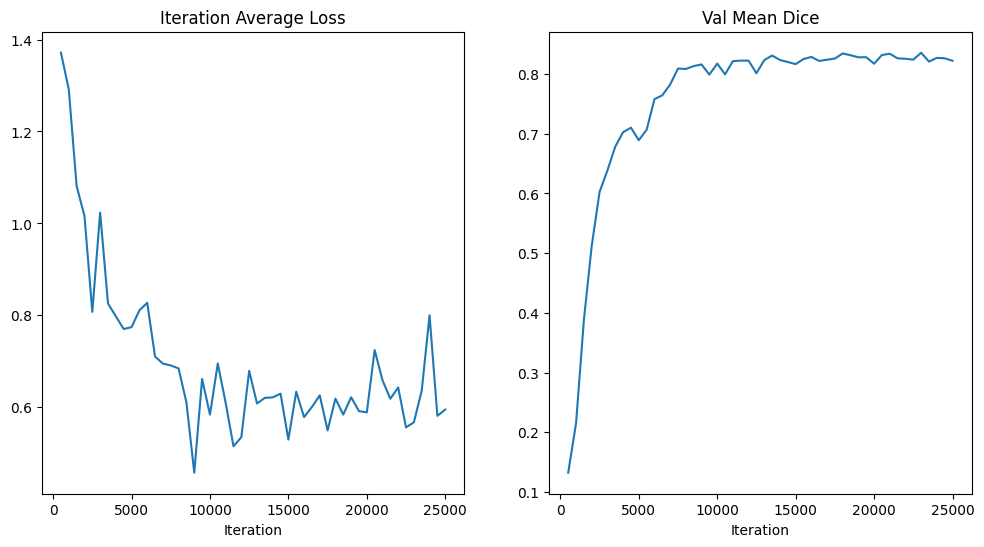

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [13]:
# case_num = 4
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold1_best_metric_model.pth")))
# model.eval()
# with torch.no_grad():
#     img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
#     img = val_ds[case_num]["image"]
#     label = val_ds[case_num]["label"]data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA9gAAAIjCAYAAAD4CLMfAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/NK7nSAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOy9d3gc5bn+f8/2lVbdktxky9iOCyHGGOyAqcHYh4AhyaET6pcWIJzASXJwgu0QAv5xTkJIoYXQApjQIQmEmhCaQzGYaoN7l2yra1e72jK/P3bed2b7zO7M7Mzq+VyXLvBqdnc00s7M8973cz+CKIoiCIIgCIIgCIIgCIIoCUe5d4AgCIIgCIIgCIIgKgEqsAmCIAiCIAiCIAhCB6jAJgiCIAiCIAiCIAgdoAKbIAiCIAiCIAiCIHSACmyCIAiCIAiCIAiC0AEqsAmCIAiCIAiCIAhCB6jAJgiCIAiCIAiCIAgdoAKbIAiCIAiCIAiCIHSACmyCIAiCIAiCIAiC0AEqsAmiCF577TUIgoDXXnut3LtCEARBEEQZ2bJlCwRBwP3331/uXbE07e3tOP/888u9GwRhOFRgE2Xn/vvvhyAIeP/99/ljzz//PH72s5+Vb6ckbr/9dktfMOfOnQtBEHDHHXeUe1csBVsAeeKJJ8q9KwRBEISFOOmkk1BVVYWBgYGc25x99tnweDzo6urS9b3ZtUkQBDz00ENZt5k/fz4EQcBXv/pVXd9bb44++mj+szgcDtTW1mLatGk455xz8PLLL5d79wiirFCBTViS559/Htdff325dyNngX3kkUdiaGgIRx55pPk7JbF+/Xq89957aG9vx8MPP1y2/SAIgiAIu3D22WdjaGgITz/9dNbvh0IhPPvss/iP//gPNDU1GbIPPp8PK1euzHh8y5YtePvtt+Hz+Qx5X70ZP348HnzwQfzpT3/C//3f/+Gkk07C22+/jYULF+L0009HNBpN2f6LL77A3XffXaa9JQjzoAKbGDGIooihoSFdXsvhcMDn88HhKN9H6KGHHkJLSwt+9atf4e2338aWLVtM34dgMGj6exIEQRBEsZx00kmoqanJWuACwLPPPotgMIizzz7bsH345je/iZdffhn79u1LeXzlypVobW3FwQcfbNh760ldXR2++93v4rvf/S4uvfRS/N///R++/PJLXH755Xjsscdw3XXXpWzv9XrhdrvLtLcEYR5UYBOW4/zzz8dtt90GANx+JAgC/34ikcCtt96K/fffHz6fD62trbj00kvR09OT8jrt7e048cQT8eKLL+Lggw+G3+/HXXfdBQC477778I1vfAMtLS3wer2YOXNmhs26vb0dn332Gf71r3/xfTj66KMB5O7BfvzxxzFnzhz4/X6MGjUK3/3ud7Fz586Mny8QCGDnzp341re+hUAggObmZvzwhz9EPB5XfZxWrlyJU045BSeeeCLq6upSbhaeeOIJCIKAf/3rXxnPu+uuuyAIAj799FP+2Lp163DKKaegsbERPp8PBx98MP7yl7+kPI9Z+f/1r3/h8ssvR0tLC8aPHw8A2Lp1Ky6//HJMmzYNfr8fTU1NOPXUU7MW/R9//DGOOuoo+P1+jB8/Hr/4xS9w3333QRCEjO3//ve/44gjjkB1dTVqampwwgkn4LPPPlN9jAqxadMmnHrqqWhsbERVVRW+/vWv47nnnsvY7ne/+x32339/VFVVoaGhAQcffHDK8R4YGMAPfvADtLe3w+v1oqWlBccddxw++OAD3faVIAiCKB2/34/vfOc7ePXVV7Fnz56M769cuRI1NTU46aST0N3djR/+8Ic44IADEAgEUFtbi+OPPx4fffRRSftw8sknw+v14vHHH89479NOOw1OpzPr8x566CF+j9HY2IgzzjgD27dvT9nmjTfewKmnnooJEybA6/Wira0NV199dYbAoNe9SDpOpxO//e1vMXPmTPz+979HX18f/162Huze3l5cffXV/Po5fvx4nHvuuSmLD5FIBMuXL8eUKVP4z/TjH/8YkUik6P0kCCNxlXsHCCKdSy+9FLt27cLLL7+MBx98MOv377//flxwwQW46qqrsHnzZvz+97/Hhx9+iLfeeitldfSLL77AmWeeiUsvvRQXX3wxpk2bBgC44447sP/+++Okk06Cy+XCX//6V1x++eVIJBK44oorAAC33norvv/97yMQCOCnP/0pAKC1tTXnfrN9OuSQQ7BixQp0dnbiN7/5Dd566y18+OGHqK+v59vG43EsWrQI8+bNwy9/+Uu88sor+NWvfoXJkyfje9/7XsFj9M4772DDhg2477774PF48J3vfAcPP/wwfvKTnwAATjjhBAQCATz22GM46qijUp776KOPYv/99+f9XZ999hnmz5+PcePG4dprr0V1dTUee+wxfOtb38KTTz6Jb3/72ynPv/zyy9Hc3Ixly5ZxBfu9997D22+/jTPOOAPjx4/Hli1bcMcdd+Doo4/G559/jqqqKgDAzp07ccwxx0AQBCxZsgTV1dX44x//CK/Xm/EzPvjggzjvvPOwaNEi3HzzzQiFQrjjjjtw+OGH48MPP0R7e3vB45SPzs5OHHbYYQiFQrjqqqvQ1NSEBx54ACeddBKeeOIJ/nPffffduOqqq3DKKafgv/7rvxAOh/Hxxx/jnXfewVlnnQUAuOyyy/DEE0/gyiuvxMyZM9HV1YU333wTa9euxUEHHVTSfhIEQRD6cvbZZ+OBBx7AY489hiuvvJI/3t3djRdffBFnnnkm/H4/PvvsMzzzzDM49dRTMWnSJHR2duKuu+7CUUcdhc8//xxjx44t6v2rqqpw8skn45FHHuHX/I8++gifffYZ/vjHP+Ljjz/OeM6NN96IpUuX4rTTTsNFF12EvXv34ne/+x2OPPLIlHuMxx9/HKFQCN/73vfQ1NSEd999F7/73e+wY8eOjIK+1HuRXDidTpx55plYunQp3nzzTZxwwglZtxscHMQRRxyBtWvX4sILL8RBBx2Effv24S9/+Qt27NiBUaNGIZFI4KSTTsKbb76JSy65BDNmzMAnn3yCX//61/jyyy/xzDPPFL2fBGEYIkGUmfvuu08EIL733nv8sSuuuELM9uf5xhtviADEhx9+OOXxF154IePxiRMnigDEF154IeN1QqFQxmOLFi0S99tvv5TH9t9/f/Goo47K2Paf//ynCED85z//KYqiKA4PD4stLS3iV7/6VXFoaIhv97e//U0EIC5btow/dt5554kAxJ///Ocprzl79mxxzpw5Ge+VjSuvvFJsa2sTE4mEKIqi+NJLL4kAxA8//JBvc+aZZ4otLS1iLBbjj+3evVt0OBwp733ssceKBxxwgBgOh/ljiURCPOyww8SpU6fyx9jv6fDDD095TVHMfjxXrVolAhD/9Kc/8ce+//3vi4IgpOxnV1eX2NjYKAIQN2/eLIqiKA4MDIj19fXixRdfnPKaHR0dYl1dXcbj6bDfz+OPP55zmx/84AciAPGNN97gjw0MDIiTJk0S29vbxXg8LoqiKJ588sni/vvvn/f96urqxCuuuCLvNgRBEIQ1iMVi4pgxY8RDDz005fE777xTBCC++OKLoiiKYjgc5tcCxubNm0Wv15tyHd28ebMIQLzvvvvyvq/y2vS3v/1NFARB3LZtmyiKovijH/2I34McddRRKdedLVu2iE6nU7zxxhtTXu+TTz4RXS5XyuPZrscrVqwQBUEQt27dyh8r9V4kfR/Tefrpp0UA4m9+8xv+2MSJE8XzzjuP/3vZsmUiAPGpp57KeD67v3nwwQdFh8ORcq0WRfl39dZbbxXcV4IwG7KIE7bi8ccfR11dHY477jjs27ePf82ZMweBQAD//Oc/U7afNGkSFi1alPE6fr+f/39fXx/27duHo446Cps2bUqxM6nl/fffx549e3D55ZenhJOccMIJmD59elbb8WWXXZby7yOOOAKbNm0q+F6xWAyPPvooTj/9dG6dZ3Z3ZdjZ6aefjj179qTY2J944gkkEgmcfvrpAJKr9f/4xz9w2mmnYWBggB/Prq4uLFq0COvXr8+wuF988cUZ9jXl8YxGo+jq6sKUKVNQX1+fYpN+4YUXcOihh+LAAw/kjzU2Nmb0ur388svo7e3FmWeemfJ7djqdmDdvXsbvuRief/55zJ07F4cffjh/LBAI4JJLLsGWLVvw+eefAwDq6+uxY8cOvPfeezlfq76+Hu+88w527dpV8n4RBEEQxuJ0OnHGGWdg1apVKa1JrAf62GOPBZDsGWZZK/F4HF1dXQgEApg2bVrJLUALFy5EY2Mj/vznP0MURfz5z3/GmWeemXXbp556ColEAqeddlrKNXH06NGYOnVqyjVReT0OBoPYt28fDjvsMIiiiA8//DDjtYu9FylEIBAAgLxp7U8++SRmzZqV4ZQDwO9vHn/8ccyYMQPTp09P+dm/8Y1vAIAu9wMEoTdUYBO2Yv369ejr60NLSwuam5tTvgYHBzP6qSZNmpT1dd566y0sWLAA1dXVqK+vR3NzM7dXF1Ngb926FQC4BV3J9OnT+fcZPp8Pzc3NKY81NDRk9JFn46WXXsLevXsxd+5cbNiwARs2bMDmzZtxzDHH4JFHHkEikQAA/Md//Afq6urw6KOP8uc++uijOPDAA/GVr3wFALBhwwaIooilS5dmHM/ly5cDgKpjOjQ0hGXLlqGtrQ1erxejRo1Cc3Mzent7U47n1q1bMWXKlIznpz+2fv16AMmFg/T9eumll7L2zWll69atWX9fM2bM4N8HgP/5n/9BIBDA3LlzMXXqVFxxxRV46623Up7zv//7v/j000/R1taGuXPn4mc/+5kuNygEQRCEMbCFXZansWPHDrzxxhs444wz+CJyIpHAr3/9a0ydOjXl2vbxxx8Xda+gxO1249RTT8XKlSvx+uuvY/v27bztKJ3169dDFEVMnTo145q4du3alGvitm3bcP7556OxsZH3VbNWsfR9LuVepBCDg4MAgJqampzbbNy4seA4svXr1+Ozzz7L+LnZfYwe9wMEoTfUg03YikQikaHUKkm/UChXchkbN27Esccei+nTp+OWW25BW1sbPB4Pnn/+efz617/mBaqR5AowUQP72U877bSs3//Xv/6FY445Bl6vF9/61rfw9NNP4/bbb0dnZyfeeust3HTTTXxb9rP+8Ic/zKr0A5nFb7Zj+v3vfx/33XcffvCDH+DQQw9FXV0dBEHAGWecUdTxZM958MEHMXr06Izvu1zmnbpmzJiBL774An/729/wwgsv4Mknn8Ttt9+OZcuW8VFyp512Go444gg8/fTTeOmll/B///d/uPnmm/HUU0/h+OOPN21fCYIgCHXMmTMH06dPxyOPPIKf/OQneOSRRyCKYoqj6qabbsLSpUtx4YUX4oYbbkBjYyMcDgd+8IMf6HKvcNZZZ+HOO+/Ez372M8yaNQszZ87Mul0ikYAgCPj73/+e9f6BqcXxeBzHHXccuru78T//8z+YPn06qqursXPnTpx//vkZ+1zKvUghWJBqtkV1LSQSCRxwwAG45ZZbsn6/ra2tpNcnCCOgApuwJMrUcCWTJ0/GK6+8gvnz52ct9NTw17/+FZFIBH/5y18wYcIE/ng2m1Gu/Uhn4sSJAJKhasy2xPjiiy/490slGAzi2Wefxemnn45TTjkl4/tXXXUVHn74YRxzzDEAkjbxBx54AK+++irWrl0LURS5PRwA9ttvPwDJlfQFCxYUvV9PPPEEzjvvPPzqV7/ij4XDYfT29qZsN3HiRGzYsCHj+emPTZ48GQDQ0tJS0n7lY+LEifjiiy8yHl+3bh3/PqO6uhqnn346Tj/9dAwPD+M73/kObrzxRixZsoS3BIwZMwaXX345Lr/8cuzZswcHHXQQbrzxRiqwCYIgLMrZZ5+NpUuX4uOPP8bKlSsxdepUHHLIIfz7TzzxBI455hjcc889Kc/r7e3FqFGjSn7/ww8/HBMmTMBrr72Gm2++Oed2kydPhiiKmDRpEldus/HJJ5/gyy+/xAMPPIBzzz2XP/7yyy+XvK9aiMfjWLlyJaqqqlLasNKZPHlyykSTXNt89NFHOPbYY1XfkxFEuSGLOGFJqqurASCjQDvttNMQj8dxww03ZDwnFotlbJ8NtmIriiJ/rK+vD/fdd1/W/VDzmgcffDBaWlpw5513poyN+Pvf/461a9fmTNDUytNPP41gMIgrrrgCp5xySsbXiSeeiCeffJLvw4IFC9DY2IhHH30Ujz76KObOnZti8W5pacHRRx+Nu+66C7t37854v71796raL6fTmXI8geRoq/RRH4sWLcKqVauwZs0a/lh3d3eGI2HRokWora3FTTfdhGg0WvR+5eOb3/wm3n33XaxatYo/FgwG8Yc//AHt7e1cSejq6kp5nsfjwcyZMyGKIqLRKOLxeIbtrqWlBWPHjqURIgRBEBaGqdXLli3DmjVrMvJAsl3bHn/88YxskmIRBAG//e1vsXz5cpxzzjk5t/vOd74Dp9OJ66+/PmN/RFHk16ls9zeiKOI3v/mNLvurhng8jquuugpr167FVVddhdra2pzb/ud//ic++ugjPP300xnfYz/Daaedhp07d+Luu+/O2GZoaIhPMyEIK0EKNmFJ5syZAyCpyC5atIgHkhx11FG49NJLsWLFCqxZswYLFy6E2+3G+vXr8fjjj+M3v/lNVmVXycKFC+HxeLB48WJceumlGBwcxN13342WlpaMInPOnDm444478Itf/AJTpkxBS0tLhkINJBXgm2++GRdccAGOOuoonHnmmXxMV3t7O66++mpdjsvDDz+MpqYmHHbYYVm/f9JJJ+Huu+/Gc889h+985ztwu934zne+gz//+c8IBoP45S9/mfGc2267DYcffjgOOOAAXHzxxdhvv/3Q2dmJVatWYceOHarmfZ544ol48MEHUVdXh5kzZ2LVqlV45ZVX0NTUlLLdj3/8Yzz00EM47rjj8P3vf5+P6ZowYQK6u7v56nRtbS3uuOMOnHPOOTjooINwxhlnoLm5Gdu2bcNzzz2H+fPn4/e//33B/XryySe5Iq3kvPPOw7XXXotHHnkExx9/PK666io0NjbigQcewObNm/Hkk0/yYJuFCxdi9OjRmD9/PlpbW7F27Vr8/ve/xwknnICamhr09vZi/PjxOOWUUzBr1iwEAgG88soreO+991IUfYIgCMJaTJo0CYcddhieffZZAMgosE888UT8/Oc/xwUXXIDDDjsMn3zyCR5++GHu/tKDk08+GSeffHLebSZPnoxf/OIXWLJkCbZs2YJvfetbqKmpwebNm/H000/jkksuwQ9/+ENMnz4dkydPxg9/+EPs3LkTtbW1ePLJJ3Xpqc5GX18fHnroIQBAKBTChg0b8NRTT2Hjxo0444wzsoohSn70ox/hiSeewKmnnooLL7wQc+bMQXd3N/7yl7/gzjvvxKxZs3DOOefgsccew2WXXYZ//vOfmD9/PuLxONatW4fHHnsML774Ig4++GBDfj6CKBrzg8sJIpVsY7pisZj4/e9/X2xubhYFQcgY2fWHP/xBnDNnjuj3+8WamhrxgAMOEH/84x+Lu3bt4ttMnDhRPOGEE7K+51/+8hfxa1/7mujz+cT29nbx5ptvFu+9996UUVGimBwLdcIJJ4g1NTUiAD6yK31MF+PRRx8VZ8+eLXq9XrGxsVE8++yzxR07dqRsc95554nV1dUZ+7R8+fKso8kYnZ2dosvlEs8555yc24RCIbGqqkr89re/zR97+eWXRQCiIAji9u3bsz5v48aN4rnnniuOHj1adLvd4rhx48QTTzxRfOKJJ/g22X5PjJ6eHvGCCy4QR40aJQYCAXHRokXiunXrMkZyiKIofvjhh+IRRxwher1ecfz48eKKFSvE3/72tyIAsaOjI2Xbf/7zn+KiRYvEuro60efziZMnTxbPP/988f333895DNjzAOT8YuM+Nm7cKJ5yyilifX296PP5xLlz54p/+9vfUl7rrrvuEo888kixqalJ9Hq94uTJk8Uf/ehHYl9fnyiKohiJRMQf/ehH4qxZs8SamhqxurpanDVrlnj77bfn3UeCIAii/Nx2220iAHHu3LkZ3wuHw+J///d/i2PGjBH9fr84f/58cdWqVeJRRx2VMsKzmDFd+cg1AuvJJ58UDz/8cLG6ulqsrq4Wp0+fLl5xxRXiF198wbf5/PPPxQULFoiBQEAcNWqUePHFF4sfffRRxv4Vey+i3EfldTUQCIhTp04Vv/vd74ovvfRS1udkuyfo6uoSr7zySnHcuHGix+MRx48fL5533nnivn37+DbDw8PizTffLO6///6i1+sVGxoaxDlz5ojXX389vxYThJUQRDHNa0IQBGEyP/jBD3DXXXdhcHDQ0NAVgiAIgiAIgjAS6sEmCMJUhoaGUv7d1dWFBx98EIcffjgV1wRBEARBEIStoR5sgiBM5dBDD8XRRx+NGTNmoLOzE/fccw/6+/uxdOnScu8aQRAEQRAEQZQEFdgEQZjKN7/5TTzxxBP4wx/+AEEQcNBBB+Gee+7BkUceWe5dIwiCIAiCIIiSoB5sgiAIgiAIgiAIgtAB6sEmCIIgiBHGbbfdhvb2dvh8PsybNw/vvvtu3u1vvfVWTJs2DX6/H21tbbj66qsRDof59wcGBvCDH/wAEydOhN/vx2GHHYb33nvP6B+DIAiCICwHFdgEQRAEMYJ49NFHcc0112D58uX44IMPMGvWLCxatAh79uzJuv3KlStx7bXXYvny5Vi7di3uuecePProo/jJT37Ct7nooovw8ssv48EHH8Qnn3yChQsXYsGCBdi5c6dZPxZBEARBWAJbWMQTiQR27dqFmpoaCIJQ7t0hCIIgRjiiKGJgYABjx46Fw2Gvtep58+bhkEMOwe9//3sAyWtsW1sbvv/97+Paa6/N2P7KK6/E2rVr8eqrr/LH/vu//xvvvPMO3nzzTQwNDaGmpgbPPvssTjjhBL7NnDlzcPzxx+MXv/hF1v2IRCKIRCL834lEAt3d3WhqaqJrPUEQBGEJirne2yLkbNeuXWhrayv3bhAEQRBECtu3b8f48ePLvRuqGR4exurVq7FkyRL+mMPhwIIFC7Bq1aqszznssMPw0EMP4d1338XcuXOxadMmPP/88zjnnHMAALFYDPF4HD6fL+V5fr8fb775Zs59WbFiBa6//nodfiqCIAiCMBYt13tbFNg1NTUAkj9YbW1tmfeGIAiCGOn09/ejra2NX5/swr59+xCPx9Ha2pryeGtrK9atW5f1OWeddRb27duHww8/HKIoIhaL4bLLLuMW8ZqaGhx66KG44YYbMGPGDLS2tuKRRx7BqlWrMGXKlJz7smTJElxzzTX83319fZgwYQJd6wmCIAjLUMz13hYFNrOK1dbW0kWXIAiCsAwjwcr82muv4aabbsLtt9+OefPmYcOGDfiv//ov3HDDDXx+/YMPPogLL7wQ48aNg9PpxEEHHYQzzzwTq1evzvm6Xq8XXq8343G61hMEQRBWQ8v13hYFNkEQBEEQpTNq1Cg4nU50dnamPN7Z2YnRo0dnfc7SpUtxzjnn4KKLLgIAHHDAAQgGg7jkkkvw05/+FA6HA5MnT8a//vUvBINB9Pf3Y8yYMTj99NOx3377Gf4zEQRBEISVsFcyC0EQBEEQRePxeDBnzpyUwLJEIoFXX30Vhx56aNbnhEKhjGAXp9MJIBn+oqS6uhpjxoxBT08PXnzxRZx88sk6/wQEQRAEYW1IwSYIgiCIEcQ111yD8847DwcffDDmzp2LW2+9FcFgEBdccAEA4Nxzz8W4ceOwYsUKAMDixYtxyy23YPbs2dwivnTpUixevJgX2i+++CJEUcS0adOwYcMG/OhHP8L06dP5axIEQRDESIEKbIIgCIIYQZx++unYu3cvli1bho6ODhx44IF44YUXePDZtm3bUhTr6667DoIg4LrrrsPOnTvR3NyMxYsX48Ybb+Tb9PX1YcmSJdixYwcaGxvxn//5n7jxxhvhdrtN//kIgiAIopzYYg52f38/6urq0NfXR8EnBEEQRNmh65L+0DElCIIgrEYx1ybqwSYIgiAIgiAIgiAIHaACmyAIgiAIgiAIgiB0gApsgiAIgiAIgiAIgtABKrAJgiAIgiAIgiAIQgeowCYIgiAIgiAIgiAIHaACmyAIgiAIgiAIgiB0gApsgiAIgiAIgiAIgtABKrAJgiAIgiAIgiAIQgeowCYIgiAIgiAIgiAIHaACmyAIgiAIgiAIgiB0gApsgiAIgiAIgiAIgtABKrAJgiA0EonF8cG2HsQTYrl3hSAIgiAIwlQGwlGs2d4LUaT7oGxQgU0QBKGR2/65Ed+5/W089cGOcu8KQRAEQRCEqfzk6U/xrdvewrubu8u9K5aECmyCIAiN7OgOAQB29g6VeU8IgiAIgiDMZdPeQQDAuo6BMu+JNaECmyAIQiORWAIAEI0nyrwnBEEQBEEQ5tI3FAUAdPSHy7wn1oQKbIIgCI1EYnEAQDROvUcEQRAEQYwsWIHdSQV2VqjAJgiC0AhTsIdjpGATBEEQlU08IVKYFcGJJ0QMhGMAqMDOBRXYBEEQGolEpQKbLOIEQRBEBRNPiDjht2/g1DtXUZFNAEgmiDM6+qjAzoar3DtAEARhN8LMIk4KNkEQBFHB7B2I8CCrzv4IRtf5yrxHRLlh9nAg+TdBZEIKNkEQhEZIwSYIe7N3IEJTAAhCBcHhGP//9XsoMZpILbAHIzEMRmJ5th6ZUIFNEAShETnkjApsgrAj37rtLfzHr19HXyhaeGOCGMEEFcXT+s7BMu4JYRWUBTZANvFsUIFNEAShEQo5Iwj7kkiI2Nk7hIFIDO9s7ir37hCEpVGqk+v3UIFNZBbYeyjoLAMqsAmCIDTCC2wa00UQtiOakBfG3tncXcY9IQjrE4rE+f9vsKFF/A+vb8RvX11f7t2oKDIUbCqwM6CQM4IgCI1EohRyRhB2JZ6QF8b+vYkUbILIh7IH+8vOQYiiCEEQyrhH6ukLRXHT8+sAAN/9+kQ0VnvKvEeVARXYhSEFmyAIQiOygk0FNkHYjajCefL57n7qwyaIPAQVCnbfUBT7BofLuDfa2LhPtrR3Deqfdh2OxvH8J7vRHx5Z55D0AruTerAzoAKbIAhCA7F4AjFJAaOQM4KwHzHF51YUgfe2kE2cIHIRTEuIXt9pH5v4RkXPeFdQ/4WBR9/bjssf/gB3vraxqOdv2DOIpz7YYbv54v1SgT0q4AVACnY2qMAmCILQgFK1ppAzgrAfsUTqzSzZxAkiN0qLOGCvoLNN+4L8/3sMKLA7pcJyd5EK7k+e+gTXPPaR7bIgmII9bXQAANBBs7AzoAKbIAhCA2wGNkAWcYKwI+nOk39TkjhB5CRDwbZR0JnRCvaQlMeSfozUsmcgWZh/aSNXACAX2FNbagCQRTwbVGATBEFoIKJQrckiThD2Iyb1YDuknKbPd/Vn9BQSBJEkOJwsIieNqgZgr1nYSgW724ACOywtuKer/GoZlPrbt3WFdNsnM5AV7GSBvXcwkhIeSVCBTRAEoYlwVA58icbogkIQdiMmjemq9bsxaVQ1EiLwPvVhE0RWmDp7YFs9gGTfsB2IxRPY2mVsgR3hCna8wJbZYcd2a7c9C+zJzQE4hORkBiNC5OwMFdgEQRAaUCrYZBEnCPvBUsRdDge+vl8jAOrDJohcsCLwgHF1EISk1doOxdT2nqGUiQFGFNilWMTjCZE/f7vdCmxp8kJjtRvNNRR0lg0qsAmCIDQQiSkVbCqwCcJuMIu42ylg3qQmALBdyBBBmAVTZ0fVeDG+wQ/AHir2xrR9NMYinjw2oWHtCnZIYSvf1h2yTZJ4IiFiQFpQqPW7MbrWBwDooD7sFKjAJgiC0AAp2ARhb6KSRdzlFDBPUrA/3dk34mbZEoQaWH9xtcfJQ63skCS+SZqBXetzATC2B3uwCAVbaSsPDcex1wauAAAYiMTA1gLq/G60SgV2JynYKVCBTRAEoYH0FHG7rDoTBJGEK9gOB8bU+dHeVEV92ASRA2Z/rva6MLUlOZbJDrOwN+5J9l8f3J5cRDOkwI4xBbuIAjvtOXaxibMZ2D63A16XE6PrJAWbCuwUqMAmCILQgNIiLoqg5EyCsBmxuKxgA5Bt4puowCaIdJjSWu1xYQorsG2kYB/c3gAgWWDrvSA+JFnDo3Ex5d5ADel921ttkiTOAs7q/G4AUCjY9lDgzYIKbIIgCA1E0vqulSEqBEFYn1hCDjkDgK9PpqAzgsgFt4h7nfhKq30s4hv3JhXsQyQFezie4CPH9EJ5P6A1STx9+202UbBzF9ikYCuhApsgCEID6avUwxR0RhC2go3pcqcp2J/s7MMA9WETBEcUxRSL+GRJwd47EEFvSH/LtV70BIe5JXzmmFr43Mlyp3tQ331Wju3UmiSevr1dZmGnF9gUcpYdKrAJgiA0oOzBBijojCDsBnOdOB3JAntsvR8TGlkfdk85d40gLEUklgDrgqr2uhDwujCu3vpJ4swePqbOh2qvC03VyVFSXUF9bcxDygJbYx92+vZ2mYWdUWDX0ZiubFCBTRAEoYFMizgV2ARhJ1jImcsp3wLxedibySZOEAxlOnaV2wkAtujDZvbwyc3JfW2s9gAAenRW3VMV7OIs4kwBtptFvDbNIj4QjhUV9lapUIFNEAShAbKIE4S9SbeIA8DX90vaxP9NQWcEwWE25iqPEw7J8SEniVu5wE7u237N1QCABqnA7tLRIi6KIh/TBRRvEZ8xJtnXvncgYosCNV3BrvG5Ue1JLr6QTVyGCmyCIAgNhKOkYBOEnWEWcRZyBgDzpAL70519Rc20JYhKhCeIe138samtTMG27qiuTWkKdpNUYOs5qivdzaa1OGbnmbH1fj6re3v3kD47ZyDpBTYAtNZRkng6VGATBEFoIEPBpgKbIGwFG9OlVLDH1fvR1uhHPCHSPGyCkOAJ4pJCCQBTWqQkcRsp2Mwi3q2jRVxpDweAQY0WcVaQB7wuTGxK7ufWrqA+O2cgWQvsGkoST4cKbIIgCA1khJyRRZwgbEU0kalgA8DXJ5FNnCCUKBPEGawHu6M/jH4Lpu5H4wmeyJ3eg61nini6m02rRZwV5FUeFyY0VQGwRx92f5YCe7SkYFPQmQwV2ARBEBqgOdgEYW+Ygu1SKNiAbBOnedgEkYRbxD1ygV3nd6O1NpkcbcUk8W3dIcQSIvxuJw8QazTAIp6uYGtOEY/I88UnNNqnwM6qYNOorgyowCYIgtBAukWcerAJwl6wFHG3M/UWaN6kZJL4Jzv7NKtRBFGJcIu415ny+FdakzbxDRa0iW/cI9vDWTCbERbxofQCW+M5I8UiLhXYW20wCztbgT1aWnAhi7gMFdgEQRAaSFewySJOEPYiKqWIuxypCnZbYxXGN0h92FtpHjZB8BRxhUUcUI7qsl7Q2aZ9yT7m/SR7OGCSgq2xB3tQcWztrmCTRTwTKrAJgiA0kNGDTQo2QdiKeJY52Ix5k8gmThCM0HCyaAx4UgvsqSzozIIWcaZgT5YCzgBr9mDzY+t18h7sHT0hxBPWbTtLJMSsPdjMIt5JFnEOFdgEQRAaIIs4QdgbFnLmTuvBBoCv75e0ib9DBTZBKFTWVIs4H9VlQYt4NgWbjekaiMR0c52F0+4FWMGsFnZsqz0ujKnzw+0UEI2L2N1n3VFdg8MxsPq/NkuBvWcggoSFFwjMhApsgiAIDZBFnCDsDQs5czqyFdhJBfvjHdSHTRDsMxBIt4hLxevO3iHLzY1nI7qUCnatz80/7z069WGHh9PHdBUbcuaC0yFgfIP1beJ9oaR67XU54HPLiy7NNV4IAhBLiOjS0YZvZ6jAJgiC0EBmijgV2ARhJ2KJ7CFnQLIPe1y9H7GEiNXUh00o6A0N49OdfeXeDVPhKeJpBXZDtQejAslgq40Wsol3B4fRKxWB+42SFWyHQ0BDVVJx7dLJJp6uYGu2iKcdW96HbVLQWTSewD/WdfKeajVk678GkudS9vdAQWdJqMAmCILQALOI+6XV22Ea00UQtoItiqWHnDHmMZv4ZrKJEzLff+RDnPi7N7Guo7/cu2IaXGX1ODO+N5UHnVmnwGbq9bh6P/xp+8z6sHVTsKUebK8rWUoFNVjERVGUE9ql/WQF9laTFOy/fbwLF97/Pn710heqn8P6r2vTCmwAfCQajepKQgU2QRCEBthFtcaXXHUmizhB2ItYnpAzQLaJ/3tTt2n7RFiftbuTidmf7xpBBfawbGNOh/dhWyhJfNNeeURXOg1VyQJbLwvzkFRQM+VWi4I9FI3zXmZ2bCc2mWsR39WbLIS1zDLPpWADilnYpGADoAKbIAhCE0zBDkgFNlnECcJexKQxXe4cCvbXJ7E+7N6MUTzEyCQaT6ArGAEA7Oq1bgiV3vAxXZ5sBbb1ZmFv3JsMOJusCDhjNAVYknhEl/diFnH2umyutRqY9V4QZDec2RZx1jO+Z0D98chXYI+uI4u4EiqwCYIgNBDhCnbyAkMKNkHYi2gBBbut0Y/mGi+icRGfjLCeWyI7ewciECXFcecIKrDlUVJZCmwLWsQ3ZQk4Y/BRXSH1Pcf5YG42llCuJeSML1y4nXBIC30TTFawQ6zA1lAQ51Wwa6RRXVRgA6ACmyAIQhMs5KzGSwo2QdgRliKebUwXAAiCgDkTGgCAgs4IAKm21529I6eAyDWmC5AL7O09IW6XLjdMwd4vi4LdKFnEu4P6KNiRKFOwk8ptOJpQPcM6m/WeKdh9Q1Ge1m0krGe8PxxT7dTJW2DXMYu4PsfX7lCBTRAEoQFmEec92FRgE4StYHOwc4WcAcCciVRgEzJKlW9nj3XHKOlNPgW7KeBFY7UHoiiHi5WT4ViCq7/ZLOI85CyoT/E6FE21iANy4VwIZhFXHtcqjwvNNclifWt3UJd9zIfS0r5XpU28P1w45KyTQs4AFFFgv/7661i8eDHGjh0LQRDwzDPPqH7uW2+9BZfLhQMPPFDr2xIEQZQdURRlBZtCzgjCljAFO5dFHAAOkgrsD7b2QBRpUsBIR5mMvKs3PGL+JriCnSVFHACmtFgn6GxbdxDxhIhqjxOttd6M7zdKSnOXTgo2U31rfW6+WMdGbxUimMMZwPuwTbCJBxX7umdAXVHcN5Tc7+w92BRypkRzgR0MBjFr1izcdtttmp7X29uLc889F8cee6zWtyQIgrAE0bjI+/ACXrf0GBXYBGEnWIp4Los4AHx1XC08Tge6gsPYalLoEGFdlLbXoWgcPSZYeMtNNJ7gC8jZFGxA0YdtgaAzpT1cEDI/27JFXN8xXT63k1u91fZhyyO6Uo/rRDaqy4RzjlLB3qPS1q0mRbxvKErhkACyf2LycPzxx+P444/X/EaXXXYZzjrrLDidTk2qN0EQhFVg9nBAkSIeGxlKBkFUCjFuEc+tMXhdTnx1XC0+2NaL1Vt70D4qMzSJGDmkB0Ht6h3iluNKRanGZksRB6wVdLYxz4guQBFyprNF3Od2oNrjRN9QVPWoLj5fPG3hok0qsLebrGDvVZmsnq/ArvW54Hc7MRSNo6MvPOLPmab0YN93333YtGkTli9frmr7SCSC/v7+lC+CIIhyE1HYwQOStYt6sAnCXrAxXa48Cjag6MPeRn3YI5102+tISBIflBROj9MBjyt7ucBHdVmhwN6Te0QXIPdK94SGkVAZRpYPptL6FQq22h7sQam4TS+w2SxsqyrY/XkKbEEQuE2cksRNKLDXr1+Pa6+9Fg899BBcLnWC+YoVK1BXV8e/2traDN5LgiCIwrAC2+tywCP1b1KBTRD2go/pyqNgA3KB/QEFnY14WMHQUJUsLHb2VH6BHeIqa/b+a0BWsLd2BctuC960L7+CXS/97uIJkYd1lUJEYRGvYgW2yh5sdmwDacd2oomjugaL6sHOXWADQIsU0kZ92AYX2PF4HGeddRauv/56fOUrX1H9vCVLlqCvr49/bd++3cC9JAiCUAcby+F1OeCWVvSjFHJGELZCDjnLr2AfJI3q+qJzAAM63JAT9qVTUvjY38SukaBg84Cz3OJYc40XdX43EiKweZ/xyde5EEURG/ewGdjZFWyvy8nHa+rRhx2OyRZxViiH1CrYw9mPLbOI7+obMjxANUXBVpEiLopiwQKbFGwZQwvsgYEBvP/++7jyyivhcrngcrnw85//HB999BFcLhf+8Y9/ZH2e1+tFbW1tyhdBEES54Qq220kKNkHYFNaDnS/kDABaan1oa/RDFIE123tN2DPCigxGYrzYnD2hHsDIsIjnG9HFEASBq9hfdpYvSbwrOIz+cAyCAEzK0/vbGNAv6IzN/va5nbxQVhtyFsphEW8OeOF3OyGKwA4Dx8ElEiL//QLqLOLB4Tif852zwJaCzjr6aBa2oQV2bW0tPvnkE6xZs4Z/XXbZZZg2bRrWrFmDefPmGfn2BEEQuhJWKNisJ41SxAnCXqi1iAPAnAk0D3ukw9S4gNfFe45HlIKdxyIOAFNbkwV2OfuwmXo9rt4Pnzv3/jZISeJduirYTr4IoXVMV7pFXBAEPqprq4E28aE0O78aBZup1x6nAz539nMnSxInBbuIFPHBwUFs2LCB/3vz5s1Ys2YNGhsbMWHCBCxZsgQ7d+7En/70JzgcDnz1q19NeX5LSwt8Pl/G4wRBEFZH2YPtdjKLOKWIE4SdUGsRB5J92M+s2UUF9giGFQuttV6Mq/cDAHb2Vn4BwSzE+RRsAJjSklx0KOeork375BFd+WiSksR79CiwWQ+2y8n71NUq2Pns9xOaqvBF54ChSeLpYWxdwQhi8QRcztyLjn3SaLpavzvrGDSAZmEr0axgv//++5g9ezZmz54NALjmmmswe/ZsLFu2DACwe/dubNu2Td+9JAiCsABygS1bxCOkYBOErZAt4oVvgQ6Sgs7WbOvl9khiZCEX2D5eYO8bjJQ91MtoWAhWlSe/gj1FsoizkLFyIPdf5x8NxUZ16aJgDyvHdLGQM5UW8Tz2ezNmYTOl3e92wukQIIqFj4ncf517wYUUbBnNCvbRRx8NUcx9kbn//vvzPv9nP/sZfvazn2l9W4IgiLLDQ87cFHJGEHaFtXW4HIUV7GmtNaj2ODEQiWH9ngFMH02ZMCMN1k86utaH+io3qjxOhIbj2N0Xztvva3dyzWpOh6nC/UPqiksjUKtgy7Ow9bOI+z3KMV3qFl0G8xzbCSYkiTMFu8aXfP89AxHs6Y/wAjkbhQLOgKTLA0j2dIuimFPpHgmYMgebIAiiEmAKts/l5AFJ1INNEPYiFlevYLucDhwoBVuRTXxkwhXsOh8EQcBYZhOv8FFdfExXnhRxQFa41c6ANoKNe7Up2KVaxOMJkWc5+FxO+RioVLD54kUWdwDrwd5mpII9LIestbCiuMCornwzsBktNckCfTie0GURw85QgU0QBKESOUXcAa+LUsQJwo7EEup7sAEKOhvp8AJbmvHLCuxKDzobzJF0nQ5XbyOxvA5Xo4jE4rxfeYpKBbtUi7iyPSAl5EzlIoOywE2HF9jdIcOOZ5D3gDt5UVwo6EyNgu1xOTBKSmof6X3YVGATBEGoJBJTzMF2kkWcIOwI68FWkyIOALOlPuwPqMAekbACmwU4sT7sHRVeYMshZ/l7sFmRmBDlRWgz2doVQkJM9jM3S4sgudDLIq5M4fa6HKjyahvTJVvEM4/t+IYqOITke+wdNGbcVZAtnnhcaKmRbd35UFNgA9SHzaACmyAIQiWRqBxy5uZzsCn4iCDshGwRV6dgH9SWLLC3dIWwz6AbXsK6dEqFR0stK7CT/618BTt30rUSv2IsltoCU082KezhhXp+9SqwlSM7HQ6BL0KEVPZgs8WLbAq2x+XAmLrkIo5RNnFm56/yOuUCu4BFXG2BTbOwk1CBTRAEoRLlmC42B3s4VtlJskRlctttt6G9vR0+nw/z5s3Du+++m3f7W2+9FdOmTYPf70dbWxuuvvpqhMPyDVk8HsfSpUsxadIk+P1+TJ48GTfccENZLKOFYLkJThUhZwBQV+XGVCkpmVTskUUiIfLCgxUO4xpGhkU8X9K1EqdD4EW22jnQerJxr7qAMwBoqk4Wk6UX2FIei/Rzs0UINQsMkVic92/nst8rbeJGoOyvb67VZhGvLaRg06guAFRgEwRBqIZbxN0OPqYrSgo2YTMeffRRXHPNNVi+fDk++OADzJo1C4sWLcKePXuybr9y5Upce+21WL58OdauXYt77rkHjz76KH7yk5/wbW6++Wbccccd+P3vf4+1a9fi5ptvxv/+7//id7/7nVk/lmq0jOlizJFs4qu3UYE9kugODSMaFyEI4PbjsXVsFnZlF9hcwS5gEQcUfdhlCDpTG3AGAA3VyeJwKBrHkEq1ORtMwfa5k+eQgFf9mK6gYhGiyp392E5sMnZUF0s7T/ZgMwVbJ4s46+mmApsgCIJQg3IONu/BppAzwmbccsstuPjii3HBBRdg5syZuPPOO1FVVYV777036/Zvv/025s+fj7POOgvt7e1YuHAhzjzzzBTV++2338bJJ5+ME044Ae3t7TjllFOwcOHCgsq42YiiyOdZqxnTxWDzsD/c2mvEbhEWhfWRNlV7+TmfhZzt7g0jUcGz0fPZmNNhvcRqU7T1RIuCHfC6+OJ4d6h4FZsV2Ey5Z8dIjYLPjpHP7YArxyKf0aO6lL9bVmDvLVAQq7aI1yVfjxRsgiAIQhXKvitmEY8lxIq+ySIqi+HhYaxevRoLFizgjzkcDixYsACrVq3K+pzDDjsMq1ev5sXypk2b8Pzzz+Ob3/xmyjavvvoqvvzySwDARx99hDfffBPHH398zn2JRCLo7+9P+TIapeMk181tNpiC/dGOXgxTsOGIgSeI18rhWaPrfHAIyQkSldyTrwzCKgTbRu0caD1hhSFb+MiHIAhyH/ZgKQV2qkW8WjGqrFBbTJCHx+U+rkZbxPnv1uvk2QJ7ByN5913NmC5ADjnr6BvZBXbhTw1BEAQBIF3BltWv4XgCPkdhGx1BlJt9+/YhHo+jtbU15fHW1lasW7cu63POOuss7Nu3D4cffjhEUUQsFsNll12WYhG/9tpr0d/fj+nTp8PpdCIej+PGG2/E2WefnXNfVqxYgeuvv16fH0wlbEQXoD7kDAD2G1WN+io3ekNRfL67Hwe21Ruwd+YgimLBMCgiCQtqYv3XQLK1oLXWh919YezsHeIFSqWRL+k6HbZNqAwKdijKesXVXYMbqj3o6A+jK1j84ghfbE9TsBNisvj2Z5lvzQiqCI+b2Ji0uxtlEWcKdpXHheZAcvEoGhfRE4ryBYh0uIJdVUjBphRxgBRsgiAI1fAUcbcjpX+TbOJEJfPaa6/hpptuwu23344PPvgATz31FJ577jnccMMNfJvHHnsMDz/8MFauXIkPPvgADzzwAH75y1/igQceyPm6S5YsQV9fH//avn274T9LioKtckwXkFS+KmEe9r7BCObe9Cp++vQn5d4VW8AV7LrUInocn4VduUWEMgirEFpCvvSG2bL9KvYTAJqkArKnBIv4ELeIO6T/qk9SD6qYL84U7H2DEdWztbXAnAbVHic8LgcapKI5V5K4KIpyyJlPXYp4TyiaMi98pEEFNkEQhEqUc7A9igKbLKOEXRg1ahScTic6OztTHu/s7MTo0aOzPmfp0qU455xzcNFFF+GAAw7At7/9bdx0001YsWIFEpIi/KMf/QjXXnstzjjjDBxwwAE455xzcPXVV2PFihU598Xr9aK2tjbly2hi8eIUbEDuw7ZzkvinO/uwdyCCJ1bv4OczIje8wK5JLbCZHXlnrzEKY7lJJES5CFPRg83szmrHVOlFLJ7AsPSZrs6jGithCm1XSRZxFnKWfE+HQ+DvX6ggDvKFi9z7W1fl5lZsI2ziXEWXfm8tPJgsu6o/FI3zcMhCFvE6vxteqYWu0GztSoYKbIIgCJUwi7jP7YTDIfCQJEoSJ+yCx+PBnDlz8Oqrr/LHEokEXn31VRx66KFZnxMKheBIU3udzuTNIevZy7VNImGtxSd2k+h0CJpt0qwP+/2t3ZYcP6aG/nDyxjoSS+Cj7X1l3hvrwwpsFtzEkEd1VaaCPaRQHguN6QKSadSA+Qp2SLGf+WzZSvSYhR1m9wIu+T1ZsVroGMjW+/zH1cgk8VBaf31Lbf4kcaZeuxwC/13nQhAE3ofdWWC2diVDBTZBEIRKlHOwAfCgM7KIE3bimmuuwd13340HHngAa9euxfe+9z0Eg0FccMEFAIBzzz0XS5Ys4dsvXrwYd9xxB/785z9j8+bNePnll7F06VIsXryYF9qLFy/GjTfeiOeeew5btmzB008/jVtuuQXf/va3y/Iz5oJ9VrUkiDNmja+H0yGgsz+CXTYN8GFBRQDwzqauMu6JPeiQFLj0PmumYO/oqcxRXUzhdAjyKKp88BRtk8d0sULR5RBSXGX5aNTBIh4eTh3TBahX8dXOF2+TbOLbjVCwh1NHsDXzUV3Zz2vKBHE1C5OjKeiMQs4IgiDUEuEp4smLUrIPO84Lb4KwA6effjr27t2LZcuWoaOjAwceeCBeeOEFHny2bdu2FDX6uuuugyAIuO6667Bz5040Nzfzgprxu9/9DkuXLsXll1+OPXv2YOzYsbj00kuxbNky03++fMTi2mdgM/weJ2aOqcUnO/uwemsP78O1E/1hucD+9+YufB9Ty7g31ofN8h1dm96Dnfz3rgqdhS336LpUFVTymC5zLeKsoPd7nKodKXpaxJWquVoVn88XL6AET2w0UMEeTlOwC1jE+0LqEsQZrRR0RgU2QRCEWtIVbJqFTdiVK6+8EldeeWXW77322msp/3a5XFi+fDmWL1+e8/Vqampw66234tZbb9VxL/WHWcRdGvuvGXMmNuCTnX34YGsPTpo1Vs9dM4X+Ifnmf/XWHgzHEtyJQ6QSicXRJdmIWzMK7GTxs7NSC+xIqsJZCBZyZvYcbFYoFipWlehjEU9dbAdkFb/QMVA7X5wFnW01sgdbOm58FnaOsXM84ExlgT1aspyPZAWbzqoEQRAq4QW2ZAvzkkWcIGwFG9OlJUFcCQs6s2uSuFLBDkcT+GRnb/l2xuLslfpRPU45ZZkxVlKw+4aiZUnONpqgyj5hRrlCztKVWDXwArsUi3jaHGxAcQwKqPhM5S9kEZ/QZJxFPN2mznqw9+ZSsFXOwGbwWdgjWMGmApsgCEIlkVi6RTypglGKOEHYA2YRL6YHG5CDzj7f3W96v6keKHuwAeDfm7rLtCfWh9lbW2q9GfbjGp8btb5kcbK7AlVs1qOrtnBlSmjQ5M9EUGERV0uTDgq2PKarBIt4AXfAxKbkLOwdPSHEE/qFKoqimNGDzS3iKnqw1UCzsKnAJgiCUA2fg51mER8mBZsgbAEPOSvSIj62zofRtT7EE6ItU7hZivjXxtcBAP5NQWc56ZTUvPT+awYPOqvAAnuQz2pWV7iqtUfrzVARCnaDVGD3hqIpY/u0II/pyhZyps4iXkjBHl3rg9spIBoXdVWCw9EE2BAEuQc7f4p4v9YCm6WI05gugiAIohBcwXanp4jbc2QPQYw0WA92MSFnQHIEDVOxP9hmP5s4u1E+bkYy0G711h5qcckB6x9N779msJC7Sgw6C0W0KdhygV0ei7gWBbuhygNmSOhNc3SoJZLFIs760AcLHIPBiLpFAadD4Mqynkqw0mXAFHiWIh4ajmdV4EuxiNt1pGGpUIFNEAShElnBVqaIk0WcIOxCKWO6GKwP+/0t9rNXsx7sOe0NaKhyIzQcxyc77afEmwEranIW2NIs7J0VOKpL7axmRrVU4Jo+pmtYXSK3EqdDQL1UKBZrEx/KqmCrOwZyf3vhfebzqfUssBUBZw7pPFjtdfHfYbb30lpgs/0ejiXQGypuEcPuUIFNEAShkow52JQiThC2gvdgF6lgA8DX92sEAKza1MUtqnaBpYjX+z2YOyn5c5BNPDuswB5d5836/bGVrGAz67XKAluteqs3coq4tqFIDSWO6pIt4goF28uOgdoCu/A+t9bob7VmLoP0Y8ZmvWeziWstsL0uJw+T68zR113pUIFNEAShgkRC5L3WvMB2kYJNEHaCpYi7i+zBBoCZY2oxrt6PcDSBN9bv1WvXTIEp2LV+F76+XxMA4B0KOstKRyEFmxfYlVdA8CJQpTKstv9Yb0IqZ0qnw4LOeopMEs9WYKvtQ+cBYyoWBVqZgq1jkSqPCUs9Zs15+rC1jukC9BmHZmeowCYIglCBMsiMXVR5ijgp2ARhC6IlpogDyT7shfsne5hf+rxTl/0yg3A0zhcDa/1uzJuULLDf39JddNhTJbNHUg1zFdhMwa7EWdhBlbOaGVXcHh1HQsfE60JwBVtlGBuDFX9dRRZ/2cZ0yTb5/Cp+SOWYLkBWlXVVsHOo/jzoTAeLOAA0VkmLGEGyiBMEQRA5YP3XQGaKOFnECcIe6GERB4CFM0cDAF5d22mb4pSp14IABDwuTB9dgzq/G8HhOD7d1V/mvbMWoigWVLDHSz3YHf1h2/wNqCWoMUVcWSyGoubZxNl7Vbm1WcS5ulqqRdwln0eqVVrEB7X0YEtFr54hZ0z1D6S9PwtU25tVwU4+R0uB3VAt9bmXMG/czlCBTRAEoQKWIO50CPzmnCziBGEv9LCIA8Ah7Q2or3KjJxTF+1vtkSbO+q9rvC44HAIcDoH6sHMwGIlxJZLZdNNpDnjhdgqIJ0R05hhvZFe09AkDyUVnZgoJmTiqq1iLeKNOFnFlejm3yefpQ4/FEzzLRU1CO1vcyVb0FktOBbs2u0VcFEV5TFeVdot4D1nECYIgzOO5j3fjP259HRv2DJZ7V1SRHnAGUMgZQdgNrmA7Srv9cTkdOHa6ZBP/zB42cbn/Wr5JlvuwqcBWwhTDGp8rZ6+swyFgdF2yAKq0oDNuEVcZHiYIAt+2kIKrJ8VbxJPFZNEW8Vi2MV3J/8/38wcV9nE1ixes6NVVwc7Rgy3Pwk59r3A0wdvgNCnYVdSDTRAEYTrPrNmJdR0DeP1Le4QE8RnYigJbtoiPzDmPBGE39FKwASj6sDtsMeuVqVC1PvkmeZ6kYL+3pafibM6lwHpeR+ewhzNY0Fmljeris5pVKtjKbQv1IOuJnCKutcBmY7qKU4bZ9ACfK4uCnSfojTkDPE4Hd8Dlg6WI94Si/B6kVHKmiEvvtSet35v1XzsdgurQO6B0l4DdoQKbIIiyMCCpKWGdLhpGE06bgQ3IFvEIWcQJwhawxTBnCSFnjCOnNsPndmBHzxDW7h4o+fWMpj+cvLmv9cs31jPG1KLG58JgJIbPd1MfNqOjL3//NaNSg85CGlPEAVlFLpSirSchDYncSpiC3V1EAJcoivy+xeeRy6gqniKe+56Gz6BWqbjXV7m5Uy698C0WrmCn/W5zWcSVAWeCoP68SQo2QRBEGRiQbvbCUXsUp9wi7s6mYNvjZyCIkQ5TaUsNOQOS/ZdHTG0GkFSxrU42BdvpELiKTeO6ZAoFnDHGV+gsbK092IBsJw+aOKqrWAW7iY+Q0l60DscTYIYVpUU8IP38w/FEzlwWZhHXYr3PVfgWyyAv8rOniPcNRXmPOfs3oM0eDpCCTQU2QRBlgRXYERMTR0uB7WeKRdyVXM2NkoJNELYgJo0QcuugYAPAwpn26cMe4Ap26o0yG9dFQWcybFTR6LrsAWeMSlWweSGoobe5mivYdrCIy+qq1vYOpSigtIgrVelcNvEgT/BWv3CRb3xWMbAQtnQFu87v5q48ZahaMTOwAaChmsZ0EQRBmA6ziNvFXi2HnMkXJa+kgtEcbIKwB1GdxnQxjp3RCocAfL67H9u7Q7q8plHwkDNf6o0yCzp7d0s34ibOMLYyahXssRWoYIuiWJqCXY6QM80W8WTxF42LmkPZmLrrEFKzHNyKvupcr6nVIg7If4N6BZ0Fc9jqBUFAcyBTLS9awSaLOEEQhLmIoqiwiNtEwc4bckYFNkHYAWYR1yPkDEjeqB/SnrRYv/y5tVVsZhGv8aXeWM8cW4sarwsD4RjWUh82ADnkrFCBPa5BDjmzQ9CdGobjCe700FJg8x5kU0POihvT5XM7+XO0FoB8RJfbmdGTzFThXEFvrLjVomCzv0G9LOJs37LtA7Oj71UkiRdbYLM52EPROA+FG0lQgU0QhOmEo/IF3D4FdpYebD4HuzJurAii0okm9BnTpWTh/qMBWL8Puz+HRdzpEHAIzcNOoVOtgl2XLLCDw3E+Z9zuKC3eVW71hWtAUmXNmoMtiiKGosUp2ECqTVwLzCLuy3Js2IJELgV7MKLd0t5cw0Z16VNg51PR5VFd8nvxGdh+bcc44HXxhcyR2IdNBTZBEKbD7OGAjULO2EVVmSJOFnGCsBVyyJk+CjYg92G/u7kbPRa2Q8ohZ5k3yvN4gU1BZ4mEyAuMQmO6/B4nD8za0WvtFgG1sALM53ZoaqVgRe6gSSFn4agcNqZVwQaKL7BZUZ+twOajunL0oYeKsN7LCrZOPdh5gtayjeoqVsEWBGFEJ4lTgU0QhOkwJQWwz5gubhHPomBTyBlB2AMecqZTDzYAtDVWYcaYWiRE4NV1e3R7Xb3hPdhZbpRZH/Z7W7qRGOF92PuCEcQTIhwCMCrgKbi93IetTwFUboJ8jJM2xbK6QHGpN8q0cr8GpZ3BCuyuIi3iPnfmOYQV+oV6sLVZxFnImU4Kdh5bvaxgy3/L/UUW2MDIThKnApsgCNNJVbDtUmBnmYMtqWDUg00Q9oB9Vl06pYgz5DRx69rEs43pYuw/thYBrwt9Q1Gs7RjZfdiskBkV8KpScMdVWNBZMQFngNx/bNaYLtbX63c74Sji88yLv6IL7NwW8Vwp4rJFXEuKuBRyppeCzVLE8/RgZws5y3beKAQp2ARBECYyoFSw7WIR5wW2fNpkiaFkEScIexDTOUWcsXD/ZIH9+vq9lg30kXuwM2+sXU4HDm5vAEDzsDv61PVfMyptVFewiD5hQBFyZlIPdj4lVg3FplznLbALJKmHeMiZlhTxZNHbG4rqIkjwHuysCrZ+FnGg+EWMSoAKbIIgTCe1wLbmzWg6Wedgsx5ssogThC3Qew42Y+aYWoyr9yMcTeCN9Xt1fW29yKdgAzQPm6F2RBdjbH1yu8opsLXbmJPb50/Q1hs+oktDsaqkMVCsRZyFnGWWUHLIWfZjMFiEOyDXfOpiEEVRbgHIsg8sUG3voD4FNksS7w6NvFnYVGATBGE6Sou47eZgK1ataUwXQdgLFnLm1DHkDEgG+jAV+yULjusKR+P8HJatBxsAvr5fMujs3RHeh71HKrBH13lVbT9eMaqrEgjywlVbgc1DzkxSsJnVucqtPUEcAA+nK9Yinq3vu5ovMuRSsHMHjOVCEAS5D7tEm3gklkAiTzAc68HuGkzmEAAKi3gxCnYVKdgEQRCmYUsFmyziBGF7ZAVb/9ufhTOT47peXdvJC3mrwM65ggDU5CicvjquDlUeJ3pDUXzROWDm7lkKrmDXaLOIV1oPthYbMyAXjWaFnLEi1l+kRZz1BxcbcuYtakxXcf3tvA+7xKAzpXU9Wx94U8ALhwAkxGSRDehjEe+mkDOCIAjjsWPIWTiLRZyN6YrSHGyCsAVRA8Z0MQ5pb0B9lRs9oSje39qj++uXAksQD3hdOQOh3E4H5kxkfdgj1ybOipjWOnUFNgs52zMQ4dMm7EzxKeImh5xFWVhXcQV2U6DYMV2ZIzsZLOgt1yJDvhnU+WAKNpvPXiwhRTCcM8t5wOkQ0BSQg86Uzpe6qmIs4qRgEwRBmEa/rUPOFCniLrKIE4SdMCrkjL3msdNZmri1bOKF+q8ZbFzXB9t6jd4ly9KpsQe7sdrDF15ZQJqdKTpF3OyQswgrFouziDdWJwvJoi3injw92AUs4lr723n4WIk92HL/de4CXzmqi503HAIQ0LjgAhQ/a7wSoAKbIAjTGUibgy2K1leAs87Blm7S7dJHThAjnVgi+VnVO+SMIfdhd1jqvCYniOcvsJkaOxJviBmswB6tssAWBIEft0oIOgtGilOGeYFtWshZ4WIxH6w/eCAS0+Q8CEvbZlWw+SzwAhZxjcVqi04KdlDFmDBeYPdHUvqvixmFxmz4NAebIAjCBJQWcVG0Rw9zJJrZg+2mOdgEYSuiBirYAHDk1Gb43A7s6BnC2t3W6WOWFez8N/ZshFd/eOSl/gJJdbJHSjxmtlw1jKugoDN5jFNxc7CHYwlTrok8RbzIHuxavwsuqWjsCar/ew8PqxnTld8irnVRoDXL+KxiCKkYbaZUy0vpvwaUY7qillpwNAMqsAmCMJ30ABA72MSzWcS9ZBEnCFvBFWwDerCBZODSEVObASRVbKvACuZCCjazkCtdRiMJNgbJ63JoKirG1rGgswqwiA8XN6ZLWZCbEXQmF9jFWcQFQeA9wlocG/nHdCXvD7KFnCUSopwirvHYsnaFUlPEZXdCHgVbkVheaoHNFOzheMI0Z4NVoAKbIAjTSb95i9gg6IxZyHxZLOI0B5sg7AFXsA1IEWfMm5Qcd7Vxb9Cw99BK/5BkES/Qg10jfZ8p3iMN5QxsQVC/CMMV7N6QIftlJrKNWJvK6nE5ePCnGUFnQyrU2EIwm7imAjuWR8FmFvEsP39IcZ+juQebW8T1SRHPr2BnWsSLLbD9HicfZzbSgs6owCYIwnQG0uyHdlWw5TnYI8v6RBB2JWZgijijXrpp77NQkSor2Oot4iPN0gnIIWVq+68Z8qiuClCwI8Up2ICcjm1G0BlTRIsd0wXIFuauoPrClYWc5bOID2ZR8NkxcQiprWZqYBbxvqFoSZNXQioS4puzWMSLmYHNkI8xFdgEQRCGkq5gh20w2iRbD7ZyDvZIvBklCLvB52AbWGAztcdKBTZb1CykYLPvR+OiLRY+9YYniKsc0cUYW5/cvhJmYbPCtaqIApv3IJtgBx5idusiLeIA0BjQPkaKj+nKqmBLY7qyKNjKdHYt7gggufDF7j1K6cOWf7d5FGxJLd+rQw82ADRUJ59LCjZBEITBsAKbhVLaYRZ2vhRxgFRsgrADMRMs4ixIzEo2a24RL3CjXOWR5+OmO41GArzArlEfcAYA4+urACRTxO2+2Cor2NqVYV5gmqJgJ9+jJAW7GIt4NLNdjCFbxONIJFL/Dpj1vhhngCAIuvRhh1S4E5hFfO9ABL0hHQrsIo5xIYaG47jzXxuxYY91giTToQKbIAhTCUfjPDWczaG0g1KSdQ52SoFt/Z+BIEY6LOTMSIt4XZX1+pi5RbxAirggCKjxjdwkcdbjOlqjgj26zgdBSF4n7G6FlcdfFWER5xZp4wvskB4KdhH2ZZYZ489jEQdSe64BeUGg2J5xVviW0ocdVBEM1yy9z3A8ge3dyUyBUgpsniSu46iulz7vwP/393X4+d/W6vaaekMFNkEQpsLUa0EAmqQTrz0U7NwWcYAKbIKwA2Yo2EqLuFXUzH4NvZTMJt43NPKSxFnIWYvGHmyPy8FVQSstrBRDsbOaAVkZDZloES8l5KwpoL34G8rTg+1zO7gzL70PvZTedkBOEi9lFrbcg537mHldTtRLi4Tr9wwCsJ6CzWzyH27ryXAKWAUqsAmCMBVmOwx4XNzaZYsCW9pHpYLtdAj8YkpJ4gRhfaJmKNjSzWhMMZan3PRLC5s1BRRsQA46G4kW8T39xYWcAUCN1zz11ijiCbn3vjgFWwo5MyFFXA+LOCv+ugb1GdMlCAI/bul/B4NFzhdnyOOzSlCwI+r665lavr3Hmgo26w0fCMewaZ91pjUooQKbIAhTGVDc6LELVMQGxWmYKdhpF1U+qosUbIKwPEzBdhuoYPvdTriklTerBJ1xBbtAyBkA1Hgli/sIm4UtiqJiTJe2HmwACEiLF4M2Pm7KwrgYZZgVl2akiOsRctZU1Bzs3Aq2cn/SZ4EXOwOb0cLSvQ1WsJXvxQw4pYWc6a9gK8+rH23v1e119YQKbIIgTEUusN38AmV1BTsWTyAu2ZDSx2swmziFnBGE9eFzsA1UsAVB4DekVuljZvuh5kaZj+qyyOKAWfSHY1ydbC1CwWaF04CNFWxWGLscguZRUoAcchbMMqZKb9i+lqRgF6GuFiywpWOQrmCXEh4HyIs+nSWEnGlVsBklKdhVLKldv/NJSoG9o1e319UTKrAJgjAVZjus8bngk+zWYYsr2EqFXWkRB+SgM7KIE4T1YSFnRo7pAhR92KHyF6mRWJwXjmoUbLaNVRYHzIL1ttb53TmLp3yw3lpbK9gRua9Z6ygpQDGmywwFO8oU4eILbL4QNhRTnZcQzjOmK7k/rA89h0W8xB7s0sZ0qVOwm2v1K7DZmK5uHS3iynMTKdgEQRDIYRG3uIKdWmBnt4hTyBlBWB8zQs4AOUzMChbxAUXBF1DVg+3OeN5IoKOv+P5rQO5vt3MPdqlBXFUmzcEejiW4G6XKXbxFnBWOw/GEqmkm8YTI28F8ORT+6hxJ6swiXuyxlVPES1Gw1fWBM4s4Q004Yi54D7ZBFvHPd/fzMapWggpsgiBMpZ8r2PaxiLOTt8fpgMORuqrPLOJ26CMniJEOWwgz0iIOWKvAZlbvGq+Lz7jOR40F53ibAZ+BrXFEFyNQASFnfJRUkUUgn4NtcMjZkKKAL8Uirpz7rsaxoSzkcr2vfAxS72tKSWcH5GT7/nAs5efXgtoiX2kRFwQ5wK8YuEU8NKxb4rfyvBqNi1i723rzsKnAJgjCVFIVbFZgW7s4jUQzR3QxmNWUFGyCsD4x6QbP7TT29kfuwS5/scX2Qa0KJVvEy7/vZsIL7BrtAWcAEPDaX/lnFvFig7jMCjkLRZOv73YKKeMytaLMS1CzGKYsbH2u/Bbx9GMQYgV2kZb2WoXrb0+RfdhcwS6wD8oCu9bnzhAWtFAvFdgJUb+2E7b4N0ZaDLOiTZwKbIIgTEUZcsYSua2vYGdPEAfIIk4QdkEURR5W6CrhhlENdVJQmKUUbBX2cEBpES//vptJp9TbOrpYBZtbxO173NSmTOeCj+kyOOSMvb6/iF75dGo1ODZYXkw2NxuD2+Qj6Qp2aYsXgiDISeJFjOoSRXlsYCEVvVlRYJfSfw0kXX5MAdcjSVwURX5ePXJqMwAqsAmCIHKEnFm9wM6cgc1gqjaFnBGEtVEm/bvMUrCtUGBL51y1CvZItYjvlYqW9ARltdR4sxdWdoLbmIssAgM5Ar70ZqjEkVdKtCjYcoJ47vMHSwlPnwUu9z8XvyjAk8SL6MMejie4g6eggq3IISi1wAaKS2vPRTgq998f+ZVkgb3GgkniVGATBGEqTMGutZNFPJbPIk4KNkHYgbii/8/oFHFms7aGgs3OuWQRzwdLOWbFgFaYgm1nizib3VxqyJnRfeiseC2l/5pRq2GkXqERXYBc9GeGnJUWIAfIhW9nEUniyrncVQWU/4DXxRcC9Cywu3UY1cXOqU6HgK/v1wgA2LQ3aIlzrRIqsAmCMBV20UmGnNnEIi4tAGTr9WIF9jDNwSYISxNNyItgasK+SsGaCrZai/jIVLBZyjELZdKKHHJm3+M2WKLKKivYxl7TmYJdihrMqNUwUk9VgS0tMoTSCuxS3QEA0Mot4toVbLYo4XU5VDl4mJNDjwK7sSr5GnokibNCus7vRlPAiwmNVQCAT3b0lfzaekIFNkEQppJiEbeNgi1ZxLNcVD1kEScIWxBTLIK5DR7TpcV2ajSsUNaqYNtZiS2GHp0UbFuniJc6pkuyHht9DEK8wNbTIl54n+UZ2LnPH7KCnbrIwAPkStjnFskiXswsbK0BdqzfW+3CXD64gq2DRVxZYAPArLZ6AMBHFrOJU4FNEISpKEPO+Bxsi/dgh/OmiJNFnCDsQEz6jDoElJSKqwZLFdgae7BZgT0UjY+YhUNRFNEjKZgNpSrYNl6YCJZYuHL1djgOUTTO1cXHiemhYPu0W8TzhavlGlXG9rnYFHGgtB5srcesWXqvUmZgM/ioLh0VbLZfs8bXAQDWWCzojApsgiBMhfX1BbwuHhpmeYs4DznLPGV6XDSmiyDsQJQliBsccAZo6+s0GrkHW13RFFBsN1KSxPvDMd6jX19VXEFREXOwSxwlxZ4XT4g8u8QIhlSmYatB05iuaG43G6Oap4jLfweiKJbsDgCUFvHie7DVHrO57cn+5gPH12t+r3TkHuzSC+z+NAX7QEnBXrO919BFHa2U/pdJEAShgVSLOOvBtnZxKoecZbGIO8kiThB2gCnYboPVa8BaCvaARgXb6RBQ43VhIBLDQDiGpkBxqdp2gilr1R5n3v7afLDCyc7Wej6mq8SQMyBZYBZ7LAuhb8iZhjFd3CKe+32reIq4LBxEYgmwjMWqkkLOSlew1S6enHdYO7514DjUFbngpKRRxxRxrmBLC4H7j62D0yFg70AEHf1hjKnzl/weekAKNkEQpjEcS/Bitdbnlsd0WV3B5qvW+ULOqMAmCCvDRruYqWCHo4myt8D088kN6m+U+aiuEaJgsxv/+iLt4YB8zCKxhG0XXEsN4nI6BL5wbmTQmZ4hZ8WM6fLnHdOVqWArXQ2FErzzwVLEB8IxzaPQilk80aO4BuS2Cz0U7PQebL/HiWmtNQCANdt6S359vaACmyAI01DaDQM+F7dZWX8OtrRqnU3Blmzj0Zh1rEkEQWQSk1LEjR7RBSRnIgvS25RbxeYhZxrCirjFXUXwUyXACuzGIgPOgNTCJWhTm3iIW6+LLwJ5gWngLGw9Q860jKUrdkwXt957nCXlP9R4Xbz/W2vQGQs502NRQiuygq3fmC5lujkLOrPSPGwqsAmCMA1mnav2OFNWum1jEc+rYFt7kYAgRjosRdxlcII4kAxRq/Ey62l5iy0ecqZBwdYS/FQJsPm8xSaIA8lrAbum2bUPW49RUlVZepD1JqRjyJmWkXq8wM6y2M7IFvTGi9sSjisACIIgJ4lr7MPmCrYOixJaaaxOHmMjerAB4MC2ZNDZRxYKOqMCmyAI01AmiANQjOmydnGaP+SMpYiTgk0QVoYFEbpMULAB2V5ZfgU7ed7VMs+W2Z1HSshZLxvRVaIlNuBNPt+uBTYLwioliKuaW6SNu66HDJiDra0HO9+YrsygN6bml3JcGSzoTGsftlzkm69gM4t431CUZ2EUSz4F+5MdfTyssNxQgU0QhGkoA84AucCOWF3BjlLIGUHYnZh04+U2oQcb0KaMGcVwLMGTjzUp2CPMIs6UtWJHdDFqbD4Lm6nOpRSuzF6utUdYC7LdWb8U8YFIrGBxxhXsPMcnPegNkP8e9FgQKDborJwKdp3fzVtmeks8H2YbOzi1pQZVHieCw3Fs3DtY0uvrBRXYBEGYRj9XsKUC2yUHhFll1TEbcoo4hZwRhF2RLeLmKNisoC2ngp2ee6GW2hEaclZKDzZg71nYoijqorRW8R5kA0POovoVrDUaxtINqbCIOx0C75NmCwF8RJYeCrYUdLZXo0V8UMdFCa24nA6+kFHqLOxsCrbTIeCr46w1D1tzgf36669j8eLFGDt2LARBwDPPPJN3+6eeegrHHXccmpubUVtbi0MPPRQvvvhisftLEISNkRXsVIs4gLIn7eaDW8Sz9WCzOdikYBOEpWEhZ06TCuw6C8zCZouaAa9L08/N1CE7j5zSQg/rwS7RIs7swQM2VLDDUX1GSQW8xivYelrE3U4HV90LLYapGdMFyH8HbMFCjxnYjJaaEhXsMljEAaBRpyTxbAU2AMyWbOJW6cPWXGAHg0HMmjULt912m6rtX3/9dRx33HF4/vnnsXr1ahxzzDFYvHgxPvzwQ807SxCEvRlIV7CVBbaFbeJq5mBHScEmCEvDFGyzLeJ9OiTnFkt/2sxYtfAxXRaY420G3awHu2QFW+rBtuHChF6jpJhCaqRNPqSzGqu2JYJNPMk3pgtQ9qFLBbaOoWxMwe4sMkVcDxW9GBp0moWdq8BmfdgfWSRJXPNRPv7443H88cer3v7WW29N+fdNN92EZ599Fn/9618xe/ZsrW9PEISNSQ85czoEuJ0ConHR0qO6WN9VvpAzsogThLUxPeRMw3xdo8jWr6iGkZYizmyrjbr1YNvvuCmTuUsZJcV7sI0MOWMWcZ3U2Dq/G7v7wgU/qxEVY7qAzEUGXRVsniJenIJdjjFdgHIWdvGfjUgszl0E6ec0VmCv2z2AcDRe8HdkNKb3YCcSCQwMDKCxsTHnNpFIBP39/SlfBEHYn4FwpprCepmsPKpLVQ82zcEmCEvDQ85MGNMFyDeAZS2wJUVOS8AZMPJCzth83voSC2w792DrMaJL+XxD52DrPNNZ7YLSkMoCW7bJJ7cf1FE9bpFSxDXPweYzzsujYLNRXaUo2Ox8JAjgYxAZY+t8GBXwIpYQ8dmu8teNphfYv/zlLzE4OIjTTjst5zYrVqxAXV0d/2prazNxDwmCMIp0izgAeG0wqouniGe5qJJFnCDsgdkKdq0lerCZgl2kRXwEKNiiKOoXcsbGm9mwBzvEC7DSitZ0e7QRhHQuFtUuhqkZ0wXIx4AtWsgJ3npYxJMK9kAkpukYhyL6qv5aYRbxUnqw2e+nxuvKcFkIgmCpedimFtgrV67E9ddfj8ceewwtLS05t1uyZAn6+vr41/bt203cS4IgjGIgkhpyBsgXKksX2HnmYLtdNKaLIOwATxE3uwe7rAo2cw0VZxEfCSFn/WF5PFN9yXOwScFmqjJTTPUmkRC5kuzXS8H2q8scCKtUsFnhH0ob06WHgh3wuvgx3qMhSVzvRQmtsPaLUlLEef91js/prPH1AKzRh23aUf7zn/+Miy66CI8//jgWLFiQd1uv1wuv12vSnhEEYRbZFGyf2z4W8WwXVY+khpGCTRDWhqWIu01OEe8ro8266B5sC8zwNoteSb2u8jhL7ttk1zYj7dFGodcoKfb8kEEK9pBiMV4vi7jaxTC1FnE5RTy5PZ8vrkOBLQgCWmq82NIVwp7+MCaNqlb1vGCZU8S5gl2SRTx7wBljloWSxE1Zxn3kkUdwwQUX4JFHHsEJJ5xgxlsSBGFB0kPOAIWCbeGQs3w92CzkjApsgrA2Ua5gmzUHu/xJ3HIPtrYbe7b94HAMiURl50swy2pDif3XgKxg21H5Z0VgyRZxD7OIG3NNZ0qsIOSfR60FtTPrIyrHdFV5Um3ybJ8DOhW3LSxJXIuCXcY52IDOCnaOAvtr45MW8S1dIb5wVi40F9iDg4NYs2YN1qxZAwDYvHkz1qxZg23btgFI2rvPPfdcvv3KlStx7rnn4le/+hXmzZuHjo4OdHR0oK+vT5+fgCAI28BCzpRJmuwCGbGrRVyym0bIIk4QlibGe7DNtYiXtcAuUsFmi6CiaM9+Yi30SgFnpfZfAwqLuA2PmX4hZ6kzoPWG9TP73aWlnSuRZ9YXGNPFFez855BAWh86P7Y6FbdsVNcelbOwh2MJPumkXBZxXRTscP6Wl/oqD1f0P9pR3jpT81Xm/fffx+zZs/mIrWuuuQazZ8/GsmXLAAC7d+/mxTYA/OEPf0AsFsMVV1yBMWPG8K//+q//0ulHIAjCLtjWIh7NPQfbTSFnBGEL5BRxcy3iAxG5x9dsiu3B9rgcvIiodJs4U7BL7b8G5JAzO/Zgy0FcOqWIG7TIwNRgPZVY9SFnbA52AQU7h0VcrxnULTVsVJc6BTukWOwoV8gZW8DqKWFMV18ov4INALMkFXvNtt6i30cPNP+mjz76aIhi7gvF/fffn/Lv1157TetbEARRobACu9Z2IWcsRTyfRbyybZQEYXeiJoecKVXj/qEoV3DMhClyWlPEgeR5OhyNVHySuF4J4oDdFWx9erCNDjkzYp6zGreJKIoaxnSlLjIEdRzTBchJ4p0qFWz2u/C4HFwUMBtmER+MxBCJxbMKFoUoZBEHkn3Yz6zZVfags/IcZYIgRhzReIJfnGw3piuPRdzjpBRxgrADcRZyZlIPttvp4EVAuZLEBwpYKvPBztN27CfWAiuw9ezBtrWCXaLCGTA45ExWsM0tsKNxEcyIUqj3m6nrbKGF2eX16sFmFnG1BXZIp/76UqjxueCU3EOsLUMr7Dyar+VFGXSWTxA2GiqwCYIwBeUNR0BZYLtYyJk1C1RRFBUhZ2QRJwi7whRsp0kWcUDZ21meApuHnGnswVY+p/It4smfT5cC28bhcPqN6WJJ6nFDjoERBTYf05Xnc6oMYvV5CvVgJ/eN7aveAWMtNVIPtkqLeNAAW71WHA4BDVIbRrGzsNUo2DPH1MLtFNAVHMaOnqGi3kcPqMAmCMIUmAridztTLEo+iyvYw/EE2CJoPov4MBXYBGFp2Jgul8O8W59yz8IuFAqUD/acQsFPdoelGjdWl96DXeOVw+FCFr2m5YKP6So1RVyh0g4ZcAxki7h+xaLyc5pL9Qwr0ss9BWzWyj70lIAxvXqwJYv4nn6VPdgRfdwJpdJQYpK4mtBGn9uJGWNqAZR3HjYV2ARBmAI7MdakjYthViurhpwp08Gzp4gn1TCyiBN24rbbbkN7ezt8Ph/mzZuHd999N+/2t956K6ZNmwa/34+2tjZcffXVCIdle2J7ezsEQcj4uuKKK4z+UVQTkxRssyzigPrxP0YQjSe4glZUDzYLaRshPdh69Mj73A7ukLCbTVyek1xaEeh3OyEIqa+pJ4Yo2NLnNBoXc96LsMd9LicEIf85RFbxYylhb3pZtJlFfDASU9XvbwUFGyg9SbxPcuTkU7ABYNb4egDlnYdNBTZBEKaQLUEcsH7IWURxsc22au0hizhhMx599FFcc801WL58OT744APMmjULixYtwp49e7Juv3LlSlx77bVYvnw51q5di3vuuQePPvoofvKTn/Bt3nvvPezevZt/vfzyywCAU0891ZSfSQ1mh5wB6tOJjUDZOx0oomiq4XO87VUoakXPHmxBEBRBZ/ZamGCFYKlFmCAIhs7Clu3W+hXYVR4nXNLCSK7PKrOIFxrRBShDzuJ8kcHrcuh27gl4XbxYVzOqS6/++lIpdRZ2vwqLOADMn9KERfu34qvj6op6Hz2gApsgCFMY4Ap26omRWcQjMYsW2IqAs2yr1swinhDlObsEYWVuueUWXHzxxbjgggswc+ZM3HnnnaiqqsK9996bdfu3334b8+fPx1lnnYX29nYsXLgQZ555Zorq3dzcjNGjR/Ovv/3tb5g8eTKOOuoos36sgjCLuFljugBleJL5RSq7GQ14XUXd2MsWcXsVilrRswcbUCaJW/OalgtWDBezGJMOn4VtQNAZU7D9OqqxgiDImQM5/t7VjugCFEnqkZiux1VJS636PuxBnRZPSoUr2EWO6lLTgw0A//HVMbjrnINx8oHjinofPaACmyAIUyisYFuzOGUW8VxjOZT95DSqi7A6w8PDWL16NRYsWMAfczgcWLBgAVatWpX1OYcddhhWr17NC+pNmzbh+eefxze/+c2c7/HQQw/hwgsvzGuljEQi6O/vT/kyknIo2OXswZb7r4u7qebBTxUcciaKInq5Rbz0HmxAvsbZzSI+qGOfrqxgG1BgR41JxC70WR0aVjeiC5CL6UgswV9P7/nTbBa2miRxvfrrS4XlHPQUYRGPxRP8b7RQgW0FyruUQRDEiCHXuBirh5wxi3i2/msgtcAejifgR3kvYASRj3379iEej6O1tTXl8dbWVqxbty7rc8466yzs27cPhx9+OERRRCwWw2WXXZZiEVfyzDPPoLe3F+eff37efVmxYgWuv/76on6OYmAOE5eZPdhSkVqWAruEBHFAdhtV8piugUgMMSnpWn8F214LEyGderABuZgMGTAL2wiLOCAvROVaUGKTTrxqFGxFMb1nIFkAV+usHrM+bDVBZ3r115cK+4wVkyKuPA+lCzVWhBRsgiBMIaeC7bJ4gc0s4jn6rpSBSRR0RlQir732Gm666Sbcfvvt+OCDD/DUU0/hueeeww033JB1+3vuuQfHH388xo4dm/d1lyxZgr6+Pv61fft2I3afwwopdxlSxMthsy4lQTz5vMKji+wO6wWt8jhVKZNqYEWM3RYmmJVZjyKsWhHypTc85EznYrFQXoJsES98/vC6nPzegBXAulvEJQWbFfD5YMes3AV2o2QRL0bBZr+Xak/qJBqrYv0lAIIgKoKBSPYC22sTi3i2GdhAsnfL43RgOJ6goDPC8owaNQpOpxOdnZ0pj3d2dmL06NFZn7N06VKcc845uOiiiwAABxxwAILBIC655BL89Kc/hUNRsG7duhWvvPIKnnrqqYL74vV64fV6S/hptBEtg4JdV8ZZ0uw9i1V7CvWkVgI9IX37rwHFLGwD7NFGkTJKSgdlWDmmSm/kMV06K9gFPquswFa7EFPlcaFvKMp7pPVeEGAKdqcaBTtizDHTityDXXyBbQd7OEAKNkEQJlEo5Cxs2ZCz/BZxQFaxqcAmrI7H48GcOXPw6quv8scSiQReffVVHHrooVmfEwqFUopoAHA6k5/b9Jmx9913H1paWnDCCSfovOelExupPdhF3pDWjgCLOFOw9eq/BoAar/16sEMKpVmPICw55MuIOdjqw8a0IH9Ws//etBbYTLFmCnNA7x7sWg092EzBLnPIWSkp4uwcWuz5zGxIwSYIwhT6c4acWXwOdlROEc+Fx+VAcDhOFnHCFlxzzTU477zzcPDBB2Pu3Lm49dZbEQwGccEFFwAAzj33XIwbNw4rVqwAACxevBi33HILZs+ejXnz5mHDhg1YunQpFi9ezAttIFmo33fffTjvvPPgclnv9kK2iJvZg13GApv1YBerYBfoSa0EmJKmq4LttZ+CzeYke5wOPhmjFNgxCBliETemn7hQaj6fg63CIg7IYXF7JQXbqB7svSpSxLmCXe4xXSXMwbabgm29KyBBEBXJIC+w0xRs6WJu3TFd+S3igBx0NkwKNmEDTj/9dOzduxfLli1DR0cHDjzwQLzwwgs8+Gzbtm0pivV1110HQRBw3XXXYefOnWhubsbixYtx4403przuK6+8gm3btuHCCy809edRCxvT5SzLmC4bKtjcIh6DKIp5E+Htip4zsBnMIj5gpwJbxwRxQFbBjRhVJo/pMjdFvBiLOCD3YOu9IMB6sHf3hQt+Pq2iYDOLeDiawNBwXNPvsNTzmdlQgU0QhCkwi3h60Aefg21VBZsnh+ZXsAEa00XYhyuvvBJXXnll1u+99tprKf92uVxYvnw5li9fnvc1Fy5cmGEZtxLMIm5mQE5dGYtUVtQXH3KWfF48ISI0HC97QJIRsAKbKWt6ELChRTyo85zkAE8R1/8YDBlULBZK/B8q0SKu1+IFY1yDH4KQ3K+9gxG01Phybhs0qG9dK9UeJ8+s6Q4NY5zHr/q5dlOwqQebIAhTYH186XZFq4/pCquxiDMFmyziBGFZyhlyFk+IpluGWVsOKxy04nM74JLU/krtw+4O6h9yVmPDkDPWK61X0nWVgTZ5o4rFQm4TbhHP42ZTwvaPBenpvUDldTkxrj5ZoG7ZF8q7rexQKO8imSAIPO9Aax82FdgEQRBZGMhlEecp4tYssLVYxCnkjCCsC+vBdpk4psvrcvAFOLP7sEtVsAVBqPgk8d6Q/iFnAW/ytexUYA/qbBFnSeQhG1nE2eek4Jguj7rzR/pihRH27EmjqgEAm/cN5t1OzxFspVLsLOx+KrAJgiAykVPEcyjYFlV/+RzsAiFnAPVgE4SViUmfT7eJCnZKkZojndgo9OhZrPSgM0NCznz2s4jrHRzGx3TpbBEXRdGwfmJWuOVya/AebLUKdtpihRHFrVxg51ew+e+3zBZxoPhZ2KRgEwRBpBFPiDylNKPAli5W8YRoSQU4wpND8ynYyRt2sogThHWJlmFMFwDUFejtNAo5RbyEArtA0WElovEE/rRqCzbtza/mKemV7LuG9GDbSMHmFmKdilbWy633HOzheAJxyYmiu4Ktc8hZekFtRHHb3qRSwZbuv/SexV0Mxc7C5uezIltezIYKbIIgDEe5kp9uEVeGh1nRJq5uDjZZxAnC6rAUcTPHdAHlm4U9wBXs4m9I2YKoHSziL3/eiWXPfobr//q56uewcUH1VXpaxG1YYPMCTCeLOA850/eaPqR4PaN6sAcjMe52UaJ5TFfaYoUhCnZzssDO14MdjSf44r8lFOwiZ2GTgk0QBJEGuznzujJnbHpdDrBgXSvOwuYWcVUp4tbbf4IgksTKpGDXlmFUVyye4EVTSQq2z/x9L5YNe5Iq3kaVCrYoivwmX1cF24YWcaY06xVyZpRFXDmvW+9pAEp3XTbHRjhWooJtRIEtKdhbuoJIJLJPcAilLEqUX/1tKHIWNhXYBEEQaeQKOAOSPYpMHba2gp37okop4gRhfaIJ81PEAeWoLvOK1IEU11DxN9W8wLZBsbi1K6ni7eodUrXYORiJ8eA7XXuwpUJqOJ7gC7RWh4Vg6VWAVXOLuN4KdvLvUG97OJB0ojGFN9tnlann6sd0pfdg67/P4xv8cDkERGIJ7O4PZ92G9V+7nUKGwFEOGqtYiri28yEV2ARBEGlwq2KOGz0+C9uCNyOsB1uNRXyY5mAThGXhc7BNTBEHymMRZwVCtcdZkmJvJ4v49u5kgZ0Qgd292YsNJewG3+92qi6a1KBUge2iYssKtj7Hgdm39e7B5mnYBlmd831WWRCr2r+V9MUKI1LEXU4HJjRWAQC27Atm3UbvxZNSKaYHO5EQdQltNBMqsAmCMBxZwc5+gpcVbOspwFpSxKOkYBOEZeFjukxWsAuN/zECORCotJvRciWgF8PWbrnA2NadP1UZkC2qetrDAcDpEHiBaZc+bHm2tD5FGFtkiMQSWfuZi8WoEV2MfH/vER5yVtyYLr3s9+mwJPFNOQts6ySIA8WliA9EYhAl/aKUlhczoQKbIAjDGYiwEV3ZT4x8VJeVLeJ5U8RpTBdBWJ1yjOkCtCvYn+/qxx/f2FRSYcLVnhJvRmttomCHo3F09kf4v7f3FC6wewyYgc1gxZQd0tcB/XuwlWFpQR2Dzoai+o4TSydfkvgQm4OtWsFO3U6vALl02kexoLMcBbbOI9hKhRXYXRoUbJYB4XU5dHWbGAkV2ARBGE4hBZuN6rKmgl3YIu5xJW/YScEmCOvCLOLOMlnE1QaFLXv2U/ziubV4a2NX0e/J3qvUkTZ2GdO1PU2xVqNg9xgwA5vBgs70tkgbBbde61SEeV1OvpAV0jHojO2n2iJXK3LmQBaLeAljutxOIW+OSykUKrBDEeuM6AIUCnZwGKKorq3Obv3XABXYBEGYQMEC223dkDO2T2pCzihFnCCsCw85M3lMV6H5uulskFKw9w1ECmyZG70U7BqbpIinF9TpBXc2ug0ssGtsNqqLW8R1VFmNmIXNgsb0HtHFyNuDrXVMl6KgNbL/eb9RbBZ2AQXbIhZx9nmLJUQMqPzb6KcCmyAIIhN2s5fLIs7s12ErhpxpmIMdoQKbICwLDzkzfUxX8uZaTYHdNxRFbyi53UAJtmzderBtYhFnCeKs+FFTYLPjrHcPNqAY1WWXAltnizggF3R6JonLCwFGWcSlv/esBbZWBVvezqj+a0BWsLd1h7K2lYSGrRVy5nM7+QKJ2lnYpGATBEFkobCCbWGLeLTwHGw3DzmjFHGCsCKiKJYt5ExWxQoXW9u65MKwFFt2f4HJDWqxS8gZU7DnTmoCAGzvGSr4HBZyVl+l/007S4y2urWewRYC9FSGjZiFzYtFgyziuRTsRELki+2qC2xFQWvEiC7GmFofvC4HYgkRO7L83fOQMwP3QStMxVabJN43ZK8EcYAKbIIgTGAwzxxsAPBZeA72sIqLKlnECcLasOIaKN+YLjUqsDIJW619Mhv9Ot2QskXRUtR0M2CK9fzJyQK7OzhcUD1m6tlIV7D3DISxb3AYggCMr6/S7XWZyqyngs0s4oaFnOWY+x5R5KuoH9PlhCCw/zdOPXY4BLQ3STbxrkybuNUUbEB7kjg7d5KCTRAEoYDdnNXkuCjaIkVcxZiuYQo5IwhLElPMqC+Xgj0cSxQ8x21NUbBLsIgXcA2phRXoERX7Xk62SgX2/mPr0CAp0oVs4jxF3MgebBso2O9t7gEATGutQZ2Oaj6ziOsacia9llFjunIp2Mq/fV+eewElgiBwFdtIizggj+ravDezwLZaDzagnIWt7hxHFnGCIIgsqA05i1iwQJXnYOcb0yWliJOCTRCWhAWcAeYX2NUeF1iuWqE+bKVFPF1F0wJXsEsMOQt4XFyFs6rdOZEQeTE9obEKbY1JFbZQkniPdHNvZIq4HRTsdzcn0+rnTWrU9XWrjVSwDZ6Dnf45ZSO63E4BLg0ZDsxyb7Q9myeJZ1OwLZYiDgCN0kKO1h5ssogTBEEoGChkEbeygh1VoWDTHGyCsDRKBdtsi7jDIahOEk+xiOvRg13iDanDIShmOlvTJr5nIIJILAGnQ8DYeh8vsAsp2N2GzsG2x3gzAHh3S1LBZv3reiGHnOmpYEtjugyyOzOFdCCHgu3TOGqLfXaqDbZnTxqV/JvPliTOe7CtqGCrtIiz/ApSsAmCIBRwi3jBkDMLFtjMIq4i5Iws4gRhTVi6rkNIFo1mo3YW9ja9LOIsRbxEBVv5GqUo6kbClOpx9X64nA60NSSLjWyBTwxRFNEbMqMH25qLEoy+UBTrOvoBAIdMatD1tY0IORsa1j+MTUmuxH8WwOrVGK7Gxp4Z1TPOmDQqACBHgc0s4pZSsOVZ2GrgCnaJLS9mQgU2QRCGU9AizkPOrFWgJhIiV6XzW8Qp5IwgrEyUJ4iX57Yn33xdRiQWx+7+MP+3Pgp26TektSoXB8rFVskWO0FSrieosIgPRmKISq6GkTwH+/2t3RDF5Czllhqfrq8tW8R1VLAj5szB7g9HIYqy64WNEPV7tJ0/mHJtdHHbLinYO3uHeFsbI8SD4SyoYKsssGkONkEQRBqJhIjB4fwWcbYqnH5hKDdKy3c+izj7XjROY7oIworE2QzsMqjXgKwC5yuwt3cPQXFPX6KCrU8PdvI1rD1yivdfNyWLjLZGf8rj2WD91363U3UqtBYCvMC21jUtnXc3dwMADmnXt/8akItgZuvWg1DU2ERs9nmJxkXedw0A4eHiLOLV3CJubHHbHPAi4HVBFFNdMIC8wGHrFHEqsAmCIFIZHI7xm0a7zcGORNUV2EzBJos4QVgTFnLmLFOBrUbB3ib1X9d4SytoY/EEL2r0CAWq8cmqnhXZqgg4A8At4tt7QikqpJIeA+3hgMIibtFjxnhHKrDn6hxwBsiLDCEdFewhgxOxqzxOuKRzhHL2O1OwtS7GtNR4AQDN0n+NQhAErmKn28S5gm2hArvYOdh6ptwbDRXYBEEYCrtJ9DgdOS9OLEXcaj3Y7KLqdORPDnVTyBlBWBoWcuYuk0VctlnnLjbYiK6ZY2sBJG+MY0WcU5S25FLHdAGyzdyqFnFmBZ8oFdhj6/1wCMkF272DkazPYeFK9QbdsAdsYBEPDcfw6c4+AMYU2Ewx1VPFZxZxo8Z0CUL2QEK2+O/Lk8WSjf9aMBU/P3l/nHTgWP12MgesDzs9SZz1YFdZyCIuK9iFzymiKNKYLoIgiHQKBZwBsu0qbDEFWE2COCDPwaYebIKwJuyzafaILoY6BVue5cwopkBjRXyVx6nLgkKtxRVsZoll6eEelwNj6vLbxI0MOAMUBbZFbfUA8OG2XsQSIsbW+TC+wa/767OeXz3nYA8ZbBEHUvuw+fsOF6dgj6nz49xD202xZ09qyqFgRyyoYEvJ/T2hYcQT+VvrQsNxxKRt9Gh5MQsqsAmCMJRCAWeAdVPE5RnY+U+VbA42WcQJwpqwGzSXySO6GLnSiZWwQnG/5mqulBVjE+cBZzrdjFq5B3swEkOXZDNlPdiAsg87e5J4t4EzsAHZIh4cjhcsIMqF0h4uCPovPLGCTs8ebLmf2Dg1lv299ynU1WIt4mbCZmGnF9hBg5PXi6Gp2guvywFRBHb05B+nx85nLodgqZ+hEFRgEwRhKLKCnftmj91MRixXYBdOEE9+nxRsgrAyzGrtLrOCnU8FZr3EE5uqSup75gFnOiSIJ1/HuiniTKFuqHKnLCiwPuxcSeJsPFCDwRZxQN8xVXry7uYuAMAhBtjDAdmSrFeKeDwh8muyoQV2ls+qbBG3boE3KUuBHU+IfN+tNKbL6RCwX3PS0r6+czDvtkp7uBELQUZBBTZBEIaiTcG2VoEa4avWhRRsCjkjCCvDEv6tOqYrkRAVvcTV/HxpDQXbunOwWd86CzhjsH/nsoizkLMGgyziXpeDL+ZY0SYeicXx4bZeAMA8gwpspmDrFXKmTPU2sljM3oMt9X5r7ME2E1Zgd/ZHuC1fubhjpTFdADC1RSqw9xQosEP2678GqMAmCMJg+lUV2FLImcXGdMk92PkvTHLImTWtgAQx0olJKeKuMo/pyqUCdw6EMRxLwOUQMLbexxXsogpsqQdbjwTx5OuwYt+6CvaEpuqUx9sKzMLmBbZBFnFBECwddPbJjj5EYgk0VnswWVIS9aZa55+fFeqCULhtqxTqsgQSsgLbygp2fZWHOzK27Ev+3bP+a5dDgKdMi4u5kAvsgbzb9XFHDhXYBGEpPt3Zhx8+/hF292XvxSKMRY1FnBWw1uvBlgrsAqvWFHJGENam3CnihRRspsSOa/DD5XQo+p6LsIhzBVsflY/b1fMkoJeLrdJoswmNqSFdrMDe0ZOrB9tYBRuQ+7Ct2Lv+7hap/7rdmP5rQBlyFs85Lk0LbNxUldtpqFU422fVDgU2kNmHrey/tpq9emprssDeWEjBpgKbIKzJvW9txhOrd+Ava3aVe1dGJOos4mxMl7UKVLUhZx6yiBOEpbFKinguBXtbmtW5JIu4zjekVk4R3yaFmE1sTFewkwX3rr6hrOflXsl22miQgg0AAW/yuFlRwX7XwPnXDKZgxxKiLiMs5XFTxvYSZ/t75z3YBirnejBJcnKwUV08QdxC/deMKQqLeL4FGOaCJIs4QViMvQPJOZj50lsJ46gIBVulRZwUbIKwJixF3F2mFHF2cxgcjmc9TzAldqKUhF3jZRbxYhRsySKuVw+2hedgb5MKiba0HuzmgBc+dzKleFdvporNFGyj5mADQI1U1OgV8qUX8YSI97f0ADC2wK5SqL1BHWZhs1FZRidJZ1OwWf+3z+Ip1qwPe9PeTAXbakxsqobLISA0HMeuvnDO7eSQM+stEuSDCmyi4mEXUqtd5EYKLOClJs8KKrNdRWIJXaxkeqF1DnYsISJh0ZEsBDGS4WO6yqRgKx082QpVZhFnSqw+Cra+FvHgcJynsVuBeELkFvCJTakFtiAIOZPERVHkPdhGzcEGZIu41ULO1u7ux2AkhoDXhRljag17H5fTwa+detx/cYu4wfOcsy0ocYt4gcX2csMs4lzBlgpsKyrYbqeDLwhsyGMT7x+ikDOCsCSswB7UYQWV0I4Wizggq8ZWgFvEC6aIyzfteljhCILQF1YYOssUcuZyOnjoVTY31TYe1sUs4sUnd+udIq48d1vJ7ryrdwixhAiP04HWWl/G93mSeNqc3aSLILngYlTIGSAXNQMWOmaAPP/64PYGwz8P7G8+pMMs7JBJamz2Hmzrj+kCZAV7C+vBjpij+hcLt4l35g4666MCmyCshyiK6CIFu6zIBXa+Odjyyd9KNvGwxhRxgGziBGFFyh1yBihnYWdei7iC3ZTeg13MHGx9U8TdTge/QbdS0BlLEB/f6M9aKOZKEmczsH1uB/wGFh48RdxiCvZ7JvRfM9gsbD0WZkImWcSzJf6zxXa/x9plE1Owu4LD6BuKygq2wap/sbAk8XwKNg8502nB0Cys/ZdCECUSHI7zgBPlPEDCPPp5D3buE7zb6eA3SFYKOtMacgbI83YJgrAO0TKP6QKyz9cFknNe2WPM1mylOdjK17JS0NnW7uwzsBk8Sbw7tQebudqMDDgD5N/hYMQ6x0wURZ4gbtT8ayV8FrYO919Bk3uwlQthrP/b6hbxgNeFlhovgKSKPWjhkDMAmNJaAyD/LGyyiBOEBekeHOb/Twp2eVBjEQfkdE4rKdhyyFn+U6XDIfAbd0oSJwjrYQUFm43NSi+wmcI6KuDlN8LyHOxiFOzCi5paYa9lpQJ7W6ECu8Gfsh2Dz8A2sP8agCXnYG/cO4ju4DC8LgcOGFdv+PtV6xj0NsQt4kb3YMvp76y1JByzx5guIHVUF5sdzkamWQ2lgp0rf4cs4gRhQbqCEf7/eqRYEtpRkyIOyBcudiGzAvIc7MIXJ0oSJwjrUu4xXUDuWdjpCeIAFHOwi1Gw9bWIK1/LShbxQgU262dP78HmBbbBCjYrsK00B5v1X8+eUM/DOY2Eqc163H+Z1U+snB/Pfne8XaxAHosVYKO6Nu8LKlR/ayrYk0ZVwyEkz4l7ByNZt6E52ARhQZgVDLDWKvJIQRRFftxrCynYrMC2kkWcJ4cWPlWymxUKOSMI68FTxMs0pgvIPQtbThCXC0VZwdZ23YrFE6rPuVqotaKC3VVIwU4+3huKpux3dzD5/4Yr2D7rKdjy/OsmU95PDjnTQcGOmlNgu5wOVEvvwYo7ZhH320DBntQsJ4nLPdjW3G+f28k/vxs6s9vEScEmCAuiLLCpB9t8gsNxsKlVhRRstjJsSYu4BgWbLOIEYT2Y1dNtAQU7vcDmhWKTssAuLuRMWcwVOudqodiC30iYgj1RUuzSqfa6+Biu7QqbeC8b0WXgDGxAHk1plZAzURR5gW1G/zUgK6d6THFhxaLfBDVW7sNOfv4idrKIKxVspvpbtAcbAKa0JPuwN+zNLLDD0Ti/D6sz+POqN1RgExVNSoFtoVXkkQK7OXQ5hJRRXNlg4SGWLLDVKNjSjTtZxAnCerDwwXJaxHOFnGWziLMCOzgcRzyhPjixN5R87SqPU1cLcLbZwOUkJRiu0Z9zOxZ0piyw2X1BvdEWcYsp2Dt6hrC7LwyXQ8DsCfWmvCfr/dVDwQ6xwC4T1Nj0z6pdxnQBwH7NygLb2go2AExtZaO6MgtstsAhCEDAojb3XFCBTVQ0ygI7Ghf5KiRhDsqAM0HIf2Pr4wq2dQpUtSnigGwRpwKbIKxHjKeIl98inhFyxq3OshKrVJ+1KKBG9RdbLUWcqdfNNd68/aUs6Gy7IkmcLUI0jrCQM6ZeHzC+zrSeXDnkTA8F27yZzumZA2zhv5BQYAUmNFZBEJL3Xyx/wKo92AAwpVkqsPdkzsLuV4zocpRxAkQxWP8vhSBKoEtRYAMUdGY2agPOAHll2EqLIBGVc7AB2SIeIYs4QVgOOUXcAhZxRZEaicWxuz8MIFXB9rgcfGFPS1HLiseGan3tlKzgsIpFnKn+ufqvGROyzMJmC+9G92DXWEzB5v3X7ebYwwFZOdXDQRg0KUUckBeU+oaiiMYTPMPBDj3YPrcTY+uSC0tfdiaLVqumiAOygr1hTzDje3btvwaowCYqnO6MAtsaF7qRQr/KEV2AosC2lIKtPjlUThGnOdgEYTVki7i1FOzt3UMQxWQh0pRW8BXT92yUgs3HdFnEIs77rwsU2NwirkgSl4+RsTft1Yoe7FwjiMyEzb+ea1L/NSAXw/kycPpCUdz9+ib0hfL/bQ2ZqGArF8OUbWt2sIgDyXRuQD7vWVnBniwp2PsGI+hJu2enApsgLEq6gm2VleSRgtoZ2IDCIm4lBbsYizgp2ARhOeKSRdxdRpsh62NWFtjbmBLbVJ3RRlNbRNBZj1Sk6N1fbDmLuGSrbytCwTZ7TFcsIZbd2bRnIIzN+4IQBODgieYV2AEVc7B//rfPcePza3HHvzbmfS1mEfebYhGXP6vKtjU19wJWoH1U6uei2sIhZ9VeF8bVJxX39KAzKrAJwqJ0B1Pn6pGCbS6aLOIWDDkLa7CIe5w0posgrEpUsng6rdCDrVDqso3oYtQUMQu71yB11mpzsAvNwGawUV07eoaQSIgQRRE9QXN6sKsVqmG5rfXvbe4BAEwfXWtqGnOVZE1m85jTGQhH8dwnuwAAH+/ozftafOSUCcWiMvFf2X9dKEvGKkwaFUj5t5Ut4gAwpSV70Bk737AFDztBBTZR0XQPJm82eB9QjpM8YQxaFGyvFedga1Cw3S5KEScIq8LGdFkhRXwgEkNCKvi3ZhnRxeAW8YgWBduYhGxe7GvYFyPhCxNZjpuSMfU+OB0ChmMJ7BmIIDgc54ugRivYDodgmaCzdzd3ATBvPBejusAc7L99vJtf89fu7s9rpQ+ZOIta2YMtF9jWLlKVTEpXsC1sEQeAqS2sD5sUbIKwPOFonBfUzEZGCra5MAW7VlXImZXnYKsZ00VzsAnCqlgh5IydB0UxWWQD8viobEpsMQo2s4jrrmD7rKNgD8cS2N2XTAUvpGC7nQ6MqfMBSPZhsx5Pn9thitU4YJFZ2J/v7gcA08ZzMVhhlytg9rH3t/P/7wlF0SEF/mWDFdimKtjhmDyiS4WTzSqkK9hm9K2XAh/VlZYkzgrsWiqwCcI6sJV8l0PAaOkCW+5V5JGGth5sCyrYRaSIk0WcIKwHs4iXc0yXz+2Uk8GlG8et3bmV2NIs4jr3YPvlfvByB3bt6h1CQkwWyc013oLb8z7srhC/L2g0WL1mBCyi/LMC1+jZ3+lU5UkRX985gA+39cLpEDC6NnmPtlZaCEhHFEWugps5pqtvKMpzYewwoosxvsEPpyJvwso92IBsEScFmyBsQNegPIpDTdAGoT9s1T6g4uTOe7AtGHKm5sLqppAzgrAszCJeTgUbSE0STyRERRp2dca2NUUEi7H+4nqDFOyEWP5Wq60K1V9NTyzrw97eE+KTRcwqNNUq2KHhGC5/eDWe/nCHIfvBnGFmj5kKcIt45t8MU6+/Mb2FJ5uv3Z05CxlIusmkNTJTU8QHhqI8vdxOFnG308EXlhyC9cPZpjTXAAB294VTQh2pwCYIC8IupE3VHoVNiQpsM5HHdBU+OXqtbBFXoWB7aUwXQVgWK4zpAlLDkzoHwhiOJeByCBhb78vY1koKts/t5G0w5R7VJQecZS5KZIP1t2/rDvE54UYHnDHY7zDfmCoAePnzTjz/SQd+/tfP+WKQngyVqcCWQ85SR5VF4wk89cFOAMBpB7dh5thaALKVPR1lgW7GyCnlQpgde7ABoF36u6/2uCwfzlZX5UaL5EbZuFeeh80t4iruIa0GFdhExcIK7MZqjzyPMkcfEGEMcoq4GgU7eTqy5BxsNSFnZBEnCMsSk8Z0uco4pgtItZ6yoK5xDf6shX9xc7BZD7b+BSSziZd7VNe2Lmm0WYH+a8b4huQIoB3dQ/y+oMGkAlutgs3Sk3tCUaze2qP7fpg54koJEzdEUS7yAeAf6/agKziMUQEvjp7WjBljkgV2Los4s4d7XI4U67NRKMd0DUXtZxEHgHZpFnaVxRPEGXKSuOxi6CcFmyCsR5eiwA54c/cBEcZRXA+2NRZBYvEE4pInTVUPtpQiTiFnBGE95JAzayjYfUNRPss5V6FYo3EOdjga58VAfbX+N6RWCTqTFWy/qu2Vs7B7DBpjlgu2uD9Q4N5DGe704meduu8HV7BNLrD9bieYeKrMwHlcsof/50Hj4HY6MGNM0iK8ZV+QW7KV8IAzk/affU5jCZEH45mt/pfKflKBbfX+a0a2JHEqsAnCgrAZ2E0KBZsKbHNhwS6q5mC7rdWDHVEUyupSxJP7T2O6CMJ6RC0wpgtILbC3dieV2Fyjpmo1WsSZ/dnlEFBjwE211oLfKOQRXeos4myKSOdAGB19yZRqo0d0MVQr2Iqi4qXPO3QNkosnRL7wa3aR6HAIqJLeMyQ5CPf0h/HPL/YCAE49uA0A0FLjw6iABwkR+KIzsw+bFdhm2MOB5HFibpc9A8l7SbtZxL86rg4AMLZO3UJUuZnSmlxkURbY1INNEBZEtoh7FRZxKrDNhN0Y1qpSsFkPtjUKVGWB7VGhepGCTRDWJWaBFHFAOf5HtohnCzgDlBZxdQWtHODlNqTnstavPXRNb0RR5KPN2lRaxJuqPajyOCGKwCc7+wCY34Od795jOJbgfwtOh4AdPUM5w76KQekKK4cKW+VN7UN/6sOdiCdEzJnYwG3BAPLaxEMR8xLEAUAQBP5Z7ey3Z4E9e0IDHvx/c/Gr02aVe1dUwRRsttgUjSd4oCIV2ARhIViKeGNAkSJeIGiE0A9RFBUWcTUhZ9ayiLMEcY/TAYeKni855IwKbIKwGqzALneKOFts7BuKylbnHAq21pAzFnBmVEK2FSziXcFhBIfjEAS5t7oQgiDwJHF28653ynou1CjYW7qCiCdE1HhdOGZaCwDgxc86dNsHZe9zOdKk5SkucYiiyNPDTzt4fMp2eQtsrmCbV+SyBaU9A0nXg916sAHgiKnNaK3NDFC0ImyxZXtPCOFoPCVMUU2bodWw318LQagkJUWcQs5MZyga5z3M6kLOLFZgR9UHnAHKkDNKEScIq8GSmc0ISMqHHHIWU1idcxXY2kLO5IAzY4pH5SzscsEWJUbX+jQpikztZtcksxRseQ527t8hCzib0hrAov1bAQAvfa5fH7Y8ZkrdYrHe8FnYwzF8sK0Hm/YG4Xc7ccLXxqZsx/qwsxbYZeghr+UKNiuw7aVg242mag8aqtwQRWDj3kE+hSbgdZV9+kMx2G+PCUIlqSnirAeIFGyzYDeFToegatXZahZx1guupv8akOdgk0WcIKyH1ULOtneHeH8hU1fTUdqLWWGYjx6DFWx5Lnf5rqOFguFy0ZYWiGalHmwWcDa1JYBjZ7TCISSLTGaFLxWmYJvVv5wOEzhCkTgeey855/uEr43hx4bBFOx1uwcyetDZvVu1iT8Dc5vYtQfbbgiCgKktch+2nfuvASqwiQqmO6RMEaeQM7NhKkfAq24GI7t4RawSchZVPwMbkPu0ySJOENYjapExXexmkal0owLenCm/SuePmvyQXoMTslnBUc452HKCuMYCO20Rw6wxXWp6sJltfUpLAI3VHsyd1AhAP5s4U7DLlYLNkr/3DoTxt493AUjOvk5ncnMAHqcDA5EYdvQMpXyvHGPG2GeVhQf6VN4LEMUzpZWN6pIL7NqRUmC//vrrWLx4McaOHQtBEPDMM88UfM5rr72Ggw46CF6vF1OmTMH9999fxK4ShHpi8QQ/KabOwaYC2yz6NYzoApRjuqxRoGqZgQ3ICjYV2ARhPZiCXW6rIbtZZOeXXPZwILm455HOK2ps2UbOwAasEXLGCux8xy0b6QV5o2kKdvKY5bv32CBZxJl6t3DmaAD62cTLPceZhZw99v4OBIfjaG+qwiHtDRnbuZ0O3of72a5Umzibg22qgp1W2Pk9pEkazZRmFnQ2oFCw7dd/DRRRYAeDQcyaNQu33Xabqu03b96ME044AccccwzWrFmDH/zgB7jooovw4osvat5ZglALu9EQhOTNBjspB4fjuo6/IHKjJeAMUFrELaJgc4u4WgWbUsQJwqqwHuxyh5yl2x0nFlBitYzqMt4iri10zQiYRVxtgjhDub3P7TBNCQ0UWNyPxRPYvC85ro0Vl8fNTPZhv7+lG12DkZL3oVwzsBkB6f7rc8m1cerBbTldbbmCzsqpYDPIIm48U1vlWdhcwVZ5D2k1NC8LHH/88Tj++ONVb3/nnXdi0qRJ+NWvfgUAmDFjBt588038+te/xqJFi7S+PUGogo8r8bvhdAi8BzueEBGJJehEaQJMcVGtYEv2q1hCRCyeKLvSpDXkjClNw6RgE4TliFpsTBcjV4I4o8bnxr7BYVVFba/RIWc8Rbz8CnYpPdhm9V8DCot4jt/ftu4QhuMJ+N1OjKtP7mNbYxX2H1uLz3b149W1e3DaIZl2ai2Ey2wRr/LK7+sQgFPmjM+57cyxtXjyg9wFtqkp4mmFHVnEjYe5OLZ0hfjiEvVg52DVqlVYsGBBymOLFi3CqlWrcj4nEomgv78/5YsgtNAVTH4wWVKo0lZENnFz0DIDG0hdHQ5bQAXWbBF3UsgZQVgVyyrYBQts9cndRivYskW8PNfQcDSODinReWJT9tnhuajyuDAqkDwuZhbYrD1tKBrnf4NKlP3XyoRv2SZeeh+2rP6WKeRM8b5HT2vJOzaKJ4l35LCI58grMIL0z6rawFOieFprvQh4XYgnRHy8IzmzngrsHHR0dKC1tTXlsdbWVvT392NoaCjrc1asWIG6ujr+1dZW2uodMfKQR3R5AQAORZI1BZ2Zg6xgqzs5KgtZK9jEtVrE3RRyRhCWxSo92FUeZ8qosAmN+QtFLbZsoxVsLcW+EezoSarXAa+rqJ+R2cQbqs27Ya9WqLfBLGNCN+xh/deBlMcXSuO6Xl+/r+R7Fm4RL1OBqCyK02dfpzNTsohv7x5K+TsLlUGFr03r/S2XA2AkIQgCb5VYvbUHABXYurJkyRL09fXxr+3bt5d7lwiboRzRxaCgM3MZ0Bhy5nAI3GYdsYAKrFXB9vCQM+rxJwirYZUUcUEQUm4YCyrYXjYLW72CbVRCtmwRj5Uly2RXb1K9HlvvUzWZIh2WJG6mgp0SVBfJ/B2u70yO6JqcVmBPH12DCY1VGI4l8PqXe0vah3C0zCni0iJDY7UH35jemnfb+ioPxtQlFe51HQP8cVZgKxcsjIZ6sMsDW2ziIWcGLRgajeEF9ujRo9HZmZqE2NnZidraWvj9/qzP8Xq9qK2tTfkiCC10DUoFdkC+kMqjusqvjo4E2CKHlpsZn8s6QWcRaR9UF9hkEScIy2KVOdiAfONe7XGiqUAxzBYoC9my4wmR35DWG9WDLe33cDxRlkXQTskens9inA+mjLECzixq8izur8+hYAuCgIVS2FmpaeJDZQgIU3Lk1GaMb/Djvxd+hS825CNb0BmziJtpc8/owaYC2xRY0BljxIScaeXQQw/F888/n/LYyy+/jEMPPdTotyZGMLJFXKlgk0XcTLK5CArhczvRH45Zo8COaZuDTRZxgrAmoigixkLOytyDDciF6oSm6oJKLGuxKWQR7x+KgonK9X5jFNpqjxMOAUiIyfczu+BgBfboIgvscw+diCqPEycdOFbP3SpIwOdCV3A4I+gskRCxca9UYLfWZDxv4f6j8cc3N+PVtZ2IxhNFLw7JY7rKUyC2j6rGm//zDdXbzxhTg3+s25NSYLNFgioTf4ZMBbv8i3MjgSlpi00jxiI+ODiINWvWYM2aNQCSY7jWrFmDbdu2AUjau88991y+/WWXXYZNmzbhxz/+MdatW4fbb78djz32GK6++mp9fgKCyEJ3KItF3EMWcTMptsAGrDELmxfYKi+qlCJOENYknpDtzOW2iANy8OOExuwuPiVq+56ZPTzgdalSCYtBEARe8Jcj6IwFnI0uUoGur/LgoiP2Q0uNuQo2c88NpN177OwdQjiagMflQFtD5t/CnIkNaKr2oD8cwzubuot+/3IkcJcCU7A/3y1bxIPsZzDRIp4xB5sUbFNgSeKM9N+DXdB8Fn7//fcxe/ZszJ49GwBwzTXXYPbs2Vi2bBkAYPfu3bzYBoBJkybhueeew8svv4xZs2bhV7/6Ff74xz/SiC7CULoHM4s7dpFjViPCWHqyLHIUgq0QRyygYIc1WsTdNAebICxJTFlgW8giriYJW23IWU/IWHs4gwU/9Zch6KyjLzkdpKVIBbtc8FnYab/D9XuSBeR+o6qz/l06HQIWzGA28eLTxMvdg60VVmB/0dHPF8e4gm2qRTz1vcgibg7j6v0pbgG7Ktia/1KPPvrovOEW999/f9bnfPjhh1rfiiCKJn/IWfmLt5FASQp2rPy/I60WcQ9ZxAnCkig/k1ZQsL8xvQVvbdiHY6e3FNy21qcu5Kw3pD3zohiS+zNUllnYewZKs4iXC7ZIkt6etr5THtGVi4X7t+LR97fjpc86cf1J+xcV7lZui7hW2puq4XM7EI4msKUriMnNAQTZmC4TVXiX04Fqj5Or5zSmyxwcDgGTmwP4bFeyRcCuBTb9tRAVSVeeApt6sI0nkRC5oqKlwPbykLPyF6l8TBeliBOErYkpPpNWCDn7zkHj8cHS4zBvv6aC21pNwdYyNkxvOvrsWWAHcoScyQFnmf3XjPlTRqHK40RHf5jPBdZKuUPOtOJ0CJg2OjXoLFSmn0FZ3NnFAVAJKEP/0sel2YXyX2kIQmeSxV3qHGxAXvmkAtt4+sNRbu3ScsMn92BbQMGWiny1q/5uShEnCEvCRnQJAlJmUJcTtUqk2pAzcxVs8y3isXgC+waTFvHWOm+Bra0FW9xP/x3yGdituRVsn9uJo6c1AyjeJj5kM4s4AMwck1x0WLu7H7F4gl9XzbSIA6n9v3ZxAFQCLPTP53aodhFaDSqwiYpDWdw1VMsnR5qDbR7MHl7jdWk6ObJtraFga5uDzQvseKIsM2IJgsgOH9HlsN8tj9aQswbDe7DlWdhmsncwgoSYXCBRLpzbgYAv895DFEW5wM5jEQeAhTNHAwBe+qy4cV1268EGgJks6GxXP0KKBXezg9rY37vTIVjC/TJSYG0TdrWHA1RgExVIV47iLkAWcdPgM7A12MMBOeTMEgp2TFvflTK5VxmqRBBW5LbbbkN7ezt8Ph/mzZuHd999N+/2t956K6ZNmwa/34+2tjZcffXVCIfDKdvs3LkT3/3ud9HU1AS/348DDjgA77//vpE/hipYgW2FEV1a0W4RN1bBVlvw6w2zh7fUeC3jQlBLTZaQs47+MAYjMbgcQsGwu2Omt8DlELB+zyA2SWO9tFAue3UpyLOwB7jF3SGoX/DWC1bg+Ux+35HOvEmNGN/g54tLdsSexnaCyAMP1wqk3mhQyJl5FBNwBlRGyBmQtInTajdhVR599FFcc801uPPOOzFv3jzceuutWLRoEb744gu0tGQGb61cuRLXXnst7r33Xhx22GH48ssvcf7550MQBNxyyy0AgJ6eHsyfPx/HHHMM/v73v6O5uRnr169HQ0OD2T9eBswiboWAM60wi/jgcAyJhAhHjp+h1yQFmymIQyYvgnb2S/Zwm/VfA9l7sFnAWfuo6oJj1er8bhw6uQlvrN+HFz/rxPeOzq94p2NHi/h0qcDu6A9jR88QgOSo1WJC3kqBtUTYaXGiEqiv8uCNHx9j+u9bT6jAJiqOriwjugCg2ks92GZRfIFtoZCzqFaLuHwhoCRxwsrccsstuPjii3HBBRcAAO68804899xzuPfee3HttddmbP/2229j/vz5OOusswAA7e3tOPPMM/HOO+/wbW6++Wa0tbXhvvvu449NmjQp735EIhFEIhH+7/7+/pJ+rlxwi7gNF72YYiyKySKb3fCn0xNMKspaXUNa8ZcpJ6Oz354BZwAQYH30ygJbsodPaVZXLM+fMgpvrN+Hz3dr/4yEbahgB7wuTGiswrbuED7Y2gOgPPvPFGy79gHbGTsX1wBZxIkKhBV3TWk3GtwiTnOwDae7iBnYAOCTLmJWmIOtNUXc5XSAiUvDVGATFmV4eBirV6/GggUL+GMOhwMLFizAqlWrsj7nsMMOw+rVq7mNfNOmTXj++efxzW9+k2/zl7/8BQcffDBOPfVUtLS0YPbs2bj77rvz7suKFStQV1fHv9ra2nT4CTNhC152tIj73E7ujslnE+8xKeSMuYyY7dgsOqQCu7XWXv3XgHIOtmyr3yDNwM4XcKaEFXpDRdy/2FHBBoAZUtDZaqnANrv/GpATrH00oovQCP3FEBVHT47ijkLOzKM7h4ugEJZKEWcWcQ03JZQkTlidffv2IR6Po7W1NeXx1tZWdHRkTyk+66yz8POf/xyHH3443G43Jk+ejKOPPho/+clP+DabNm3CHXfcgalTp+LFF1/E9773PVx11VV44IEHcu7LkiVL0NfXx7+2b9+uzw+ZBstEcNkw5AxQ1/fcK/VgG11gMxVxyOQCu1PqwW6ts5+CXZMl5IwFnOWbga2kik9B0X7c7TYHm8H6sN/nBbb5plu2sGEn9Z+wBva82hBEHphFPN0qRyFn5lG0gm0li7jGFHFA7sOmWdhEJfHaa6/hpptuwu23344PPvgATz31FJ577jnccMMNfJtEIoGDDjoIN910E2bPno1LLrkEF198Me68886cr+v1elFbW5vyZQRxqQfbbUMFG1AXdMYWlo2eg122HuwBG1vE00LORFHEl52FZ2ArqZaKy5BGBTuREPn1tBwKcCmwApuNZyuLgu1jIWf2OnZE+aEebKLi6A4mT8bpFnGmYIco5MxweA+2RjXFSiFnTEXXVGC7HECEerAJ6zJq1Cg4nU50dqaO/Ons7MTo0dkTW5cuXYpzzjkHF110EQDggAMOQDAYxCWXXIKf/vSncDgcGDNmDGbOnJnyvBkzZuDJJ5805gfRAFvwslv6NEOehZ1dwR4ajvMFwUrtwWYp4rYssNMU7H2Dw+gbisIhAPs1508QZ1SxDBmNzgHltdRuKiwb1cWo8ppfshw6uQmTRlXjhK+NMf29CXtDCjZRcXTxgK3UXi0ecjYcoznFBtNTZMiZ14oWcQ0r12QRJ6yOx+PBnDlz8Oqrr/LHEokEXn31VRx66KFZnxMKheBIs1c7ncnPBTuXzp8/H1988UXKNl9++SUmTpyo5+4XhZ1DzoDCCjZTr91OAdUGF1FsEbRcKeItNiywaxTtaaIoYr3Uf93WWKXats0VbI0OPKWV324q7PgGPz92AFBVBov72Ho//vnDo3HB/PyBjQSRjj2vNgSRh1whZ+wClRDNvzkYaTCLuOY52C4LWcSZgq0h3ISNW6GQM8LKXHPNNbj77rvxwAMPYO3atfje976HYDDIU8XPPfdcLFmyhG+/ePFi3HHHHfjzn/+MzZs34+WXX8bSpUuxePFiXmhfffXV+Pe//42bbroJGzZswMqVK/GHP/wBV1xxRVl+RiV8TJfNLeL9BQrs+iqP4cm7/jKEnA1GYlz9HW3DHmzmnmP3Hqz/eqrK/uvkaxSnYA8pnFi5RrxZFUEQMH2MbKFnKj5B2AGyiBMVR64RUVUeJwRBGncSiZUlMGOkwELO0hc5CmHFkDMtwTCsxzNKCjZhYU4//XTs3bsXy5YtQ0dHBw488EC88MILPPhs27ZtKYr1ddddB0EQcN1112Hnzp1obm7G4sWLceONN/JtDjnkEDz99NNYsmQJfv7zn2PSpEm49dZbcfbZZ5v+86XDFGz7hpzlt4jLAWfG9l8DctBU2MQCm43oCnhdvJ/ZTqTce4RjfAb2FJX918nXSP7cWsPl2LXUbvZwxowxtXhvS/lSxAmiWOx3piKIPIiiqLCIpxZ3giCg2uPCYCSWTOJUf20jNBCOxvkqu2YFm/dgl7dAFUWxqJAzbhEnBZuwOFdeeSWuvPLKrN977bXXUv7tcrmwfPlyLF++PO9rnnjiiTjxxBP12kXdiMUrO+RMqWAbjd+TPMeZ6QLjCeI2HNEFJO89Al4XBsIxDERixSnYUoE9HE9gOJbgbqlCDA1LAWc2SxBnKPuwSRQh7IQ9l3MJIgfB4Tjvf20KZN5scJsVJYkbBrvZczkE1Pq0XRBZini552ArC2QtBTbblkLOCMI6RG0/piu/gt1jooJdjh5seQa2/ezhjBpFkvh6VmCrnIENpCrQWlRsljrus6n6OyOlwLbnz0CMTOx5tSGIHDBrss/tyLraSbOwjYdZ9BuqtfcDspu3SJkVbOX7FxdyRiF6BGEVmIJt1x7s2gIKdi8755qhYPM2ngQSCXPOc6zAtmOCOIMliW/vCfGxU5Ob1RfYHpeDOzCCGkZ1sYUQv00V7Gmja8Bax6nAJuwEFdhERcHCtZqqs1vJaBa28RQ7oguQU07L3YMdkULWBEGbrZQs4gRhPSo/RTypYJtjEZeLHLPGKXKLuA0Dzhjs3mPNtl4AwLh6P1/wV0tVEbOwwzYvsH1uJyaNSo4yI4s4YSfsebUhiBywGdgN1dmtcqyPiRRs48gVMqcGZhEve4Edk5NXtajwrC+OQs4IwjrwFHGbpSgzCoecMQXbBIu4qzircimwEV32VrCTv5sPt/cCAKZo6L9msBFswYj64z5k85AzADhmWgscAjBjDAXnEPaBloOIiqJrMPsMbEY1V7DLn1JdqZRWYMv2w3JSzAxsQFbIqAebIKxD5SvY5lnEHQ4BPrcD4WjCtD7sSurB/nRnHwBtAWeMKnb/osUiPqx9GobV+OkJM3DFMVM0h6YSRDmx59WGIHKQawY2I0AhZ4bTU0KBzWZOh2NxiGL5+piZRVxLwBkAeFxJhYws4gRhHaI278GWFexCFnHjFWxAthubp2DbO0UckC3ibPFWS8AZgynYxYSc2bl/WRAEKq4J20EFNlFRFFJPq4tYASa00aUIOdMKU4xFsbxFKustZAW/Wjw85IwKbIKwCnEpjMtpW4t48rrVX8giblIR4jcxSTyeELFnQLKI27gHO73fWssMbAbrQQ5qKLDt3oNNEHaFCmyiosg1A5tBIWfG0xPK7yLIh09R0JbTJi4r2MVaxClFnCCsQkwqsN22HdMlZ4dkS+42c0wXIPfzmqFgdwUjiCdEOASgOWBjBduXXmAXYRGXjntIw/0LWwSxs0WcIOyIPa82BJGDQhbxKh5yRj3YRsH64ItRUzxOB1imWDlnYStDzrTgdpmjYO/qHTLNnkkQdsfuFvFaySIuipnuq1g8gb4h81LEAUWBbcI5urMvqV6PCnjhsmkPPSD3YANAS40XdX7tiyFyD7aGkDOpB9vOIWcEYUfse7YiiCwUUrCrqQfbcEpRsAVBUIzqKqOCHSuyB9uEkLPt3SEc8b//xCUPvm/YexBEJWH3kDOvYgZyeh82K64BoL6Ioq0Y5FnYxhfYlRBwBqQq2MX0XwNyD3YxCjZZxAnCXOx5tSGIHLAxXU0BsoiXi+4gsysWp6b4FEFn5YIV2FptdXxMl4EF9rqOAcQTIj6Sxr0QBJEfu4/pEgQhZ9AZs4fX+FymKbzsvBgywUVTMQW2QsGeWkT/NVBaD7adQ84Iwo5QgW0hnv9kN2556YusPVaEOnqk4q7QmC6ag20MiYQoK9g5FjkK4TNRHckFs6drtohLKlPEQIv4Xinwpz8co4UiglABU7BtbTHmo7pSg856TRzRxTAz5GyPVGCPrrNv/zWQqmAX038NyA68kIaQVrYt9WAThLnQHGyLIIoirn3yY/SHY5g7qQmHTx1V7l2yHZFYnBfOBUPOKEXcEAbCMZ7YW+zIGCvMwi52DrbHmdzeSAWbFdgAsLtvqKg0WoIYScSkz6Pbpj3YQO5Z2GYHnAGyGmpGDkRHn1Rg21zBrklRsIsrsJmCrcU5MCRdR8kiThDmYt/l3ApjR88Q+qUL57ubu8q8N/aEBZy5HAJqfdnXjviYLgo5M4QuyaJf43VpLk4ZTDUup4LNFmo8mkPOpDnYRirYg2H+/zt7w3m2JAgCAKLSop/LpiniAFDjTRbQ6aO6mGPIrIAzQA7MMrMHu8XmBXa5FOywVIxTyBlBmAsp2BZhXccA//9/b+4u457YF2V6tSBkVyrYBYos4sbQo8M81nJbxEVRxDMf7gQA7D+2VtNzzQg5S1Gwe4cMex+CqBRiNk8RB3Ir2LJF3DwF28we7M7+ylCwx9b74Xc7Mbbeh6Yix40xFVqLQEAhZwRRHqjAtghrd/fz/1+zvRfhaFzXnpmOvjCue+ZTnHFIGxbMbNXtda1EoRFdAIWcGU0pI7oYcshZeSzib27Yh3UdA6jyOHHGIRM0PVcOOTMuR2GfdIwBYFcfKdgEUQg5RdzOBXb+kDNTFWwTe7C5RbzO3gV2rc+Nf/zwKFS5i7/tZg48LQo2L7BJwSYIU7GvX6rCWNchF9jDsYTuCcG3vPwFXlnbiTv/tVHX17US3QVGdAHKC1ScwuQMoJQRXYxyK9h3v7EZAHDawW2o06gKsTFAZoScAcl52ARB5KciLOIWCjmrMskiPjQc561zdk8RB4AxdX7N1xQl7LhrUrCHScEmiHJg36tNhbF2d9IiPkpKXn5XR5v4rt4hPC1ZXrf3hHR7XatRaAY2kDoqI1TGHt9Khf0OSrnZY3OwI2X4/XzRMYDXv9wLhwBcOH+S5ue7DbaIi6KYEXJGEER+4gn7h5zV5go5Y2MRq823iBsdcsbs4T63I2euykiCFGyCsA9UYFuA0HAMW7qCAICz5iYtqe9u0a/AvvuNTdyy2tkfKWt4lJHwGdh5CmyvywE2CpVs4vrTEyxtRBegsIiXIUX8j29sAgD8x1dHY0JTlebnGz0HOzgcT7Fl7qaQM4IoCLv+OW2tYDOLuHVCzozuwe5Q9F/nylUZSXAFW0uKOCnYBFEW7Hu1qSC+6BiAKAKjAl5882tjAACrt/bocpPeNRjBI+9uS3lsZ4XaSmWLeO4AEUEQaBa2geiiYJfJIr6nP4xn1iSdHhcdsV9Rr+FxGpsirlSvgeRnWRS1tTr0h6N4cvWOjBt1gqhUKjvkzPwxXWb1YDMFuxLs4XpQLY3pUuscEEWR/45oDjZBmAsV2BaAJYjPGFODr7TUoL7KjdBwHJ/u7Cv5te97awvC0QS+Nr4O00cn5+Vu765MmzgL2GosoJ5S0Jlx9KgImisEL7Bj5hbYD6zagmhcxJyJDThoQkNRr2G0RXzfYLLAHisF/kRiCR5ypJa7X9+E/378I9z75ha9d48gLEksUckhZ5Xbg80TxG0ecKYXVV6mYMdULawqs0DIIk4Q5kIFtgVgCeIzxtTC4RBwSHsjAOCdEvuw+8NRPLBqCwDg8qMnY3xD0vK6vacyFWy1AVukYBsHcxGUkiLuLYNFPDQcw0P/Tjo9Lj5Ce+81g1nEhw1KEWcK9rgGP0ZJo160Bp2xBb0v9wwU2JIgKgO24FUJIWfKOdiiKHIFu74MY7qMVrA7+pLnO1KwkzAFWxTVXR+VSjdZxAnCXOx7takg1kkBZ0xhnjcpWWCXGnT20L+3YiAcw+TmaiycORptjX4AwI5KVbBVhJwBcoGtJYmTUEd3SN3vIB8s5MxMi/gTq3egbyiKiU1VOG7m6KJfhynYwwap76zAHhXwYmx98qZTa4G9rSv5+a/U8wBBpFMZY7oyLeKh4TiGpcUDMxVsv8khZ1RgJ1EWyUEVQWcsyNXjcsDpsO/fPkHYESqwy4woiljbISvYADBvUhMA4L3N3YgXOUoqHI3j3jeT44YuP3oKHA4BExqTCva2Cr2xVjOmCwACzGZlAQVbFEW8/uVe9A1VRj8sS7QtqcCWbiKMHHWlJJ4Q8UdpNNf/O3xSSTciskXcWAW7ucaLsXXJBbPdGmZhi6LIP/+Veh4giHQqY0xXZsgZc215nA5u2zYDZjc2usBWhpwRgMMh8CI7pEIgoIAzgigf9r3aVAg7e4cwEI7B7RQwuTkAAJg5thYBrwsDkRi3j2vlsfe3Y9/gMMbV+3HSgWMBAG3cIl55N9axeIJb5Qoq2B7rWMQfeHsLzr33XSx79tNy70rJRGJxfkxLK7CZRdwcBfvlzzuwrTuEOr8bp8wZX9JreQ1OEecFdsCLMUzB1jCqa+9ghNs6e0JRS3wGCMJoKiHkjI2pGozI/bdKe7iZKdtmh5yNrssdXDrSqFb0YReCXUOpwCYI86ECu8wwe/jk5gDv33Q6BBzcngxZKqYPOxpP4K5/JccNXXbUflxVa5MU7O3dldeDzYKeBKGwVc4qIWfReAJ3vZ78Pb30Waftx6cx9drlEEqaWSqniJujYN8tqdff/foEVHlKm7UqW8SNDTlTKti7NIzqYvZwRqUGHhKEEtkibt9bHqZgJ0R5TFM5As4AhYJt4DVLFEXs6U+e71pqSMFmsGuUmlnYNAObIMqHfa82FYIy4EwJs4m/u7lL82s+u2YXdvYOYVTAi1MPbuOPj29I3pD3DUVTglIqAWYPr/e7C1p8qy1SYP/1o13c3jsUjeON9fvKuj+l0iXNIW+o9pSkpjAFO2JCivjqrT1YvbUHHqcD5x3aXvLrySFnBinYg8oebMkirqEHe2tagU02cWIkEE2wkDP7Ktg+t4PvP7OJs4XlhmrzAs4AWRENRxNIFNnGVoju4DA/j1IPtkyVhhnkZBEniPJBBXaZUY7oUjJXEXSm5QIWT4i4/bUNAICLjpiUMvuw2uviCduVplyx4k6NNVlOES+fYiyKIncZsPmlL33WUbb90QPef12imuI1MeTsj28kfwcnHzgWLTrcxLEQJcMt4jWyRVxLD3Z6QV1p5wGCyAZTsF02VrAFQcgIOusts4INGDdOkfVfN1V7+MIloS2klRXhpGAThPnQWavMMAV7+uhUBfuAcXXwu53oCUWxYe+g6td76bMObNobRK3PhbPnTcj4/vgKtYl38/nLhXu1WMiZGouVUbz25V580TmAao8TK77zNQDAK2s7ea+gHdGyyJEPn0ljurZ1hfCitKhx0RH76fKaHgMt4omEmNUi3tEfVh2GyAps1iu+o0JH9hGEEnZetXOKOJAZdMYWNetNLrDZpAfAuKAzZg8n9ToVWcGmHmyCsDJUYJeRoeE4NncFAWRaxD0uBw6aWA8AeGeTOpu4KIq4TVKvzz+snV+MlbRJNvEdFRZ0pjZBHJB7mMoZ8PQHSb0+a94ELJjRgjq/Gz2hKFZv7SnbPpVKj4bfQT7MGtN171ubkRCBI7/SjGmjawo/QQVMaUmIKHoCQC76hqI8nbwp4EFzjRcuh4B4QsSeAXUq9lbpfHNIe9IhQxZxYiQQkz6Ldh9VJM/CTl675B5scy3iDofAF0KN6sPmCeJ1VGArYQV2UI1FXPrd+KjAJgjToQK7jHzROQBRBEZJN8vpsD5stUFnb6zfh0939sPvduL8+ZOybiMHnVXWjTUvsAOFi7tyh5x9tL0XqzZ1weUQcOHhk+ByOnDsjBYAwEufd5Zln/SA/Q5K7Qf0sv4+g6yHoijizfX78Nj72wEAl+ikXgOpIUp628SZel1f5YbX5YTTIXB1R23QGSuo508ZBaDyzgMEkQ1WYNs55AzInIVdLos4oOzDNqjA7mMzsClBXAmbghJScf8yRBZxgigb9r7a2Jx1OQLOGKwP+53N3XwsRz5u+2dSvT5z7oScKqI8qquyrKGyRVx9D7aaHiYj+MPrrO93HMZINt+FM0cDAF76vEPV79qKdIeYgl3aDZFRFvHQcAwPv7MVC3/9Or57zzsIDcfx1XG1mD+lSbf3UN7A6z3Hm/VfjwrIx3csG9WlIuhsMBLDvsHk7+hwVmD3hGz790YQamGLXXYOOQOyWMQVY7rMhs9jNsgizkZ0kUU8lSqvdgW7ihRsgjCd0mbSECUh919nt6ce2FYPj9OBvQMRbOkKYdKo6pyv9Y91nXhnczfcTgEXH5ldvQaAtsZkQVdpylVXUP1KPpsjWQ6L+JZ9Qfz9090AgEuOlJXTo77SDJ/bge3dQ1i7ewAzx2ZfdLEy3EVQ4s2eT2dlZHt3CA/+eyv+/O42bq2s9jhxypzxuOKYKbrOj1X2eOqtYLME8eaUAtsPoAe7VczCZp/5hio3po2ugSAkFzH2DkZoDA5R0VTCmC7AWgq2j43qMqjA5hZxKrBT0KJgh2lMF0GUDSqwy8haniCevZjyuZ04sK0e727pxjubunIW2H2hKJY89QmAZO81U0WzMYFZxCXlSs/iopx0S8pckxaLeBlCzv745iYkROCYaal9v36PE0dMbcbLn3fipc877F1gB0pVsJM3A5ESFezVW3tw17824pW1nWDt0BObqnDeoe045eDxqM2SUVAqgiDA43RgOJ7IW2AnEiKG4wlNvXHKBHHGGA2zsNmIrglN1fC4HBhT68OuvjC2dw9RgU1UNDE2psvmIWe1ORRss8d0AbKCbVQPdicLOaMe7BT4HGwVx525C6gHmyDMx97LuTZGFMWcCeJK5u0nj+vKxc//9jk6+yPYb1Q1/nvhtLzvO7beD4dCuaoUtISclWsO9r7BCB5/fwcA4NKjJmd8f+HMVgDAS5/Zsw9bVrBLDTmTZ0kXGxS2pz+M0+5ahZc+TxbXR0wdhXvPPxj//O+jceHhkwwprhlMxc6XJH7uve/i8Jv/oWkefbYCW4tFfFt3MuBsorTIxvIYKi3wkCCUiKLIwwFdDnvf8qQr2CzkzOwUcUAO2zKqB5tbxGnxLwXmwFPVg00p4gRRNux9tbExu/rCGAjH4HIImNISyLmdsg87G/9Y14knP9gBQQD+79SvFVypdDsdXPWqpFFdXRoK7IC3PCnif3p7CyKxBGa11WOe9HtVcuyMVjgE4PPd/ba08HezOdglj+mS/4YjRQadfbi9F/GEiLZGP1655kg8+P/m4RvTW+EwoQeTJYnnUrBDwzG8tXEf9g0O4/Nd/apfd+9gbgVbzSxsrmCnFdjbuuz3t0YQalEu0tl/TJdcYMfiCV5ol8UibqCCHYnF+YItpYinwhRsNT3YYR5yRrf6BGE29KkrE2ulG+spLQF+Q56NORMb4HII2Nk7lKE0Ka3h/2/+JMyZmFm0ZWN8hY3qSiREvpKvZg42U7DD0YRpc6eDkRgeWLUVAHDZkftlteY3Vnv4+KSXLZImvnprj6piXxTl34GeBXaxQWef7uwDAHx9UhOmtOgzgkstbj4LO7v6vnFPECxXTMtCSr6QMzU92CxBfEKTVGA3yO0iBFGpxBQFtsv2PdiyRbx3KLmgKQhAnb+yQs7YDGyPy2H6CDKro2UONinYBFE+7H21sTHrOvIniDOqPC58dVwdgEybuNIa/sNF+a3hSiptVFd/OMpVCjW9aMxiBahbBdaDx97fjr6hKNqbqrBw/9E5t2Pfe/GzDlP2Kx8b9gzg1DvfxoX3v1dw2/6hmKbfQT6cDoErTcXaD1mBfcD4upL2pRh4gZ1j8Wb9ngH+/8UU2CkWcUnB3jc4XPBYsQKbWcQnNFWek4Ug0lE6SeyfIi7PwWYBZ7U+d1nme/sNDDmTE8S9FZMToxd8DraKKSi8wPZQ3BJBmA0V2GVi7e7kTXauBHElzE78zia5wNZqDVfClasKubFm9vAarwteV+Hj4HU5eQFnRh92NJ7AH9/YDAC4+Mj98t4MsT7s97Z0c4tcuVi1sQsJEVi/Z7DgvrARXQGVv4NC+Fyl9fd9KjlE9h9rfoHtLWAR/7JzkP//Ng0F9r4sKeL1VW4+1qwjj008Fk9gpzSab2JTMiyRFGxiJMASxIFKSBFnCnZMDjgrk8JrZA92B/Vf54Q58NQo2MxdQAo2QZiPva82NmatpGBPL6BgA4qgsy3JArtYaziDj+qqkBvrHp5erd6azJM4TUgSf/6T3djZO4RRAQ/+86Dxebdta6zCzDG1SIjAq2vLaxP/YFsv///PdvXl3bY7mCz+SrWHM7x8VJd2i/ie/jD2DkTgEIAZY8y1hwPyTXw0R8jZBoWCrbbAjsUTfCFJqWALgiCN6gJ25bGJ7+oNI5YQ4XU50CI9nzlZdvUO6T5SjCCsQlRKEBcElEXp1RO5BzvKr3vlCDgDjO3BZouFlCCeiRYFWx7TRbf6BGE29KkrA0PDcWzZl0z0VVMAzJnYCEEANu8LYk9/uGhrOKOtsbKUKy0BZww56MxYi7goirjzX5sAJEeoqXEaLNxfShMvcx/2B9t6+P9/ViCMiwWcNehUYDNV9v9v787Do6zvvfG/Z59M9pAVCIR9XxQlAoq2puByqMeep1LwuHBarFR+R6VaxYpYW8F6Wh57WpXqI9X6qGB7tPZRirUoWJRNwIVd1rAkgRCyJ7N+f3/MfO9ZMnvumckk79d15bo0mQmTO5O553N/ts44hpzt9VwMGFaUpVxISSaD3v0m3hqyRNw3gx1dFUlDuw1CAFpN1+d5/yhWdZ30TBAvL7Aog96Kskww6bVwCaAmijVfROlItq6ke3k4AOT4DDlrTHEGO5E92HXcgR2SzGBHc2Gjg2u6iFKGAXYKHK5rgUsA/TKNfuWeoeRmGDDWk+l+asPBuEvDJVkaeraxM2lDvhJJli/3iyG4k33YiS4R//J0Ew7UNMNi1OHfrxgc1X1mjXX3Yf/z6/MJ6W+LRn2rVZk6DUQTYLsz2LH8DsIxG+IvP/zqtPuxytkFyWYMk8HusDn9stb1rdaoqihk/3VBpqlLFq7Mk+WpCbOqS/4uZf81AGi1GmXgYW+52EYUyNFLVnQB3hLxVqtDactJxQRxwBtgJ6JEXO7AZoDdlTeDzSFnRD1Z+p9x0pDvgLNoB3jIdV1v7T4DIL7ScKk42wSjXgunS0S13qenkzuAfUtnI8lM0qouma28ZFBe1KV8Y8qyMTA/A512FzYfPt+tf////PMYfvjqZzG/CdrjKQ+XT8/IJeIym6JuBtsaR4m4zGCnKsBWSsSdXaeIHz3fCiHcWWg5+TeaWQjBBpxJ3hLx0H/LpwImiEvKqq5eMvCQKJBsf9Cn+YouwFsi7nQJ5YJaqkrEEznkTPZgF+dEf07vKzI9VVlWR+QtKPK8n4pKLqK+jgF2CsQy4EyqHNJP+e94S8Mlv8xVL3hj/ZVnYvTYKPrZJVkiHs1V4P/3xVk8+9ERCBF87VI41RfcpbmDCjKjvo9Go8FszzTxv+/v3jTx//PP43h/Xx02HYotUJfl4d8YVQzA3Z4Q7lgpGewY+uDD6c6Qs32e58P4/tE/H9Qk1+7ZnF0fu5wgPrw4S5mFEE1wGz7AjryqK1gGG/AdeJj+rwNEwcg1Xek+4AxwZyJlBYt83UhZibgxcT3YLBEPzeKzBaU9wrHnkDOi1En/M04aOlAT3YouX1OHFMCg03SrNNxXb5kgLITAl6fdAdXEgXlR309eBY4UYAsh8PD/fIn/ev+QX+9stJTVSAGZw0jkNPGNB851q4y/udOdWf7kSH1M99t98qLyOIqyTRDCW3kRjPoZbPfz2xpiUFgoF1qtSiZ3bKoCbKVEvOsFma89E8RHlmRhUAzr8s4HmSAulSk92GEC7BAZbOUxXOwdGwWIAikZ7F7Qg63RaJQstjy35KnUlhOrRPVgCyGUIWelHHLWhVGnVS6ytIeZISOEUC5+mDnkjCjp+FeXZEIIJcAeHcOE44JMI15eMBWv/kdl3KXhvpRJ4mm+quv0xQ40tNlg0GliOp6ZUQ45O9diVXZlHzsfe4CtBDYFsQXYUwbnoyDTiKYOuzI9PlZOl1De/MQSYDucLuWixaWD8zHOE6iG68P2ThFXJ5uiDDmLMTsiH+OQwkylXzHZZKYs2JAzuaJrRHF2TOXZ9S1dJ4hLskQ81KAyIUTISopYsuhE6Uj2YPeGDDbgLROXF8VSPeRM7R7spg67cmG1hBnsLjQajbcPO8z8DqvDBVl0xww2UfL1jjNOGqlp6kRzpwN6rQbDi7Niuu+M4YW4ckShKo+jt2SwZXn46NKcmPYvZ0U55Mx30NeJC7Efq+oL8QXYep0W1452l2f/fV9808R9+8uP1beFzXD6Oljbgg67E9lmPYYXZXkD7DNhAmzPRNuCTHV65kxxvnmTz4dU9V8DgEEfesiZXNE1oji+DHZhkBJ8WSLeYnUoFQu+LrTZ0GZzQqPxBtTSQM/rwGkG2NRLOVy9pwcbALJN7oDa5nl9SdWQM3OCSsTlgLPcDAOnX4cgK/DCZbB9z50MsImSjwF2ksns9bCirJgCQrWVx/Dmvif74nQjAGDCwNgCqmiHnJ30ZP4C/zsarVaHskIssDQ3GrM8fdgf7K+Lq/878GeLNost+68nl+dBq9VgXH/3sd1XE3rQmdoZbJNerumKrURcDmNLVf814FMiHpDB7rQ7lYqGESXZSoAdXQ+2OzsdLINtMeqVgWnBstjy+5flmLu85sjn5YU2W8In6hOlgt3Ze9Z0Ad4MtpSXogy2xZCYIWe17L+OSPZhh9tAIS98GHVa6HtJ9QZROuFfXZIdrHVnsKLZf51I3gx2epeIf+UpZZ4UZ4AdKajwDX6O18cWYMvsdb7FgJw4ypWvGlGIDIMOZxo7Iq7JCqa1M84A29N/femgfABQMtiHa1u7BI3SxTZ1M9jxrunaeya1K7oAwOjZg20LuDggJ4jnWQwozDL6BdiRLqCEG3IGeFd1nQ0y6EypoghykSfHbPBOM4+ymqXD5kS9J6NO1NP1vhJx/3NJytZ0GeVrtLqrPus8/dcl7L8OSclgh7m44d2B3Tue90Tphn95SbZf6b9OXYYN8JaKnm+xJmSPZTK4XEIJsGMZcAb4TBGPsIPYt0T8ZIwl4tUNnr7XftFPEPdlNugwc6S7JSCedV2tVv9y4U+OXogqE77bs6Lr0sHuALs834Jskx42p0sZ0uXL6nAq2fICtYac6WN/89bUblcuiIxLYQbbECKDrQw4K86GRqNB/7wMaDXuXjkZQIciv14cIsAeEKYP+2SENoVY5zEs/ONnuOqXH+FIHEP/iJLN3stKxHMCMtip3oMdLosaD28Gmyu6QommB1uZIG5keThRKjDATrKDcUwQT4TcDAOyPUHm6TTtwz5xoQ0tVgfMBi1GxNjPrpygIgw5881g1zR1xnQxItRqpFgMK3L/XJECsGBaPBnsEcVZMBu0ON9ijTgJvb7VqvzMk8vzALjXuo1RBp11LROX2WudVoOcDHX2bcYz5EyWsJcXZKRsNyzgLRG3BezBVlZ0lbh/pwadVhlQFq5M3OpwotnzuyzKCp7VKfP0YQfrsz/pudAzOMSFnlh6wRvabNhypB4ddide314d8fZEqeZQSsR7x9sd3xJxk16bsgBKVhmp34PtyWCzRDwkWYEXTQ82+6+JUqN3nHHSRKfdqZQZj4lhB3YiaDQaDIyhB7S79p5pwmdxTsMORU66Htc/N+Yeo2j3YAcem1iy2NVxThD3JcsBWzpjzxIoWeVMIy6vcE+e3/J1+DLxPZ7s9YjiLKV0GEDYSeINnj7zfIsRGo06WSLvmq7o37ztVfZfp648HPAOOQssEfdmsL0Xg2SrRri/wfpW9/E16rQhL2Aoq7qClIifivA8jOYxSNuPXVD+++09p2P6/RClglxzaOglGWzfEvFUZa8B70XqTrsLLlfsM0JCYYAdWUYUGWxlRRcDbKKUYICdRIfrWuASQL9MY8heymQqz0/Oqq5OuxPzXtiGW36/FYfrWlT7vsqAszj6baMZctbSaVeCx6FF7uzfiRgGnVWH2D0cC5mtaAkyHToS2YOdbdbjyuHuUvNIfdhywJnsv5bkoDPZ4uBLHqN+Ku5j9Wawoy8R7wn910DoIWeyemBEiffiWjSDzmT1QmFW6AsY0ZSIh9rFLi+0RVPJss0nwL7YbscH++ObcE+ULA5P8KfrhUPOUjXgDPAvPbbGOIwyHA45iyzTGHkHeQdLxIlSigF2Evnuv1Yr09cdyZokvuvkRbRYHXAJ4LmPjqj2fZUBZ+XxB9jhrgDLwKRfplEJMGOZJK5Gibg3wI4/g51l0mOGJ8Defrwh5KAywGfA2eA8v8/LDPaBs81dshUN7Z4MtkoTxIH4hpztPSsrGlLbfmHUdw2wO+1O5bkzosSbwZYXX8Jd5Io04AwIPeSsw+bEOc/9BxdEKhGPfKFtqyfAHu2pwFm381TE+xClklzT1RuHnKUyg2322UigZh92bZP79aqUQ85CshgjV+DJDLaFATZRSvSOM06aOFDjmSBemtoAQFLeWCe4B/vTo96s6V+/OBvzuqtgHE6XElBNGJAX8/29JeKhAzjfDHSFJxA6Xh/dsXI4XTjj6YdVJYNtjT2DLYPyLLMeY8tykGcxoNXqwJeezH8gh9OllN0HZrCHF2fBqNeixero8nxp8EyU7qfSBHHAd8hZdAF2q9WhtF+kOoMtS1F9S8SPnW+DS7hnHxRleY9TNBe5ogmwZS93TVOn3yA7+RzOMeuRGyLbJStZIk0zr2+14rCnzP2X/zYRALDlSH3aznCgvqE3r+lS86JmrLRajbJOUa0+7LONHbjgWfnIEvHQMk0xZLBZIk6UEgywk0gOiEr1BHEp1unB8frkiDvrlWXSwyWA1ZuPdvt7Hjnfik67C1kmPYYWxj6lW56gwpWI+05frvAMiIr24sDZxk44XQJGvRYl2fG/UZDZisCVW9FQAmyTAVqtBjOGubPYW76+EPT2B2tb0GF3IsesV4arSQadFqM8pc2BfdgN7e7gX803e6YYS8QP1DRDCHcmtzArte0X3iFn3scuB5yNKM7yq16JpkRcrsQKF2CX5Jih0biDerl7HfA+X0MNOAOAAfkZ0Gjcb5J97xtom0/2elJ5HmYM7wchgD99djrkfYhSTRly1msy2L4l4qnLYAO+q7q6H2A7XQL3r/scQgCXDspDYVZqf7aezKKs6WIPNlFP1TvOOGmg0+7EF6fcAfaUwfkRbp0c3l3YictANXfalYzpiu9MAAD8edfpoNOOY/Gl51iOH5ADbRyZCZnBtjlcIUum5ZqtwQUWVBS6j1W0Q87k5OZBBZa4Hp/UvRJxu9/3mD68HwDgk6PB+7Bl//XkQflBH/O4EJPEGzwZB7V2YAM+JeJRDtGSA87GpXjAGeAdcub7vJIDznz7rwFvgF3bHHpCvbcHO/TxNeq1Smbc928rmjkAJr1O6XcMl0mXAfYVQ93Po7mXDwIA/OmzU3CqNOSopqkDt6/ZgXU7OaGc1OEtEe8tGWzfEvHUZbABwCInidu634O9evNRbD/eAItRh1W3TO4RbXQ9VaYy5CxMBptTxIlSigF2knx5ugk2pwuFWSal3DjVBnoC7JZOB5raYy9BjsbO4w1wCaCinwXfntQfVwwtgN0p8MLHx7r1fb880wgAmBTj/mtJ9mADofuYlAx2v0wlg322qSOqq/VqTBAH1JkiLi8myEFne6ovBv2Zlf7rQXlBv1+oSeJyTVeBim/2vD3Y0b1x++qM94JLqsleT98Scd8Mtq98i0H5/Zy+GPyiUzQl4gBQ5ikTP+sz6Ew+DyPNAYhmkvjWo+4Ae9owd4A9a2wJcjMMONvUiX9+Hfue9kBCCDz69l58fPg8lr71VcSBfPFY/1UN/rLnTMJe76jnsfeyNV2+e7BT2YMNAGajOqu6vjjViP/9wWEAwOPfHoeKOKrS+hKLsqYr9PuCTg45I0qpuM44zz77LCoqKmA2m1FZWYkdO3aEvf0zzzyDUaNGISMjA+Xl5bj//vvR2dl12m1vttOzomrqkPwec2U2w6hTsmKJymLL8vBpnvLkxd8YAQBYu7M6rt3OkuwVnjAwvoylQadVhlGFKhP3nb5ckGlEtkkPIaIbCld9QZ0AW8m0O10xl+F5S8T1ymMZmJ8Bu1NgR5CVabs9K7oC+6+lsZ7scGCALXvm8tWcIu753Vij/Jn3yQniPSCDbVIy2N6srrKiKyCDrdFoIvZhn5cl4hFK3wd4dmHX+Aw6izRBXBroaRcJFeSfa+7E0fNt0GiAyiHulW9mgw43XzIAAPDmZ90fdvb+vlpsPHgOAOASwP/3xh5ljoFafvfhEdy37nN8cIDTz/sKuaZL3wsz2CkvETfIXuD4h5y1WR24b93ncLgEbpxQhu9OGajWw+u1LLFksBlgE6VEzAH2unXrsGTJEixfvhy7d+/GpEmTMHv2bJw7dy7o7V9//XU8/PDDWL58OQ4cOICXXnoJ69atwyOPPNLtB59Oth93BzRyH3FP4e3DTkyALQecTfdkvWYM74fJ5XnotLvw0pbjcX1Pq8OpTGSPN4MNhB90ZnO4lEBlcIEFGo0GgwvloLPIfdjRBjbRPkYgfL94MEoG25Px0Gi8fdifBmQH61utqG5oh0YDTA6RwR5Tlg2Nxp1RPdfivUAmM9iqDjmLYYp4h82pZIjjveCiJkNAD7bV4VTWu/lOEJcGFXiHjAUTdQZb7sIOUiJeHmUGO9TrwDbP69eY0hy/N/VzLy8HAHywvw4XWuO/YNZqdeDxv+4HACy8agjGD8hBQ5sNi/7vLlX6OwH3GrL9Nc3QaoBvji5W5XtSzyfXdBl6SQbbb8hZikvEM+LY9hDoZ/9vH47Xt6Es14wVN0/oMQmIniwzhh5slogTpUbMZ5xVq1Zh4cKFWLBgAcaOHYvVq1fDYrFgzZo1QW//6aefYsaMGZg/fz4qKiowa9YszJs3L2LWuzdxuoRSfjt1SA8LsBPYh32h1YqDte7AR5aVajQaLP7GcADAq1tPoLE99FClUA7VtsDuFMi3GDDQMwE5HvIqcLDA9fTFdriE++QkAxvvoLMoMtgqlYjrtBolyI61TNx3D7Y0Y4Rn0NkR/0Fn8vk5ojgLOebgb9osRu9AOd8sthyMlZA1XVHsVz1Y2wyXcPcoF/eA/fKBJeJygniOWR/08UUqz45myBngu6rLffHD6RLKhO9wQ86AyMPWAsvDpTFlOZg0MBd2p8Dbe86E/TfC+fXfD6G2uROD+1nw41mj8PytU5BnMeDL0014/K/74v6+vv7h2dl9WUUBClSstqCezd7LMtgWo07Z6a1m1VA8MrpZIr7+qxq8+dlpaDTA/547OeSmA/In37u0h9mC0s4p4kQpFVOAbbPZsGvXLlRVVXm/gVaLqqoqbN26Neh9pk+fjl27dikB9bFjx7B+/XrccMMNIf8dq9WK5uZmv490dqCmGa1WB7JNeozuISu6pPII2bPu8N2Z6zug6doxxRhdmo02mxMvf3oi5u/7hVIentetq90ycA12FfikT4As/w0ZYJ+IMElcCOHtfVWh39476Cy2vlF54SDb5H3TIisJDtQ0K4EbELk8XJJDxPZ7AmwhBC56LpKom8GWU8Qjv3Hb63ks4wfk9IjsR+Ae7K/PeQecBXt83l3YXf8G26wO5Y1SpOnoA+SqLk8Gu6apA3angFGnVYaYhVIeYWWfHHA2bWi/Ll+Tw87W7jwVds1XKHvPNOEVz+vAz28aD7NBh/ICC/77e5dAo3F/37U7uj/0TJaFzxpb0u3vRelDThHvLXuwNRoNynLN0Gq8f/OpktGNIWdnGzuw9K2vAACLrh6mDE+kyOQMmbYwGexOlogTpVRMZ5z6+no4nU6UlPi/QSkpKUFtbW3Q+8yfPx9PPPEErrzyShgMBgwbNgzXXHNN2BLxlStXIjc3V/koLy+P5WH2ODs85ZVTKvKVK889hbc0VP1VXZ+GyHppNBos/qY7i/2HT07EXPr8lWcq+aRulgMrJ6kg/77SQ+0TIMtgOVKA3dBmU34mOUiuO7qbwc7yyWAXZpkwutTdByyzkoB3gnjkANt/knhzp0OZIJ2QDLbdGTFo2+u54NIT+q8B77RiGWAfqXNXcYwMUh4OeIPbYBe5ZHm4xajzG8wXTOCQM/kcHliQEfF1R15oO9vYqfSsSrVNnThe3watBrg8SAXOnEllyDDocORcq3KhJlpOl8Ajb38FlwDmTOqPmSOLlK/NHFmEH39rJADgsXf24YtTsX1vX00ddmw/5n4d/hYD7D7F7pki3lv2YAPA/7njMvzxPypTvitaBm+x9mA7XQJL3vwcTR12TByYi/s9f+cUHSWDHcUebK7pIkqNhF/S3bRpE1asWIHnnnsOu3fvxltvvYX33nsPP//5z0PeZ+nSpWhqalI+Tp3q/gCdVJIDznpa/zUQOXPVHTKAk32/vq4fX4ahRZlo6rDjtW0nY/q+yoCzAeoE2K1ByqyCTV8e4imPPlEf/ljJ+5bmmFU5ucWzqsvlEmi1+Q85k+Q0cTml2e50KavULh2cF/b7jg2YJN7gKQ/PMulh0qt3Ijd7vpdL+A8LC2bv2Z4zQRzw2YPtKRE/7BlwNrw4O+jtB/kMOQu8mHA+yvJwAOjvKRE/1+IOkk9GOUEcAEqyzTDqtHC6BGqa/AdQyuz1uP65yM3oehEl22zAjRPLACDm9Vqvbj2BL083Idusx7J/GdPl6z+6ZjiqxpTA5nThR6/tVp5vsdp06BwcLoERxVkRy+Wpd3F6Xj90vaREHABGl+bgyhFdz6vJFm8P9gsfH8O2Y+6VXL/53iW9progWTKV6rvQF6Bl2b6FGWyilIjpVa2wsBA6nQ51df4TWOvq6lBaWhr0PsuWLcNtt92GH/zgB5gwYQJuvvlmrFixAitXroTLFbysyGQyIScnx+8jXQkhlAx2ZQ/rvwa8b+5PX+yAS6VdtoC7/EtmvaYO7fpz67Qa/Ogadxb7xX8ej/oE3WFz4rAnIzipPK9bjzHL5JnEGSSDHWxI2WCfVV3WMPuZo9k9HAvvqq7oS8Tb7U7I865vDzYAzBgu+7DdAfbBmhZ02l3IMesxtDB4llWSJeInL7SjudOuBDxqZq8BwGTwvjSF24VtdXifD+O7ecFFLcaAKeKhVnRJA/IyoNG4J8IGBpDKgLMI5eGAuzrBoNPAJYC6Fqt3zVwUAbZWq1HmGQSWqofqv/Ylh529+2VN1BUptU2d+NXf3at5fnLdaBRnd83GabUarJo7CUMKM3GmsQP/+caeuHZuf+Dpv2b2uu/pbUPOehJ5ATmWHuwvTzfi138/BAB4fM445cI1RU8GzU6XgDXEnJIOz4pL9mATpUZMZxyj0YgpU6Zg48aNyudcLhc2btyIadOmBb1Pe3s7tAEnNp3O/QcfT79eujlW34YLbTYY9doeMeE4UFmuGTqtBjaHS8mWqUGWh08YmBdyaNZNk/tjYH4G6lutWLczuiqFfWeb4BJAcbap2+VxchJnsICgusFdBj7IJ9tVmGVEplEXcVWXEpx3c8CZFE8GW5aH67UaZW2UNHVIAfRaDU5f7ED1hXbsOeUuD79kUD60EcooCzKNyjCtA2eblYCwQMX+a8C96kq2K4e7+PJ1XSvsToE8iyHl/YiS7xRx9wRx9/MhcEWXZDbolB7pwDLxaAecAe5gtFQOOmvsCPocDmdgiGqWrWH6r6XLBudjaFEm2m1OvPvF2aj+vSfe3YdWqwOTy/Nw69RBIW+XYzZg9b9PQYZBhy1H6vErz5vzaNkcLmw+5N7TzQC77+ltQ856EhnoxdKD/fhf98HhErhhQim+exlXcsXDYvReNA9VJt7hqWBjgE2UGjFf0l2yZAlefPFFvPLKKzhw4AAWLVqEtrY2LFiwAABw++23Y+nSpcrt58yZg+effx5r167F8ePH8cEHH2DZsmWYM2eOEmj3Zjs92evJ5XmqltCqRa/TKgGTmqu65HquGWGyXgadFj+8ehgA4PebjyolteHI8vCJ3VjPJYXqwfYbUuYTJGs0GlREUSau1gRxKZ4AW2a7s8z6LoO1Mk16pdd6y5F6ZYJ4pP5raZxPmfhFGWCrPP1Vo/FeGLDaQz8v9p7x9l/3hAFngP8U8RP17XC6BLJNepTkhA6SQ/Vhywx2pAFnku+qrmDP4XCCrQs74/k+Oq0Gl1WEfn5oNBp8z5PFXhfFTuyPDp7D+q9qodNq8OTN4yNe2BlVmo2n/9dEAMDzm45iYwx7rLcdu4AWqwPF2aZurfWj9NTbhpz1JMqQM3v056aj590X/v6/b47oMa/Z6Ubnc+E8WAUe4K0qMLNEnCglYj7jzJ07F7/61a/w2GOPYfLkyfj888+xYcMGZfBZdXU1ampqlNs/+uij+PGPf4xHH30UY8eOxfe//33Mnj0bv//979X7KXqwHZ7+66k9sP9aUntVlxACn3rWQE0P0n/t67tTBqI424SzTZ14e8/piN9b9gpPVKEaICtEgH2uxYpOuws6rQYDAtaARTNJPNiAtO6QJeKt1uhLxFuswfuvpenD3Rc+PjlS750gHqH/WhrrKRPfd7ZZWdGldgYbgHJBKlw5/leeAHtcD+m/BqC88bE7XUr5+oiSrLBvJn37sH1FuwNb6q9ksDtj3sUebODhNk8lyvgBucrzMJTvXDoQeq0Ge6obccizni+YDpsTy97ZCwBYML1CaTuIZM6k/lgwowIA8PSGQ1FXQMny8GvHlEQM5Kn36Y1DznoKZU1XmGFbvlwuoVz85aq87vHtww5GVhUwg02UGnFd0l28eDFOnjwJq9WK7du3o7KyUvnapk2b8PLLLyv/r9frsXz5chw5cgQdHR2orq7Gs88+i7y8vO4+9rQg+6+DTd/tKeQEYbUmiR+vb0NtcyeMOm3YrBfgLo+9a+ZQAMBvPzwS8UTtzWB3P8AONeRMBib988xdsh7RTBI/6SnNVWuYUnYcU8SVCeIhAmw56GzToXOobmiHRuOusoiG7yRxuaKrQOUebMB3VVeYDLZn2Fp3B96pST5n7E6Xd0VXiAFnUqg91DEH2J4y+QM1zcrzpTzKDHawgYfRlIdLhVkmVI1xX2h9bftJXGi1oq65E2caO3DyQhuOnGvFodoW/HLDQZy+2IH+ueaYpwffVzUSWSY9DtW1YJOn7DscIQT+cUD2XxfH9G9R7yAz2HpmsFUXaw92q80BOUIh2MBEip4szw+1qktZ08UAmyglwu99IT92pwtvfnYK3xpTguIo+n9rmjpw+mIHtBpgyuDoym9TwZu5UieDLfuvLx2cF9UU7fmVg/DSluM4fbEDT79/EMvnjAt6u+ZOO47Vu4NXNUrEQw05O+kJnoOVeMsScRmEB+q0O1HXbA15/3jE1YMtd2Cbg/+JTyrPQ6ZRhzbPBY2RxdkRM5SSDLCPnGvFCE9fcSIy2PK5I4P4QHanCwdqPDuwe8iKLsB3TZfA4VpvBjucUBe5lCni0ZaIewJsOfm7JMcU9ST7YFl0Zf91mFYPX3MvL8eGfbX449aT+OPW8NsBHv/2uIirxwLlZhgwv3IQXvj4GJ7ffBTfGB0+aN53thk1TZ2wGHURq2mod3J4MtgG9mCrTunBDnMR1FdTuzt7bdRruT6qm+QMmWBJCSEEp4gTpRgv6cbg5U9O4Kdv78V96z6P6vYyez2uf27ITGJPEG4Pbzxk/3W0b2gtRj2e+jd3f+UfPjmB7ccuBL2d3Hc8MD9DlfIypQc74Aqwt4e6awY6Uom4DE6yTXrkq9SXnOUJfJtjmCIeKYNt0GlR6ZOVjLY8HHBPvc7NMMDhEsrvKhEZ7HyL+3e88I+f4ekNB7v8/EfPt8LmcCHbpFftYoYajD5D5fZ7LgCMCDHgTAqVwa6Ps0T8nOd+g4M8h0ORF9rqW21otzlwqqEdpy92QK/V4LIoLxDOHFmESwblKf8vewUzjTrkZhjQL9OIkhwT7pxegVnjgm+eiOQ/ZgyBQafBjuMNyv72UP7uKQ+fOaKIb+j7KDnNX88p4qpT1nRFWSLe1OF+DWf2uvssYbag2J1C2bbAHmyi1OAZJwbvfuXuLf/06AXs8+zeDacn77/2JbNnpy92v0Tc5RLe/dfDo8t6AcDVI4sw9zL3kKQH//wl2oOUPX3p6bdVa1CRJcQU8XC9qxWez5252BF0KNtJn/5rtQa4xDXkTPZgh8lKy3VdgHuCeLQ0Go2SxZaBXCIy2Cu/MwGXDc5Hp92F5zYdxdVPf4Q1W44rPdl7z7iD17H9c3pUb61vW4EMmEdGzGC7n1c1Td7nlRBCyWAXxlgiLsUyByDXYlCea6cvdijl4RMH5kadadZpNXhr0XR8/eT1OL7yBhxdcQMO/eJ67HviOnyxfBZ2LfsWtj9Shce/HbxKJRqluWbcfMkAAMDqTUfD3pbruUJ79tlnUVFRAbPZjMrKSuzYsSPs7Z955hmMGjUKGRkZKC8vx/3334/OTu/O9McffxwajcbvY/To0Yn+MSJycIp4wsjgrT3KIWfyImlOiMoqip7MYAfrwfbNarNEnCg1GGBH6WxjB7441aj8/5otJyLeR2awpw7pueXhgDdzVdPUoaw08bXzRANuX7MDk372d3x06FzY73WwtgUX2+2wGHUxl3H/9F/GoH+uGdUN7fjl3w52+boccKbWujOZ3W0P7MEOM325KNsEi1EHlwg+FE7tCeKAN8COdr8w4M1ghyoRB/wvgEQ7QVySAbaUiAz2mLIc/OnuaXjhtikYVpSJi+12PPHuflSt2ox3Pj+Dr+TzoQf1XwOAMaDXM8ukV9ZwhVKUZYLZoIVLuF9rAHe2R2bfCrOiq9jon+sfYMe6Kk7JpF9oVwacRVseLmk0Ghh02oROCJZzGz44UIcjnj73QKca2nGgphlaDfDNCKXkfc26deuwZMkSLF++HLt378akSZMwe/ZsnDsX/PX99ddfx8MPP4zly5fjwIEDeOmll7Bu3To88sgjfrcbN24campqlI8tW7Yk48cJS9mDzQBbdcoU8Sgz2M3MYKsmXA+2LA/XazWcnk+UIvzLi9L7+2oBQHmj/P++OItzLZ0hb3+xzYbDde43fj09g12UbYJJ7//mXgiBT4/WY94L2/Dd1Vvx8eHzaOqw4z/f2IPj9aEHfMny8KlDCmJ+Yc8xG5RS8Ve2nlQy4ZKaA84AINNTYhUYuFbLHuwg2T+NRqMMLzsR5DgoAbZKE8QBKHvEW2IpEfdMHM8Ok3kcVZKN71wyADdfMgBDC2MbyBY4+VmWc6tNo9Fg1rhSvH/fTKz8zgQUZ5twqqED9679HH/c5u7xHd/DAmytVuM3sXh4cfgJ4oD75wwsE5cDznIzDFGv+MvJ0Pv13MX6PPTdKKD0Xw/teb3Lw4uz8a2xJRACePHjY0FvI4ebXVZRgHxOLPazatUqLFy4EAsWLMDYsWOxevVqWCwWrFmzJujtP/30U8yYMQPz589HRUUFZs2ahXnz5nXJeuv1epSWliofhYWpf+4oe7BZIq46pUQ82h5sBtiqka/zgQkCwBtgM3tNlDo840Rpw153gL1w5lBcOigPNqcL/zfMEJ/PPLuFhxVlol+UA4pSRaPReCcIN3Tg48Pnccvvt2L+i9ux9dgFGHQazJs6CJcOykNLpwN3/fGzkNlUOeBsRpwDhWaOLMK8qYMAAA/++Qulv+hCq1UpYVcroMoK0oPd3GnHRc8gllBTwIcUykniXTPY4QakdfdxxjPkLFzvv0ajwaq5k/G/506OucQ6MIPdLwEl4r70Oi3mTR2ETQ9egwdmuSdJyy1N43vQii7J9+JSpPJwKVSAHW3/NeD+nfqWicf6PJTtIp8cuYCzTZ0w6DQ9dkDj3VcPAwC8vecM6pq7XuyU5eGzWB7ux2azYdeuXaiqqlI+p9VqUVVVha1btwa9z/Tp07Fr1y4loD527BjWr1+PG264we92X3/9Nfr374+hQ4fi1ltvRXV1ddjHYrVa0dzc7PehNmWKeA9qI+ktvEPOos1gu89LDLC7zxJihgzgrSjIYP81UcowwI5CfatV6ae+bnwpvn+luzzx/26vVlYhBJK3n9qD13P5Kvfse7537R7cvmYHdp64CKNOi9unDcamB7+Bld+ZgNX/PgXF2SZ8fa4VD/7piy57aO1OlzL0KtayUl+P3DAaA/IycPpiB57ylIrLfcdDizKVjG53ZQbZgy13WPfLNIYMTmXgfTLIoLNqpbxcnRVdgLfMu93mVPoJI5HBeFaCet2GFmUpa7R0Wk3YUnQ1WYx6LP7mCGx+8Br88Oqh+OHVQzGsKLoANpl8y1EjreiSygOmeCv911GWh0tlud5y9FhXxcnHIFtBJpfn9dg3aVMG5+PyinzYnC6s2XLc72tN7XZs97TosP/aX319PZxOJ0pK/I9LSUkJamtrg95n/vz5eOKJJ3DllVfCYDBg2LBhuOaaa/xKxCsrK/Hyyy9jw4YNeP7553H8+HFcddVVaGkJvRN95cqVyM3NVT7Ky8vV+SF9yBJxrulSnxwcGGxmSjAyg53DALvbMmUGO1gPtp0BNlGq8YwThb/vq4NLuEuTB+RlYPa4EgzIy0BDmw1/2XMm6H3km7ueXh4uyTfWF9psMOm1+I8ZQ/DPh76BJ24ajwGejFhxjhnP//sUGHQa/G1vLZ7f7D9g6MvTTWizOZFnMWBsWfxZxWyzAb/0lIq/uu0kPj1S7y0PV7EcWAbYdqdQBmdFU+ItB50Flsq7XAKnPFn2YAPS4uW7PqstSDlYMNFksLtDp9VgdKn7d5xvMSZ9yFi/LBOWXj8GS68fk9Be33gZfUq6I63okkJnsCOvBPQl+7DjmWQvXwfkBNpo9l+nksxiv7a9WnnzDgCbDp+D0yUwsiRLtX30fdmmTZuwYsUKPPfcc9i9ezfeeustvPfee/j5z3+u3Ob666/Hd7/7XUycOBGzZ8/G+vXr0djYiDfffDPk9126dCmampqUj1OnTqn+2OWaLg45U58M4DrtLrhcIsKtWSKuJosy5CxMBpsl4kQpwwA7Chs8/dfXjXevldHrtLhzegUAYM0nx7tkctttDuzzZFzTJYP97Un9MaokG3fNHIp/PvQNPDZnLEqCDGaaMjgfP/v2eADAf71/CJsPn1e+ttXTfz1taL9uB1xXjijErZWyVPxLpR9bjf3XUqbP1V0ZuCoTxMOU1lb0C74Lu7a5EzaHC3qtxi+L2F1GvRYmz+qnaFd1tUQx5Ky7ZJl4IgacpTujbwY7woouSfY/VwdksKPdgS2V5bmfe/FMspePQbqiG5UoyfCNUcUYWZKFVqsDr2/3liP/ndPDQyosLIROp0NdXZ3f5+vq6lBaGnx12rJly3DbbbfhBz/4ASZMmICbb74ZK1aswMqVK+FyBa+qycvLw8iRI3HkyJGQj8VkMiEnJ8fvQ22yRNzAHmzV+QZw1iBbNQIxwFaPnCETrgebqwmJUodnnAia2u349Ig7cLzOZ2/r3KnlyDTqcLiuFf/8ut7vPnuqG+FwCfTPNWNgvnqZzES6rKIA798/E4/cMAbFETJm8ysHYd7UcggB/Ocbe5Syatl/PV2lN+VLbxiDAXkZONPovzJILXqdVilzlmXi1Q1ywFnorFeFZyDY6Yvtfqu6ZGA0ID9D9XLEbGXQWXSleN492Il7IyOnd8fSI9xXGDwXRDKNOmU3dSSyauJUN3qwASjVI+P7x/63MjDf279t1Gljni6fbFqtBnfNdGex13xyHJ12J6wOJzYfcl/4qxrDADuQ0WjElClTsHHjRuVzLpcLGzduxLRp04Lep729HdqAAFWnc795D7zALLW2tuLo0aMoKytT6ZHHx841XQnjG2BH04etrOligN1tMoMdboo4M9hEqcMAO4J/HKiDwyUwqiQbQ316PXPMBnzXs7f5pYD+P7me6/I0yV7H4/Fvj8Pk8jw0ddhx16uf4WKbTRnsNi3OAWeBskx6/Nf/mqj8v1bTdXq1Gv8G4C2pjiaDXZxtQobBvarrtM+qLnmhQc0BZ5J3F3Z0GWylRDyBGexvT+6PO6YNxn1VIxP2b6QruapreEl21FlkmT1u7nSgqd0ed4BdNaYEf7p7GpbNGRvT/QB3xqMkx/3vXTIoLy0yIN+e1B9luWacb7Hi7T1nsO1YA1qtDhRnmzBJxYqX3mTJkiV48cUX8corr+DAgQNYtGgR2trasGDBAgDA7bffjqVLlyq3nzNnDp5//nmsXbsWx48fxwcffIBly5Zhzpw5SqD9wAMPYPPmzThx4gQ+/fRT3HzzzdDpdJg3b15KfkaJa7oSR6vVKNVV0fRhKz3YKs1R6cuUDHaQHuxOz+cs7MEmSpnkTCZKY4Hl4b4WzKjAK1tPYPPh8zhyrgXDPcOM5ICzdOm/jodJr8Pqf5+Cf/ntFhysbcG8F7fB5nChJMeEYUXq9TxOH16I264YjFe3ncSo0hzVh3ZkmvSob7UpGWwlwA7TQ+1e1WXBwdoWnLzQrlx4Odmg/gRxKdZd2DIQT1QPNuC+gv6zm8Yn7PunMzlFfGRx9APYMow6FGWbcL7FiuqGdtS32gDEPuRMq9V067WnPN+CumZrtwYVJpNRr8X3rxyCX7x3AC98fEx53NeOKUn6bIB0MXfuXJw/fx6PPfYYamtrMXnyZGzYsEEZfFZdXe2XsX700Ueh0Wjw6KOP4syZMygqKsKcOXPw5JNPKrc5ffo05s2bhwsXLqCoqAhXXnkltm3bhqKioqT/fL68U8SZT0iEDKMOVocr5MBXXywRV0+GoeuQVkkpEWeATZQyDLDDaLM68LGnxzhYgD24Xya+NaYEf99fh5e2nMDK70yAzeHC7mp3Jjdd+q/jVZprxvP/finmvbANB2vdk2KnDytUfejUIzeMQUGmETNHqr9TVZZZtVodsDlcqGlyDymLtD+4ol8mDta24ITPJPHqBvUHnEneDHbkAFsIoQTiyZruTf6MnqxOtAPOpEEFFiXAjjeD3V0LZgyBVqvB3MvVn+icKN+bOgj/vfFrHK9vU1o1uJ4rvMWLF2Px4sVBv7Zp0ya//9fr9Vi+fDmWL18e8vutXbtWzYenGpaIJ1aGQYdG2NFhi9yD3cwAWzXhMtgsESdKPV7SDWPTofOwOlyo6GfB6NLgg4q+f+UQAMBbu0+joc2GvWeb0Gl3Id9iwPAeuD5IbZdXFOAxn1JUtfqvfWUYdbj/WyMxZbD6FyyyPCepNqsTpy+2wyXcJ6VIg6UGy13YPpPEq5Ud2OpPLc42yR7syCXiHXYn5EDXRGawKTRZxRBrJlne78SFNjS0pSbAvnFiGd784TSU5WZEvnEPkWXS4/ZpFQDcE9AtRl3aZOApsbwl4ny7kwgyiIvUgy2EUPZg52TwvNRd4Xqw2zlFnCjl+CoXxt/21gAArhtfFjIrO3VIAcYPyMHeM814fftJ5SR+WUVBnylPvO2Kwahp6sSO4w2YNS74FNqeStmFbXPgZIO3hzpSFn6IZwjaCZ9J4r73V5vspW6OIoMtB5xpNezBSpWn/9dE/Oe1w5W2kWjJNVl7qhvhEu7fYb9MDpGLxp0zKvDCP4/B5nDh6pFFadE/TomnZLD7yPk42WTbVqQAu9Pugs3zu2AGu/tkBrsjWA8292ATpRwv6YbQaXfio4PnAAQvD5c0Go2Sxf7j1pP4xDNJe2ov7r8OpNFo8NB1o/E/i6an3YlTCbCtDu+QsihKvAcrq7rcWeumDjsa2+1R3z9WsfRgt/jswO6JO6L7ArNBF3NwDXgvzsg2k4JME3QMDKJSmGVSXotvSaPydkosZU0XM9gJoWSwIww5k/3XOq2GlVUqyJQZ7GBrumxc00WUan3uVW7f2SbkmA1KpiiULV/Xo83mRP9cMyZFWA1144T+WLn+IM61WHGuxd2z3ZsniPcmWUZvgN3Q5n4DEG6CuFThKRE/dbEDdqdLWa1UmGVMyJsH75quyCXircoO7PS62EHeALuhLb4BZ33dT2aPwl1XDUV+Jo8buTlc7MFOpGgz2N4J4rzwqwaLz3F3uoTfhVj5u2AFG1Hq9KlLuvvONmH+i9sx78VtfuuVgvnbXvf08NnjSyOeDIx6Le6YXqH8v8Wow7j+Od1+vJR4mcqaLqeyAzuaIWUl2WaYDVo4XQJnLnYo08cjXbiJV04MQ85afTLYlF7KC/z7nrljPDYajYbBNfmRPdisBEkMs5LBDj/kjDuw1ZXpc34PvLjBIWdEqdenAuzCLBMKMo04fbED817chjONHUFvZ3e68I8DdQCA66LsKZ4/dRDMBvfhvHRQPsvR0oR3yJlDmT48qF/kIWVarQaDPcPMjl/wTi6OJvsd3+OMPsCWt0nkDmxKjJJss7JDG2CATdQdTpeA8Ax8NHBNV0JYos1gt3OCuJpMei3kNaP2gNaxDg45I0q5PnXGKckx442FV2BwPwtONXRg3gvblLVMvrYdu4CmDjsKs4y4LMpe6vxMI753+SAAwDWjUrv3k6LnzWA7Yg6SZab7ZH2bkv2OJjiPhyz3bo0qwE78DmxKDK1Wg4E+WWwG2ETxkwPOAJaIJ0qsPdgMsNWh0Wh8JokHZLBt3INNlGp9KsAG3Lub31h4BQYVWFDd0I55L2xDbVOn321kefi3xpbGVFb20xvH4PWFlVgwY4iqj5kSRwbYx+vb0Gl3QafVYEB+dOuJhhR6J4nLEvFETBAHvEPOmqPpwbYyg53OfJ9DkdbFEVFosjwc4JCzRDFHuaZL6cFmgK0aWT3QFpjBZok4Ucr1yTNO/7wMvHHXFSgvyMCJC+2Y9+I21DW7g2ynS+Dv+9zl4deHmR4ejEGnxfRhhez1SiMyy3uwthkA0D/PHPUbscHKqi6fEvEETBAHvAF2VD3YcsgZM9hpyS/AZgabKG4O3ww2z8sJoQw5i7YHm8M3VSMTBIEXNzo55Iwo5fpkgA0AA/Iy8MbCKzAgLwPH69sw78VtONfciV0nL6K+1Yocsx7ThvVL9cOkBJMnqE67+82B7KuOhpwk/nVdK856+vkT1YPtDbBjyGAzwE5LzGATqcPu9GaweeE7MSwxZrBZIq6eSBlsrukiSp0+G2ADwMB8C9be5Q6yj513B9mvbT8JAKgaW8KSsj4gM+AKbyw7rCs8GewzjR1wCcBs0CYs46j0YFsdEEKEvW0LS8TTWjkz2ESqkCu6DDoNV0MliDeDzR7sZJO7sNtD9GCzRJwodfp8BFleYMEbC69AWa4ZR8+34Z3PzwIArh9fluJHRsmQGZDljSUDXZpjhknv/RMaVGBJ2Js4mcF2ia4n00CyRJwZ7PTEEnEidTg8GWw9J4gnTLQ92M0MsFVnMYXIYMsAmyXiRCnDsw7cWcu1d12B0hwzAHfZzVUjClP8qCgZugTYMWSwtVqN3+0HxVBeHqsMg04pcYzUhy1LxNnrlp6GFGaiINOIgfkZfDNK1A1yijgniCeOMkXcHqEHu8NzXsrghV+1hMxgc8gZUcrxlc5jcL9MvHHXFXjoz1+iamwxe1f6iMAsb6xB8uB+mThc1+q5b2L6rwH3So4skx5NHXa0dNpRmmsOedtW7sFOa2aDDv9YcjV0Wpa1EnWHnCLOdq/EkVnSzgiVVSwRV5889m0+5fl2p0t53jODTZQ6fAfuY0hhJt68e1qqHwYlUaYp/h5sAKjwuX2iJohL2WZPgG0Nn8Fu4ZCztFeQaUz1QyBKe0oGmwPOEkbpweaQs6STM2Tard5j7/t7YAabKHV4WZf6NFliBQD9Mo0xB6UVhd6Md6zBeazkoLPIJeLuNzLMYBNRX+btwWaAnSgyiGvnkLOks5i6lojLSgKdVgMDWyOIUoYBNvVpWq1GWXURT4AsJ4kDiS0RB6Jf1cU92ERE3hJxPUvEE0YG2J1herBtDpeSWeVsEPUoGWyfixvtPhPE2WJElDo861CfJwedxbPDemiRO8A26DQYmJ+h6uMKlKME2KEzBUII5evMYBNRX+bgkLOEi6ZEvNnnonAOM9iqsXgq8NpsXUvEOUeIKLX4Dpz6vCyTHudbrBjUL/Yp4GW5GXh8zljkWgww6RN7QpPl661hAmyrwzvghD3YRNSXKUPOuKYrYZQp4mGGnMny8GyTXtmGQd0nZ8i0+8xlUSaIG/mcJ0olvgOnPk+epOLJYAPAnTOGqPlwQvL2YIcuEffNbvv2lxMR9TVc05V4vhlsl0tAGySAljuwmb1WlzeD7T3vyx5si4Hnf6JU4l8g9Xm3XFYODU7j6lFFqX4oYcke7OYwGexWnwniwd7oEBH1FcqQM/ZgJ4zvpGqrwxV0NVQTA+yEsCg92EFKxLmiiyilGGBTn3f7tArcPq0i1Q8jomimiCs7sFkeTkR9nMPlzmAbeLExYXx7fTvszrABdm4Gz0tqUjLYwUrEDbyoRJRK/AskShNZUUwRb+GKLiIiAIBdyWAzwE4UnVYDo979VjLUoLNmruhKCNne5tv/7jtFnIhShwE2UZqQU8RbrcxgExFFomSwWSKeULJUuSPELmzZ1sQAW13Bpoh3KkPOGGATpRLPOkRpIjuKNV0y+M5mBpuI+jglg80S8YTyThIPvgtb6cHmDmxVKVPEfS5sdCgZbL4HIEolBthEaSKaKeIMsImI3DjkLDmUADtEiXhTO0vEE0FmsO1OAZvDfXGDa7qIegb+BRKlCVn2HS6D3cIScSIiAL4l4sxgJ5I5UoAte7AtDLDVZPEpA5dZbO+QM5aIE6USA2yiNKGUiIfrwVbWdPGNDBH1bTKDrdPyrU4ieXuwQww562QGOxEMOq0yYE72YXdwyBlRj8CzDlGakCXiNocLVkfwNzKyfJxTxImor+OaruSQA7U67MEv/rIHO3GUXdiei+sywOYebKLUYoBNlCZ8y75DlYnLKeLZLBEnoj6Oa7qSwxztkDNmsFWX6enDluu5ZIm4hRlsopRigE2UJnRaDTI9V6VDBtiyRJwZbCLq4zjkLDkiDjnjHuyEkRnsNk8PNtd0EfUMPOsQpRFZJt4aIsDmkDMiIjeWiCeHDLA7gwTYLpdQLvwywFafxXOub7f6Z7DNzGATpRQDbKI04t2FHXxVFzPYRERudmawk0JmS333MUstnQ4I968BORk8L6ktMyCD3c4hZ0Q9As86RGlEBtjNEUrE2YNNRH2dw+nOYLMHO7GUIWdBerBlebjZoIVJz6BPbZbAHmwbS8SJegIG2ERpJMtTIh4yg93JDDYREQA4XO7UqYFruhIqXA82+68TK9PkyWBbA3qwmcEmSimedYjSiMxgt4bYhS13ZGdzHQoR9XF2ZrCTIlwPNndgJ5aypitgijgz2ESpxQCbKI3kKD3YXQNsq8MJm8P9hpJDzoior5NTxA3swU6ocD3Y3IGdWCFLxJnBJkopnnWI0kh2mBLxNqs3e8AAm4j6OrtnirieU8QTylsiHroHmxnsxMgMuLjR6fkdMINNlFoMsInSiBxeFiyDLfuvLUYddHxDSUR9nMxg8/UwsWQw12ljD3ayyTVdbVYnHE4XbJ62CGawiVKLATZRGpHDy1qC9GDLXjdmr4mIAKeLJeLJEG7IWbMsEWeAnRC+GWzf48892ESpxbMOURrxlogHyWBzBzYRkYJDzpLDHMUUcQbYiSF7sNtsTuX4azWASc+390SpxL9AojSSrQw569qDLUvEuQObiIhrupLFouzBZol4ssk1Xe1WBzpt3vJwjYYXlYhSiWcdojSSHWaKODPYRERezGAnh+zB5h7s5MsIksHmgDOi1GOATZRGsk3uNymtQQJs2ZfNHmwiIu+QMz17sBNK6cEOksFu9pyrGGAnRqZSPeBQJomz/5oo9XjWIUoj0ZSIZ5n4RoaIyOFZ02XgFPGE8u3BFkL4fU0ZcsbKqoQI1oPNCeJEqccAmyiNyAC7zeZUJuRKrVa7322IiPoyOzPYSWHxKUnuDNiFrZSIW3jhNxH8erA9AbaFJeJEKcezDlEa8e2vDiwT92awGWATEckMNnuwE8u3JNm3D1sIoWSwWSKeGDKD3W53os3qPvYsESdKPQbYRGnEpNfB6Fm/0WL1LxOXPdjMYBMReXuwOUU8sXRajXJe8g2w221OZZI7A+zEkBlsIYDGdhsADjkj6gl41iFKMzkhJokrGWwG2EREnCKeRMEGncnycL1Ww77gBDHrdZAbuepbPQE2jzVRyjHAJkoz2WZ3JqBLgM0p4kRECpk91XPIWcIF24Xtu6KLe5kTQ6vVwOIJqC+0WQEwwCbqCRhgE6WZUJPEZcDNEnEiIq7pSqYMQ9dd2Oy/Tg65C/uCJ4NtZok4UcrxrEOUZmSGWmasJW8Gm29miIiUIWfMYCecOUiALTPYOQywE0r2YcsA28IMNlHKMcAmSjMyQ90cUCLewiniREQKZcgZM9gJlxGmRJwBdmLJSeL1skScGWyilONZhyjNeHuw/UvEuQebiMiLQ86SR5aIdwbJYLNEPLEyjf4ZbK7pIko9BthEaSY7yBRxu9OFTrv7zSQz2ERE3iFnXNOVeDJr2u6TwZZVVrkZPCclksVzzpcXNDjkjCj1eNYhSjPZsgfbJ8Bu8+nHzmSATUTkM+SMGexECzfkLMfMDHYiZQaUhLNEnCj1GGATpZlgJeIym23Sa2HU88+aiMjuYol4srBEPHVkD7b3/xlgE6Ua34kTpZlgJeJygjj7r4mIAKdLQLgT2CwRT4JwQ84YYCdWYEDNHmyi1IvrrPPss8+ioqICZrMZlZWV2LFjR9jbNzY24p577kFZWRlMJhNGjhyJ9evXx/WAifo6bwY7WIDNNzJERHLAGcAMdjIE7cFmgJ0UFlNAiTgDbKKUizndtW7dOixZsgSrV69GZWUlnnnmGcyePRuHDh1CcXFxl9vbbDZ861vfQnFxMf785z9jwIABOHnyJPLy8tR4/ER9TpaypstbIt7KFV1ERAo54Azgmq5kCNaDzTVdyZEZUCLOHmyi1Iv53fiqVauwcOFCLFiwAACwevVqvPfee1izZg0efvjhLrdfs2YNGhoa8Omnn8JgcL/IVlRUdO9RE/Vhsgy81WewWYuVATYRkeTwzWBrmcFONPZgp05giTgz2ESpF9NlXZvNhl27dqGqqsr7DbRaVFVVYevWrUHv89e//hXTpk3DPffcg5KSEowfPx4rVqyA0+kMensAsFqtaG5u9vsgIrecYD3YMoPNHmwiItid3gy2jgF2wpnZg50ygZtDmMEmSr2YAuz6+no4nU6UlJT4fb6kpAS1tbVB73Ps2DH8+c9/htPpxPr167Fs2TL8+te/xi9+8YuQ/87KlSuRm5urfJSXl8fyMIl6Ndln3Wp1QHim+MiJ4tnMYBMRwekpEddrNdBoGGAnmsyatnsy2J12J6wOdxUBS8QTixlsop4n4Y1JLpcLxcXFeOGFFzBlyhTMnTsXP/3pT7F69eqQ91m6dCmampqUj1OnTiX6YRKlDVki7nQJZaCMLBdnBpuIyDvkjAPOkkMGeZ2ec5KcEaLR8MJvonXpwWaATZRyMb3qFRYWQqfToa6uzu/zdXV1KC0tDXqfsrIyGAwG6HTeP/gxY8agtrYWNpsNRqOxy31MJhNMJlMsD42oz8gw6KDTauB0CbRaHcg06ZVycfZgExF5h5xxRVdyBA45kxPEs016aFmin1BdpoizRJwo5WI68xiNRkyZMgUbN25UPudyubBx40ZMmzYt6H1mzJiBI0eOwOXyDhw5fPgwysrKggbXRBSeRqNRAmlZGs4MNhGRl4MZ7KQyBwTYSv+1heXhiWYJyGCb9LyoRJRqMf8VLlmyBC+++CJeeeUVHDhwAIsWLUJbW5syVfz222/H0qVLldsvWrQIDQ0NuPfee3H48GG89957WLFiBe655x71fgqiPiZbWdXlDqzlkDOW4hEReYec6bmiKykyAoacNXe4z0kccJZ4mT4Z6wyDjjMHiHqAmN+Nz507F+fPn8djjz2G2tpaTJ48GRs2bFAGn1VXV0PrU5JVXl6O999/H/fffz8mTpyIAQMG4N5778VDDz2k3k9B1Me4B511KKXhzGATEXk5PFVzBpYnJ4XswQ7MYOeYGWAnmsXnwnrgwDMiSo243o0vXrwYixcvDvq1TZs2dfnctGnTsG3btnj+KSIKQmaqZebauwebb2aIiJjBTi6lB9sWUCLODHbC+WawzRxwRtQj8MxDlIayzQE92HJNFzPYRETswU4y3x5sIQQD7CTy7cHmgDOinoEBNlEa8gbYASXi7MEmIuIU8STzDeysDpcyRZwBduIZ9VoYPBeSuKKLqGfgmYcoDWV7+tq8GWzPkDNmsIkoCs8++ywqKipgNptRWVmJHTt2hL39M888g1GjRiEjIwPl5eW4//770dnZGfS2Tz31FDQaDe67774EPPLocA92cvkGdu02p7cHmwF2UsgsNgNsop6BATZRGpLDzFqsDjhdAm2evjdmsIkoknXr1mHJkiVYvnw5du/ejUmTJmH27Nk4d+5c0Nu//vrrePjhh7F8+XIcOHAAL730EtatW4dHHnmky2137tyJ3//+95g4+Z8aRQAAGThJREFUcWKif4ywHLIHm0POkkKn1cDoWQ/VYWeAnWxyuBlLxIl6BgbYRGnIt0RclocDnCJORJGtWrUKCxcuxIIFCzB27FisXr0aFosFa9asCXr7Tz/9FDNmzMD8+fNRUVGBWbNmYd68eV2y3q2trbj11lvx4osvIj8/Pxk/SkiyRJxDzpLHd9BZcydLxJNJCbCZwSbqEXjmIUpDviXiMsA26rQw6XlyJaLQbDYbdu3ahaqqKuVzWq0WVVVV2Lp1a9D7TJ8+Hbt27VIC6mPHjmH9+vW44YYb/G53zz334MYbb/T73uFYrVY0Nzf7fahFruliBjt5ZHDXaXeiiXuwkyrTU73GDDZRz8B0F1EayvHNYHdyBzYRRae+vh5OpxMlJSV+ny8pKcHBgweD3mf+/Pmor6/HlVdeCSEEHA4H7r77br8S8bVr12L37t3YuXNn1I9l5cqV+NnPfhbfDxKBLBE3MIOdNBk+u7CblT3YPC8lg8xgc00XUc/AMw9RGpK91q1WB1qtdr/PERGpadOmTVixYgWee+457N69G2+99Rbee+89/PznPwcAnDp1Cvfeey9ee+01mM3mqL/v0qVL0dTUpHycOnVKtcfMIWfJJzPYvkPOmMFOjkwOOSPqUfiOnCgNeUvEHcqqLgbYRBRJYWEhdDod6urq/D5fV1eH0tLSoPdZtmwZbrvtNvzgBz8AAEyYMAFtbW2466678NOf/hS7du3CuXPncOmllyr3cTqd+Pjjj/G73/0OVqsVOl3XN/4mkwkmk0nFn85L6cHmmq6kkRnsVp/ZIAywk8PiOf9bWCJO1CPwzEOUhrxDzrw92CwRJ6JIjEYjpkyZgo0bNyqfc7lc2LhxI6ZNmxb0Pu3t7dAGBKoyYBZC4Nprr8VXX32Fzz//XPm47LLLcOutt+Lzzz8PGlwnmsOTwTYwg500Mnt6rsW7vo1TxJOjX6YRAJBn4fEm6gn4jpwoDckAu9mnBzubGWwiisKSJUtwxx134LLLLsPUqVPxzDPPoK2tDQsWLAAA3H777RgwYABWrlwJAJgzZw5WrVqFSy65BJWVlThy5AiWLVuGOXPmQKfTITs7G+PHj/f7NzIzM9GvX78un08Wu5NTxJNN9v/WNrsDbItRxx74JLlr5lCU5Jjx3SnlqX4oRAQG2ERpKdvkvkptc7hwoc0GgBlsIorO3Llzcf78eTz22GOora3F5MmTsWHDBmXwWXV1tV/G+tFHH4VGo8Gjjz6KM2fOoKioCHPmzMGTTz6Zqh8hIjlF3MAp4kkjS8TrmtwBNsvDk6d/XgYWXTMs1Q+DiDz4jpwoDfkG07WeNzPZDLCJKEqLFy/G4sWLg35t06ZNfv+v1+uxfPlyLF++POrvH/g9ks2bwWaAnSyWgAw2A2wi6qtYu0OUhnRaDTI92YKapg4AQJaJb2aIiADvmi6WiCePksFutgJg/zUR9V088xClKTlJ/GwjM9hERL5kibieJeJJo/Rge6qqcswMsImob2KATZSmZEDtzWAzwCYiArimKxXkFPEOuxMAS8SJqO/imYcoTck+7Ivtdvf/M8AmIgLANV2pELiDmQE2EfVVDLCJ0lR2QPkdp4gTEblxyFnymRlgExEBYIBNlLYCe665B5uIyM3bg823OckiS8SlnAyek4iob+KZhyhN5QQE2MxgExG5ySniLBFPnsAAmxlsIuqrGGATpanAnmv2YBMRudm5pivp2INNROTGMw9RmmIPNhFRcFzTlXxmZrCJiAAwwCZKW117sPlmhogI8C0R59ucZMkwBvZg85xERH0TzzxEaco3g63XamA28M+ZiAgA7J41XZwinjzswSYicuM7cqI05dtznWXWQ6PhG0kiIgBwuDwZbE4RTxoG2EREbjzzEKUp3yniHHBGROTFDHby+ZaIG/XaLj3ZRER9BQNsojTlWyLOAJuIyEv2YOs45CxpfAPsHDOz10TUdzHAJkpTvkPOAgeeERH1ZU4Xh5wlm1nvPda5GTwnEVHfxTMPUZrKYok4EVFQdq7pSjq9Tguj54IG+6+JqC9jgE2Upnyz1lksxyMiUnBNV2rIMnEG2ETUl/HMQ5SmTHodjJ6SPGawiYi8OOQsNeQkce7AJqK+jAE2URqTk8TZg01E5CXXdOm5piupmMEmIgL4rpwojWWZ9KhvtTGDTUTk47YrBqO+1YqB+Rmpfih9ilzNxQCbiPoyvisnSmNyVRcDbCIirzumV6T6IfRJGQYOOSMiYu0UURrLs7jfxLDfjYiIUk0O3GSATUR9GdNeRGnsB1cNRZ7FiGtHF6f6oRARUR/3gyuHIMesR9WYklQ/FCKilGGATZTGrh5ZhKtHFqX6YRAREWHmyCLM5DmJiPo4logTERERERERqYABNhEREREREZEKGGATERERERERqYABNhEREREREZEKGGATERERERERqYABNhEREREREZEKGGATERERERERqYABNhEREREREZEKGGATERERERERqYABNhEREREREZEKGGATERERERERqYABNhEREREREZEKGGATERERERERqYABNhEREREREZEKGGATERERERERqYABNhEREREREZEKGGATERERERERqYABNhEREREREZEK9Kl+ANEQQgAAmpubU/xIiIiIvOcjeX6i7uO5noiIepp4zvdpEWC3tLQAAMrLy1P8SIiIiLxaWlqQm5ub6ofRK/BcT0REPVUs53uNSIPL7y6XC2fPnkV2djY0Gk3Y2zY3N6O8vBynTp1CTk5Okh5h78BjFx8et/jwuMWPxy4+ah43IQRaWlrQv39/aLXstlIDz/XJwWMXHx63+PHYxYfHLX6pPt+nRQZbq9Vi4MCBMd0nJyeHT8Y48djFh8ctPjxu8eOxi49ax42Za3XxXJ9cPHbx4XGLH49dfHjc4peq8z0vuxMRERERERGpgAE2ERERERERkQp6XYBtMpmwfPlymEymVD+UtMNjFx8et/jwuMWPxy4+PG69B3+X8eOxiw+PW/x47OLD4xa/VB+7tBhyRkRERERERNTT9boMNhEREREREVEqMMAmIiIiIiIiUgEDbCIiIiIiIiIVMMAmIiIiIiIiUkGvC7CfffZZVFRUwGw2o7KyEjt27Ej1Q0qaxx9/HBqNxu9j9OjRytc7Oztxzz33oF+/fsjKysK//du/oa6uzu97VFdX48Ybb4TFYkFxcTEefPBBOBwOv9ts2rQJl156KUwmE4YPH46XX345GT+eqj7++GPMmTMH/fv3h0ajwV/+8he/rwsh8Nhjj6GsrAwZGRmoqqrC119/7XebhoYG3HrrrcjJyUFeXh6+//3vo7W11e82X375Ja666iqYzWaUl5fj6aef7vJY/vSnP2H06NEwm82YMGEC1q9fr/rPq5ZIx+3OO+/s8hy87rrr/G7TF4/bypUrcfnllyM7OxvFxcX413/9Vxw6dMjvNsn8+0yX18lojts111zT5Tl39913+92mrx23vqAv/y54ro8ez/Xx4bk+PjzXx6/Xne9FL7J27VphNBrFmjVrxL59+8TChQtFXl6eqKurS/VDS4rly5eLcePGiZqaGuXj/PnzytfvvvtuUV5eLjZu3Cg+++wzccUVV4jp06crX3c4HGL8+PGiqqpK7NmzR6xfv14UFhaKpUuXKrc5duyYsFgsYsmSJWL//v3it7/9rdDpdGLDhg1J/Vm7a/369eKnP/2peOuttwQA8fbbb/t9/amnnhK5ubniL3/5i/jiiy/Et7/9bTFkyBDR0dGh3Oa6664TkyZNEtu2bRP//Oc/xfDhw8W8efOUrzc1NYmSkhJx6623ir1794o33nhDZGRkiN///vfKbT755BOh0+nE008/Lfbv3y8effRRYTAYxFdffZXwYxCPSMftjjvuENddd53fc7ChocHvNn3xuM2ePVv84Q9/EHv37hWff/65uOGGG8SgQYNEa2urcptk/X2m0+tkNMft6quvFgsXLvR7zjU1NSlf74vHrbfr678Lnuujx3N9fHiujw/P9fHrbef7XhVgT506Vdxzzz3K/zudTtG/f3+xcuXKFD6q5Fm+fLmYNGlS0K81NjYKg8Eg/vSnPymfO3DggAAgtm7dKoRwv6BqtVpRW1ur3Ob5558XOTk5wmq1CiGE+MlPfiLGjRvn973nzp0rZs+erfJPkzyBJw+XyyVKS0vFf/3Xfymfa2xsFCaTSbzxxhtCCCH2798vAIidO3cqt/nb3/4mNBqNOHPmjBBCiOeee07k5+crx04IIR566CExatQo5f9vueUWceONN/o9nsrKSvHDH/5Q1Z8xEUKddG+66aaQ9+Fxczt37pwAIDZv3iyESO7fZzq/TgYeNyHcJ9x777035H143Hqfvv674Lk+PjzXx4fn+vjxXB+/dD/f95oScZvNhl27dqGqqkr5nFarRVVVFbZu3ZrCR5ZcX3/9Nfr374+hQ4fi1ltvRXV1NQBg165dsNvtfsdn9OjRGDRokHJ8tm7digkTJqCkpES5zezZs9Hc3Ix9+/Ypt/H9HvI2vekYHz9+HLW1tX4/Z25uLiorK/2OVV5eHi677DLlNlVVVdBqtdi+fbtym5kzZ8JoNCq3mT17Ng4dOoSLFy8qt+ltx3PTpk0oLi7GqFGjsGjRIly4cEH5Go+bW1NTEwCgoKAAQPL+PtP9dTLwuEmvvfYaCgsLMX78eCxduhTt7e3K13jcehf+Ltx4ru8+nuu7h+f6yHiuj1+6n+/1Ud+yh6uvr4fT6fQ7qABQUlKCgwcPpuhRJVdlZSVefvlljBo1CjU1NfjZz36Gq666Cnv37kVtbS2MRiPy8vL87lNSUoLa2loAQG1tbdDjJ78W7jbNzc3o6OhARkZGgn665JE/a7Cf0/c4FBcX+31dr9ejoKDA7zZDhgzp8j3k1/Lz80MeT/k90s11112H73znOxgyZAiOHj2KRx55BNdffz22bt0KnU7H4wbA5XLhvvvuw4wZMzB+/HgASNrf58WLF9P2dTLYcQOA+fPnY/Dgwejfvz++/PJLPPTQQzh06BDeeustADxuvQ3P9TzXq4Xn+vjxXB8Zz/Xx6w3n+14TYBNw/fXXK/89ceJEVFZWYvDgwXjzzTd7xcmQer7vfe97yn9PmDABEydOxLBhw7Bp0yZce+21KXxkPcc999yDvXv3YsuWLal+KGkl1HG76667lP+eMGECysrKcO211+Lo0aMYNmxYsh8mUcLxXE+pxnN9ZDzXx683nO97TYl4YWEhdDpdl0l8dXV1KC0tTdGjSq28vDyMHDkSR44cQWlpKWw2GxobG/1u43t8SktLgx4/+bVwt8nJyek1J3b5s4Z7LpWWluLcuXN+X3c4HGhoaFDlePaW5+zQoUNRWFiII0eOAOBxW7x4Md5991189NFHGDhwoPL5ZP19puvrZKjjFkxlZSUA+D3n+upx6434u+iK5/r48FyvHp7r/fFcH7/ecr7vNQG20WjElClTsHHjRuVzLpcLGzduxLRp01L4yFKntbUVR48eRVlZGaZMmQKDweB3fA4dOoTq6mrl+EybNg1fffWV34viBx98gJycHIwdO1a5je/3kLfpTcd4yJAhKC0t9fs5m5ubsX37dr9j1djYiF27dim3+fDDD+FyuZQ/+GnTpuHjjz+G3W5XbvPBBx9g1KhRyM/PV27Tm4/n6dOnceHCBZSVlQHou8dNCIHFixfj7bffxocfftilLC5Zf5/p9joZ6bgF8/nnnwOA33Ourx233oy/i654ro8Pz/Xq4bnejef6+PW6833U49DSwNq1a4XJZBIvv/yy2L9/v7jrrrtEXl6e3zS53uzHP/6x2LRpkzh+/Lj45JNPRFVVlSgsLBTnzp0TQrhXAwwaNEh8+OGH4rPPPhPTpk0T06ZNU+4vx9vPmjVLfP7552LDhg2iqKgo6Hj7Bx98UBw4cEA8++yzabm6o6WlRezZs0fs2bNHABCrVq0Se/bsESdPnhRCuFd35OXliXfeeUd8+eWX4qabbgq6uuOSSy4R27dvF1u2bBEjRozwW0HR2NgoSkpKxG233Sb27t0r1q5dKywWS5cVFHq9XvzqV78SBw4cEMuXL+/RKyjCHbeWlhbxwAMPiK1bt4rjx4+Lf/zjH+LSSy8VI0aMEJ2dncr36IvHbdGiRSI3N1ds2rTJb71Ee3u7cptk/X2m0+tkpON25MgR8cQTT4jPPvtMHD9+XLzzzjti6NChYubMmcr36IvHrbfr678Lnuujx3N9fHiujw/P9fHrbef7XhVgCyHEb3/7WzFo0CBhNBrF1KlTxbZt21L9kJJm7ty5oqysTBiNRjFgwAAxd+5cceTIEeXrHR0d4kc/+pHIz88XFotF3HzzzaKmpsbve5w4cUJcf/31IiMjQxQWFoof//jHwm63+93mo48+EpMnTxZGo1EMHTpU/OEPf0jGj6eqjz76SADo8nHHHXcIIdzrO5YtWyZKSkqEyWQS1157rTh06JDf97hw4YKYN2+eyMrKEjk5OWLBggWipaXF7zZffPGFuPLKK4XJZBIDBgwQTz31VJfH8uabb4qRI0cKo9Eoxo0bJ957772E/dzdFe64tbe3i1mzZomioiJhMBjE4MGDxcKFC7u8IPXF4xbsmAHw+9tJ5t9nurxORjpu1dXVYubMmaKgoECYTCYxfPhw8eCDD/rtxRSi7x23vqAv/y54ro8ez/Xx4bk+PjzXx6+3ne81nh+KiIiIiIiIiLqh1/RgExEREREREaUSA2wiIiIiIiIiFTDAJiIiIiIiIlIBA2wiIiIiIiIiFTDAJiIiIiIiIlIBA2wiIiIiIiIiFTDAJiIiIiIiIlIBA2wiIiIiIiIiFTDAJqIuKioq8Mwzz6T6YRAREVGC8FxPlBgMsIlS7M4778S//uu/AgCuueYa3HfffUn7t19++WXk5eV1+fzOnTtx1113Je1xEBER9WY81xP1HfpUPwAiUp/NZoPRaIz7/kVFRSo+GiIiIlIbz/VEPRMz2EQ9xJ133onNmzfjN7/5DTQaDTQaDU6cOAEA2Lt3L66//npkZWWhpKQEt912G+rr65X7XnPNNVi8eDHuu+8+FBYWYvbs2QCAVatWYcKECcjMzER5eTl+9KMfobW1FQCwadMmLFiwAE1NTcq/9/jjjwPoWjZWXV2Nm266CVlZWcjJycEtt9yCuro65euPP/44Jk+ejFdffRUVFRXIzc3F9773PbS0tCT2oBEREaURnuuJej8G2EQ9xG9+8xtMmzYNCxcuRE1NDWpqalBeXo7GxkZ885vfxCWXXILPPvsMGzZsQF1dHW655Ra/+7/yyiswGo345JNPsHr1agCAVqvFf//3f2Pfvn145ZVX8OGHH+InP/kJAGD69Ol45plnkJOTo/x7DzzwQJfH5XK5cNNNN6GhoQGbN2/GBx98gGPHjmHu3Ll+tzt69Cj+8pe/4N1338W7776LzZs346mnnkrQ0SIiIko/PNcT9X4sESfqIXJzc2E0GmGxWFBaWqp8/ne/+x0uueQSrFixQvncmjVrUF5ejsOHD2PkyJEAgBEjRuDpp5/2+56+PV4VFRX4xS9+gbvvvhvPPfccjEYjcnNzodFo/P69QBs3bsRXX32F48ePo7y8HADwxz/+EePGjcPOnTtx+eWXA3CfnF9++WVkZ2cDAG677TZs3LgRTz75ZPcODBERUS/Bcz1R78cMNlEP98UXX+Cjjz5CVlaW8jF69GgA7ivJ0pQpU7rc9x//+AeuvfZaDBgwANnZ2bjttttw4cIFtLe3R/3vHzhwAOXl5coJFwDGjh2LvLw8HDhwQPlcRUWFcsIFgLKyMpw7dy6mn5WIiKgv4rmeqPdgBpuoh2ttbcWcOXPwy1/+ssvXysrKlP/OzMz0+9qJEyfwL//yL1i0aBGefPJJFBQUYMuWLfj+978Pm80Gi8Wi6uM0GAx+/6/RaOByuVT9N4iIiHojnuuJeg8G2EQ9iNFohNPp9PvcpZdeiv/5n/9BRUUF9Pro/2R37doFl8uFX//619Bq3cUqb775ZsR/L9CYMWNw6tQpnDp1SrmyvX//fjQ2NmLs2LFRPx4iIiLiuZ6ot2OJOFEPUlFRge3bt+PEiROor6+Hy+XCPffcg4aGBsybNw87d+7E0aNH8f7772PBggVhT5jDhw+H3W7Hb3/7Wxw7dgyvvvqqMhDF999rbW3Fxo0bUV9fH7ScrKqqChMmTMCtt96K3bt3Y8eOHbj99ttx9dVX47LLLlP9GBAREfVmPNcT9W4MsIl6kAceeAA6nQ5jx45FUVERqqur0b9/f3zyySdwOp2YNWsWJkyYgPvuuw95eXnK1epgJk2ahFWrVuGXv/wlxo8fj9deew0rV670u8306dNx9913Y+7cuSgqKuoyOAVwl3+98847yM/Px8yZM1FVVYWhQ4di3bp1qv/8REREvR3P9US9m0YIIVL9IIiIiIiIiIjSHTPYRERERERERCpggE1ERERERESkAgbYRERERERERCpggE1ERERERESkAgbYRERERERERCpggE1ERERERESkAgbYRERERERERCpggE1ERERERESkAgbYRERERERERCpggE1ERERERESkAgbYRERERERERCr4/wFtQcaRGQtSgAAAAABJRU5ErkJggg==
#     val_inputs = torch.unsqueeze(img, 1).cuda()
#     val_labels = torch.unsqueeze(label, 1).cuda()
#     val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
#     plt.figure("check", (18, 6))
#     plt.subplot(1, 3, 1)
#     plt.title("image")
#     plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
#     plt.subplot(1, 3, 2)
#     plt.title("label")
#     plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
#     plt.subplot(1, 3, 3)
#     plt.title("output")
#     plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
#     plt.show()

In [14]:
#fold1
torch.cuda.empty_cache()

In [5]:
#fold1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunet_onmiccai13_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.72594): 100%|█| 24/24 [00:23<00:00,  1.02it/
Training (47 / 25000 Steps) (loss=2.42354): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (71 / 25000 Steps) (loss=2.16857): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (95 / 25000 Steps) (loss=2.25883): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (119 / 25000 Steps) (loss=2.24343): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=1.98615): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=1.94104): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=1.95760): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=1.81438): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=1.84355): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=1.80302): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=1.61413): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.12121159583330154 Current Avg. Dice: 0.12121159583330154


Training (503 / 25000 Steps) (loss=2.10473): 100%|█| 24/24 [00:31<00:00,  1.31s/
Training (527 / 25000 Steps) (loss=1.29690): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (551 / 25000 Steps) (loss=1.59998): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=1.36096): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (599 / 25000 Steps) (loss=1.25816): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (623 / 25000 Steps) (loss=1.48546): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=1.30148): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (671 / 25000 Steps) (loss=1.66205): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (695 / 25000 Steps) (loss=1.88313): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=1.45788): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=1.41507): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=1.28956): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.18385392427444458 Current Avg. Dice: 0.18385392427444458


Training (1007 / 25000 Steps) (loss=1.37474): 100%|█| 24/24 [00:31<00:00,  1.31s
Training (1031 / 25000 Steps) (loss=1.29710): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1055 / 25000 Steps) (loss=1.16826): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=1.25395): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=1.32289): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1127 / 25000 Steps) (loss=1.49174): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1151 / 25000 Steps) (loss=1.13472): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=1.32613): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=1.14683): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1223 / 25000 Steps) (loss=1.14409): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1247 / 25000 Steps) (loss=1.06984): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=1.41115): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3169024586677551 Current Avg. Dice: 0.3169024586677551


Training (1511 / 25000 Steps) (loss=1.14976): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (1535 / 25000 Steps) (loss=1.05388): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=1.11388): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1583 / 25000 Steps) (loss=1.07752): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=1.35344): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1631 / 25000 Steps) (loss=1.36505): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1655 / 25000 Steps) (loss=1.03944): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1679 / 25000 Steps) (loss=1.05877): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=1.08548): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=1.11049): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=1.09058): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1775 / 25000 Steps) (loss=1.14393): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.48400506377220154 Current Avg. Dice: 0.48400506377220154


Training (2015 / 25000 Steps) (loss=0.98573): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (2039 / 25000 Steps) (loss=1.16487): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2063 / 25000 Steps) (loss=1.34489): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2087 / 25000 Steps) (loss=0.99439): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2111 / 25000 Steps) (loss=0.98566): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2135 / 25000 Steps) (loss=1.14379): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.96880): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=1.02559): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=0.97101): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2231 / 25000 Steps) (loss=0.87977): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2255 / 25000 Steps) (loss=0.96161): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2279 / 25000 Steps) (loss=1.00267): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5723253488540649 Current Avg. Dice: 0.5723253488540649


Training (2519 / 25000 Steps) (loss=0.98847): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (2543 / 25000 Steps) (loss=1.10023): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=1.05584): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2591 / 25000 Steps) (loss=1.53730): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=0.88165): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2639 / 25000 Steps) (loss=0.87840): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2663 / 25000 Steps) (loss=0.89376): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.83890): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=1.01486): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2735 / 25000 Steps) (loss=0.96527): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2759 / 25000 Steps) (loss=0.92111): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.85903): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6054449677467346 Current Avg. Dice: 0.6054449677467346


Training (3023 / 25000 Steps) (loss=0.92032): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (3047 / 25000 Steps) (loss=0.79450): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.83584): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.86130): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3119 / 25000 Steps) (loss=1.04929): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=0.87841): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=0.79182): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.81015): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3215 / 25000 Steps) (loss=0.81155): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3239 / 25000 Steps) (loss=0.85803): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.99193): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=0.89243): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6391875147819519 Current Avg. Dice: 0.6391875147819519


Training (3503 / 25000 Steps) (loss=0.76069): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (3527 / 25000 Steps) (loss=0.97028): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3551 / 25000 Steps) (loss=0.93179): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3575 / 25000 Steps) (loss=0.73438): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.80678): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.86401): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=0.92604): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3671 / 25000 Steps) (loss=0.86111): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=1.02155): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=0.80619): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=0.77627): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=0.80244): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6424797177314758 Current Avg. Dice: 0.6424797177314758


Training (4007 / 25000 Steps) (loss=0.83671): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (4031 / 25000 Steps) (loss=1.25930): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4055 / 25000 Steps) (loss=0.83043): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.76925): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.79333): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4127 / 25000 Steps) (loss=0.76835): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=0.87287): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=0.60736): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4199 / 25000 Steps) (loss=0.80565): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=0.76549): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4247 / 25000 Steps) (loss=0.83132): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4271 / 25000 Steps) (loss=0.84645): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6569096446037292 Current Avg. Dice: 0.6569096446037292


Training (4511 / 25000 Steps) (loss=0.86716): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (4535 / 25000 Steps) (loss=0.70450): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=0.82873): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.87484): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4607 / 25000 Steps) (loss=1.26748): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.80392): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=1.02472): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.88558): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4703 / 25000 Steps) (loss=0.94404): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4727 / 25000 Steps) (loss=0.71786): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4751 / 25000 Steps) (loss=0.73731): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4775 / 25000 Steps) (loss=0.77683): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6898848414421082 Current Avg. Dice: 0.6898848414421082


Training (5015 / 25000 Steps) (loss=0.75026): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (5039 / 25000 Steps) (loss=0.68294): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5063 / 25000 Steps) (loss=0.79729): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5087 / 25000 Steps) (loss=0.88639): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.90391): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.85880): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.84281): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5183 / 25000 Steps) (loss=0.75326): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5207 / 25000 Steps) (loss=0.74766): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=0.93546): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.72598): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.85609): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6929710507392883 Current Avg. Dice: 0.6929710507392883


Training (5519 / 25000 Steps) (loss=0.76107): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (5543 / 25000 Steps) (loss=0.89732): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.65183): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.67143): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5615 / 25000 Steps) (loss=0.79590): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5639 / 25000 Steps) (loss=0.68045): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=1.26952): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5687 / 25000 Steps) (loss=0.78124): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.59709): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.85411): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5759 / 25000 Steps) (loss=0.64699): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.84840): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.729910671710968 Current Avg. Dice: 0.729910671710968


Training (6023 / 25000 Steps) (loss=0.60681): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (6047 / 25000 Steps) (loss=0.66490): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6071 / 25000 Steps) (loss=0.68563): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.86365): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6119 / 25000 Steps) (loss=0.61480): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.84415): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6167 / 25000 Steps) (loss=0.86729): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6191 / 25000 Steps) (loss=0.61758): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6215 / 25000 Steps) (loss=0.85740): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.64896): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.65601): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.92631): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7407848238945007 Current Avg. Dice: 0.7407848238945007


Training (6503 / 25000 Steps) (loss=0.91510): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (6527 / 25000 Steps) (loss=0.79454): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.70993): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6575 / 25000 Steps) (loss=0.78187): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.89377): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6623 / 25000 Steps) (loss=0.66347): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=0.86472): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6671 / 25000 Steps) (loss=1.12877): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6695 / 25000 Steps) (loss=0.65368): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.74066): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6743 / 25000 Steps) (loss=0.80735): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.68418): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7509942650794983 Current Avg. Dice: 0.7509942650794983


Training (7007 / 25000 Steps) (loss=0.76959): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (7031 / 25000 Steps) (loss=0.82580): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.75776): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=0.77495): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=0.64515): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7127 / 25000 Steps) (loss=0.76865): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.63473): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.77618): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.65373): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7223 / 25000 Steps) (loss=0.73629): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7247 / 25000 Steps) (loss=0.70211): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.65182): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.78880375623703 Current Avg. Dice: 0.78880375623703


Training (7511 / 25000 Steps) (loss=0.77078): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (7535 / 25000 Steps) (loss=0.78977): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.73759): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.74103): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=0.87434): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=0.71025): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7655 / 25000 Steps) (loss=0.58629): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.70801): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7703 / 25000 Steps) (loss=0.72044): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7727 / 25000 Steps) (loss=0.62936): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7751 / 25000 Steps) (loss=0.82260): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.72801): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8041159510612488 Current Avg. Dice: 0.8041159510612488


Training (8015 / 25000 Steps) (loss=0.75502): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (8039 / 25000 Steps) (loss=0.79444): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8063 / 25000 Steps) (loss=0.77763): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.82088): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.67722): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.83584): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8159 / 25000 Steps) (loss=0.84514): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8183 / 25000 Steps) (loss=0.83033): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8207 / 25000 Steps) (loss=0.54993): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8231 / 25000 Steps) (loss=0.68844): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8255 / 25000 Steps) (loss=0.58213): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8279 / 25000 Steps) (loss=0.71452): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8061121106147766 Current Avg. Dice: 0.8061121106147766


Training (8519 / 25000 Steps) (loss=0.98275): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (8543 / 25000 Steps) (loss=0.70877): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8567 / 25000 Steps) (loss=0.70771): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.71239): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=0.60651): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.66600): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.55609): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8687 / 25000 Steps) (loss=0.77447): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8711 / 25000 Steps) (loss=0.66497): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8735 / 25000 Steps) (loss=0.76174): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8759 / 25000 Steps) (loss=0.64948): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.73375): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8061121106147766 Current Avg. Dice: 0.7948506474494934


Training (9023 / 25000 Steps) (loss=0.73471): 100%|█| 24/24 [00:30<00:00,  1.29s
Training (9047 / 25000 Steps) (loss=0.71904): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=0.80804): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=0.55344): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.66895): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9143 / 25000 Steps) (loss=0.53849): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.70013): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9191 / 25000 Steps) (loss=0.49102): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9215 / 25000 Steps) (loss=0.66847): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9239 / 25000 Steps) (loss=0.79431): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=0.76302): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9287 / 25000 Steps) (loss=0.72949): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8192150592803955 Current Avg. Dice: 0.8192150592803955


Training (9503 / 25000 Steps) (loss=0.76260): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (9527 / 25000 Steps) (loss=0.69862): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9551 / 25000 Steps) (loss=0.80380): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9575 / 25000 Steps) (loss=0.57329): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9599 / 25000 Steps) (loss=0.61053): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.79947): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9647 / 25000 Steps) (loss=0.73607): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9671 / 25000 Steps) (loss=0.77264): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9695 / 25000 Steps) (loss=0.69071): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9719 / 25000 Steps) (loss=0.77862): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=0.69347): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9767 / 25000 Steps) (loss=0.59945): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8192150592803955 Current Avg. Dice: 0.8043597340583801


Training (10007 / 25000 Steps) (loss=0.45817): 100%|█| 24/24 [00:30<00:00,  1.28
Training (10031 / 25000 Steps) (loss=0.73304): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10055 / 25000 Steps) (loss=0.59882): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10079 / 25000 Steps) (loss=0.62244): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10103 / 25000 Steps) (loss=0.64699): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=0.67331): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10151 / 25000 Steps) (loss=0.92132): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10175 / 25000 Steps) (loss=0.68517): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.76357): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10223 / 25000 Steps) (loss=0.87591): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10247 / 25000 Steps) (loss=0.74080): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10271 / 25000 Steps) (loss=0.83273): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8192150592803955 Current Avg. Dice: 0.8092833161354065


Training (10511 / 25000 Steps) (loss=0.74023): 100%|█| 24/24 [00:30<00:00,  1.28
Training (10535 / 25000 Steps) (loss=0.52683): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10559 / 25000 Steps) (loss=0.54077): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10583 / 25000 Steps) (loss=0.89827): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10607 / 25000 Steps) (loss=0.54796): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10631 / 25000 Steps) (loss=0.61311): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10655 / 25000 Steps) (loss=0.76492): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.55314): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10703 / 25000 Steps) (loss=0.94331): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10727 / 25000 Steps) (loss=0.69162): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10751 / 25000 Steps) (loss=0.79885): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.67043): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8192150592803955 Current Avg. Dice: 0.7976667284965515


Training (11015 / 25000 Steps) (loss=0.65621): 100%|█| 24/24 [00:30<00:00,  1.29
Training (11039 / 25000 Steps) (loss=0.82138): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.72645): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11087 / 25000 Steps) (loss=0.59621): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11111 / 25000 Steps) (loss=0.66283): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.72711): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11159 / 25000 Steps) (loss=0.67879): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11183 / 25000 Steps) (loss=0.82308): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=0.57644): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11231 / 25000 Steps) (loss=0.68408): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11255 / 25000 Steps) (loss=0.53132): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.58731): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8192150592803955 Current Avg. Dice: 0.818291187286377


Training (11519 / 25000 Steps) (loss=0.69910): 100%|█| 24/24 [00:30<00:00,  1.29
Training (11543 / 25000 Steps) (loss=0.81752): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11567 / 25000 Steps) (loss=0.51756): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11591 / 25000 Steps) (loss=0.62088): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11615 / 25000 Steps) (loss=0.68659): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11639 / 25000 Steps) (loss=0.66880): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11663 / 25000 Steps) (loss=0.66357): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11687 / 25000 Steps) (loss=0.42812): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11711 / 25000 Steps) (loss=0.57150): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.49845): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11759 / 25000 Steps) (loss=0.62852): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11783 / 25000 Steps) (loss=0.62971): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8192150592803955 Current Avg. Dice: 0.8107449412345886


Training (12023 / 25000 Steps) (loss=0.73175): 100%|█| 24/24 [00:30<00:00,  1.29
Training (12047 / 25000 Steps) (loss=0.69372): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12071 / 25000 Steps) (loss=0.88039): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=0.81113): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12119 / 25000 Steps) (loss=0.71272): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12143 / 25000 Steps) (loss=0.71063): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.75436): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12191 / 25000 Steps) (loss=0.74847): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12215 / 25000 Steps) (loss=0.57395): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12239 / 25000 Steps) (loss=0.81704): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12263 / 25000 Steps) (loss=0.72058): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.74967): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8263489603996277 Current Avg. Dice: 0.8263489603996277


Training (12503 / 25000 Steps) (loss=0.67044): 100%|█| 24/24 [00:31<00:00,  1.30
Training (12527 / 25000 Steps) (loss=0.65716): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=0.77943): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12575 / 25000 Steps) (loss=0.69800): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12599 / 25000 Steps) (loss=0.76163): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12623 / 25000 Steps) (loss=0.70802): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12647 / 25000 Steps) (loss=0.74824): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.73782): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12695 / 25000 Steps) (loss=0.61269): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.66849): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.75042): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12767 / 25000 Steps) (loss=0.56822): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8267278671264648


Training (13007 / 25000 Steps) (loss=0.78698): 100%|█| 24/24 [00:31<00:00,  1.30
Training (13031 / 25000 Steps) (loss=0.70509): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13055 / 25000 Steps) (loss=0.57069): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.69780): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13103 / 25000 Steps) (loss=0.43755): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13127 / 25000 Steps) (loss=0.57556): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13151 / 25000 Steps) (loss=0.77535): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13175 / 25000 Steps) (loss=0.67299): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.69651): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13223 / 25000 Steps) (loss=0.80752): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13247 / 25000 Steps) (loss=0.88502): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13271 / 25000 Steps) (loss=0.65055): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8244020342826843


Training (13511 / 25000 Steps) (loss=0.60225): 100%|█| 24/24 [00:30<00:00,  1.28
Training (13535 / 25000 Steps) (loss=0.60001): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=0.67739): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13583 / 25000 Steps) (loss=0.73877): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.46366): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13631 / 25000 Steps) (loss=0.49600): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.86865): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13679 / 25000 Steps) (loss=0.74237): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.51360): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13727 / 25000 Steps) (loss=0.82964): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=0.56657): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=0.75860): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8251602053642273


Training (14015 / 25000 Steps) (loss=0.66425): 100%|█| 24/24 [00:30<00:00,  1.29
Training (14039 / 25000 Steps) (loss=0.82152): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.58004): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14087 / 25000 Steps) (loss=0.68610): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.66226): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14135 / 25000 Steps) (loss=0.36609): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14159 / 25000 Steps) (loss=0.70642): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14183 / 25000 Steps) (loss=0.68172): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.54047): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14231 / 25000 Steps) (loss=0.61546): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14255 / 25000 Steps) (loss=0.62635): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14279 / 25000 Steps) (loss=0.47746): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8114010691642761


Training (14519 / 25000 Steps) (loss=0.65423): 100%|█| 24/24 [00:30<00:00,  1.29
Training (14543 / 25000 Steps) (loss=0.51570): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14567 / 25000 Steps) (loss=0.80068): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14591 / 25000 Steps) (loss=0.47580): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14615 / 25000 Steps) (loss=0.60067): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=0.58163): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14663 / 25000 Steps) (loss=0.57828): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14687 / 25000 Steps) (loss=0.71757): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14711 / 25000 Steps) (loss=0.47891): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14735 / 25000 Steps) (loss=0.58060): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14759 / 25000 Steps) (loss=0.64721): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14783 / 25000 Steps) (loss=0.71132): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8066306114196777


Training (15023 / 25000 Steps) (loss=0.65902): 100%|█| 24/24 [00:30<00:00,  1.28
Training (15047 / 25000 Steps) (loss=0.59588): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15071 / 25000 Steps) (loss=0.75108): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15095 / 25000 Steps) (loss=0.33923): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15119 / 25000 Steps) (loss=0.71598): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.67357): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.59303): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.67661): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.39478): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15239 / 25000 Steps) (loss=0.61635): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.84304): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15287 / 25000 Steps) (loss=0.72759): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8184869289398193


Training (15503 / 25000 Steps) (loss=0.56650): 100%|█| 24/24 [00:30<00:00,  1.29
Training (15527 / 25000 Steps) (loss=0.74667): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15551 / 25000 Steps) (loss=0.82795): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15575 / 25000 Steps) (loss=0.75532): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15599 / 25000 Steps) (loss=0.60877): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15623 / 25000 Steps) (loss=0.91197): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.90923): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.49147): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15695 / 25000 Steps) (loss=0.59102): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15719 / 25000 Steps) (loss=0.72413): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15743 / 25000 Steps) (loss=0.68170): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15767 / 25000 Steps) (loss=0.65810): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8237009048461914


Training (16007 / 25000 Steps) (loss=0.67379): 100%|█| 24/24 [00:30<00:00,  1.29
Training (16031 / 25000 Steps) (loss=0.75292): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16055 / 25000 Steps) (loss=0.67525): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16079 / 25000 Steps) (loss=0.62840): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16103 / 25000 Steps) (loss=0.52841): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16127 / 25000 Steps) (loss=0.79792): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16151 / 25000 Steps) (loss=0.74281): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16175 / 25000 Steps) (loss=0.61441): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16199 / 25000 Steps) (loss=0.49489): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16223 / 25000 Steps) (loss=0.70518): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16247 / 25000 Steps) (loss=0.74680): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16271 / 25000 Steps) (loss=0.71889): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8266318440437317


Training (16511 / 25000 Steps) (loss=0.52165): 100%|█| 24/24 [00:30<00:00,  1.29
Training (16535 / 25000 Steps) (loss=0.60935): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.65726): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16583 / 25000 Steps) (loss=0.44250): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16607 / 25000 Steps) (loss=0.67969): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=0.66669): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.81999): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.62494): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16703 / 25000 Steps) (loss=0.69740): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.70180): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.68283): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16775 / 25000 Steps) (loss=0.60524): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8252685070037842


Training (17015 / 25000 Steps) (loss=0.66536): 100%|█| 24/24 [00:30<00:00,  1.28
Training (17039 / 25000 Steps) (loss=0.53159): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17063 / 25000 Steps) (loss=0.60334): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17087 / 25000 Steps) (loss=0.46130): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17111 / 25000 Steps) (loss=0.61780): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17135 / 25000 Steps) (loss=0.70562): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17159 / 25000 Steps) (loss=0.71933): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17183 / 25000 Steps) (loss=0.65845): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17207 / 25000 Steps) (loss=0.73469): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17231 / 25000 Steps) (loss=0.73996): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17255 / 25000 Steps) (loss=0.74483): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.38010): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8267278671264648 Current Avg. Dice: 0.8208315968513489


Training (17519 / 25000 Steps) (loss=0.85509): 100%|█| 24/24 [00:30<00:00,  1.29
Training (17543 / 25000 Steps) (loss=1.47218): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.72657): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17591 / 25000 Steps) (loss=0.67216): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17615 / 25000 Steps) (loss=0.51795): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17639 / 25000 Steps) (loss=0.67098): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17663 / 25000 Steps) (loss=0.71323): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17687 / 25000 Steps) (loss=0.43927): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17711 / 25000 Steps) (loss=0.68080): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17735 / 25000 Steps) (loss=0.67366): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17759 / 25000 Steps) (loss=0.66560): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17783 / 25000 Steps) (loss=0.77772): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8298001289367676 Current Avg. Dice: 0.8298001289367676


Training (18023 / 25000 Steps) (loss=0.41272): 100%|█| 24/24 [00:31<00:00,  1.30
Training (18047 / 25000 Steps) (loss=0.73503): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18071 / 25000 Steps) (loss=0.87731): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18095 / 25000 Steps) (loss=0.72675): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18119 / 25000 Steps) (loss=0.75737): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18143 / 25000 Steps) (loss=0.70913): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18167 / 25000 Steps) (loss=0.62459): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18191 / 25000 Steps) (loss=0.64167): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18215 / 25000 Steps) (loss=0.74340): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.58216): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18263 / 25000 Steps) (loss=0.81693): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18287 / 25000 Steps) (loss=0.56496): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.831603467464447 Current Avg. Dice: 0.831603467464447


Training (18503 / 25000 Steps) (loss=0.68967): 100%|█| 24/24 [00:31<00:00,  1.29
Training (18527 / 25000 Steps) (loss=0.68207): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18551 / 25000 Steps) (loss=0.55294): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18575 / 25000 Steps) (loss=0.57475): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18599 / 25000 Steps) (loss=0.76609): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18623 / 25000 Steps) (loss=0.65418): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18647 / 25000 Steps) (loss=0.54129): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18671 / 25000 Steps) (loss=0.66361): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18695 / 25000 Steps) (loss=1.20908): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18719 / 25000 Steps) (loss=0.50298): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=0.47130): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18767 / 25000 Steps) (loss=0.56813): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.831603467464447 Current Avg. Dice: 0.8130652904510498


Training (19007 / 25000 Steps) (loss=0.76128): 100%|█| 24/24 [00:30<00:00,  1.29
Training (19031 / 25000 Steps) (loss=0.68969): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19055 / 25000 Steps) (loss=0.50103): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19079 / 25000 Steps) (loss=0.75086): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19103 / 25000 Steps) (loss=0.73100): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19127 / 25000 Steps) (loss=0.67623): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19151 / 25000 Steps) (loss=0.65933): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19175 / 25000 Steps) (loss=0.70836): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19199 / 25000 Steps) (loss=0.61644): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19223 / 25000 Steps) (loss=0.46847): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19247 / 25000 Steps) (loss=0.69550): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19271 / 25000 Steps) (loss=0.52025): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.831603467464447 Current Avg. Dice: 0.8156698346138


Training (19511 / 25000 Steps) (loss=0.52579): 100%|█| 24/24 [00:30<00:00,  1.29
Training (19535 / 25000 Steps) (loss=0.93136): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19559 / 25000 Steps) (loss=0.44129): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19583 / 25000 Steps) (loss=0.70232): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19607 / 25000 Steps) (loss=0.61442): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19631 / 25000 Steps) (loss=0.64454): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19655 / 25000 Steps) (loss=0.64897): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.35614): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19703 / 25000 Steps) (loss=0.51895): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19727 / 25000 Steps) (loss=0.48327): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19751 / 25000 Steps) (loss=0.64213): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19775 / 25000 Steps) (loss=0.74244): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.831603467464447 Current Avg. Dice: 0.8119447827339172


Training (20015 / 25000 Steps) (loss=0.73896): 100%|█| 24/24 [00:30<00:00,  1.28
Training (20039 / 25000 Steps) (loss=0.71853): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20063 / 25000 Steps) (loss=0.67521): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20087 / 25000 Steps) (loss=0.66060): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20111 / 25000 Steps) (loss=0.65886): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20135 / 25000 Steps) (loss=0.74803): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20159 / 25000 Steps) (loss=0.74644): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.66235): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.43891): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20231 / 25000 Steps) (loss=0.69010): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20255 / 25000 Steps) (loss=0.67822): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20279 / 25000 Steps) (loss=0.70382): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.831603467464447 Current Avg. Dice: 0.8126659989356995


Training (20519 / 25000 Steps) (loss=0.52175): 100%|█| 24/24 [00:30<00:00,  1.28
Training (20543 / 25000 Steps) (loss=0.68602): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20567 / 25000 Steps) (loss=0.53466): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20591 / 25000 Steps) (loss=0.55737): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.54611): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.53028): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.55095): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20687 / 25000 Steps) (loss=0.80271): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20711 / 25000 Steps) (loss=0.72043): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.70554): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=0.73232): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.80383): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.833615243434906 Current Avg. Dice: 0.833615243434906


Training (21023 / 25000 Steps) (loss=0.75835): 100%|█| 24/24 [00:31<00:00,  1.30
Training (21047 / 25000 Steps) (loss=0.46150): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21071 / 25000 Steps) (loss=0.47120): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=0.42259): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.49654): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.66589): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21167 / 25000 Steps) (loss=0.55803): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.63503): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.58175): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=0.72978): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21263 / 25000 Steps) (loss=0.57811): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.59685): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.833615243434906 Current Avg. Dice: 0.8233382105827332


Training (21503 / 25000 Steps) (loss=0.55730): 100%|█| 24/24 [00:30<00:00,  1.29
Training (21527 / 25000 Steps) (loss=0.72248): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21551 / 25000 Steps) (loss=0.45202): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.43566): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=0.66170): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21623 / 25000 Steps) (loss=0.77020): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21647 / 25000 Steps) (loss=0.70504): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21671 / 25000 Steps) (loss=0.70231): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21695 / 25000 Steps) (loss=0.53587): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21719 / 25000 Steps) (loss=0.54142): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21743 / 25000 Steps) (loss=0.55119): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21767 / 25000 Steps) (loss=0.63968): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.833615243434906 Current Avg. Dice: 0.825639545917511


Training (22007 / 25000 Steps) (loss=0.56984): 100%|█| 24/24 [00:30<00:00,  1.28
Training (22031 / 25000 Steps) (loss=0.53591): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22055 / 25000 Steps) (loss=0.55226): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22079 / 25000 Steps) (loss=0.39144): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22103 / 25000 Steps) (loss=0.41362): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22127 / 25000 Steps) (loss=0.56411): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22151 / 25000 Steps) (loss=0.70252): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22175 / 25000 Steps) (loss=0.60149): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22199 / 25000 Steps) (loss=0.43433): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.57418): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22247 / 25000 Steps) (loss=0.41135): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.67185): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.833615243434906 Current Avg. Dice: 0.8231043219566345


Training (22511 / 25000 Steps) (loss=0.66534): 100%|█| 24/24 [00:30<00:00,  1.28
Training (22535 / 25000 Steps) (loss=0.68049): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22559 / 25000 Steps) (loss=0.64394): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=0.55989): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22607 / 25000 Steps) (loss=0.60776): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22631 / 25000 Steps) (loss=0.75617): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22655 / 25000 Steps) (loss=0.62739): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22679 / 25000 Steps) (loss=0.60460): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.53226): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22727 / 25000 Steps) (loss=0.78510): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22751 / 25000 Steps) (loss=0.71681): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22775 / 25000 Steps) (loss=0.74207): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.833615243434906 Current Avg. Dice: 0.8279504179954529


Training (23015 / 25000 Steps) (loss=0.54077): 100%|█| 24/24 [00:30<00:00,  1.28
Training (23039 / 25000 Steps) (loss=0.63865): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23063 / 25000 Steps) (loss=0.65155): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23087 / 25000 Steps) (loss=0.56159): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23111 / 25000 Steps) (loss=0.58801): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23135 / 25000 Steps) (loss=0.51673): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23159 / 25000 Steps) (loss=0.74737): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23183 / 25000 Steps) (loss=0.51832): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23207 / 25000 Steps) (loss=0.75031): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23231 / 25000 Steps) (loss=0.53774): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23255 / 25000 Steps) (loss=0.79015): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=0.45619): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.833615243434906 Current Avg. Dice: 0.8285067677497864


Training (23519 / 25000 Steps) (loss=0.58076): 100%|█| 24/24 [00:30<00:00,  1.29
Training (23543 / 25000 Steps) (loss=0.37254): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23567 / 25000 Steps) (loss=0.49508): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23591 / 25000 Steps) (loss=0.74757): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23615 / 25000 Steps) (loss=0.68836): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23639 / 25000 Steps) (loss=0.78724): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23663 / 25000 Steps) (loss=0.45516): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23687 / 25000 Steps) (loss=0.64142): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23711 / 25000 Steps) (loss=0.28876): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23735 / 25000 Steps) (loss=0.75711): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.49738): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.56604): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.833615243434906 Current Avg. Dice: 0.8218677043914795


Training (24023 / 25000 Steps) (loss=0.64732): 100%|█| 24/24 [00:30<00:00,  1.29
Training (24047 / 25000 Steps) (loss=0.67878): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24071 / 25000 Steps) (loss=0.76677): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24095 / 25000 Steps) (loss=0.45296): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24119 / 25000 Steps) (loss=0.46856): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24143 / 25000 Steps) (loss=0.64503): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24167 / 25000 Steps) (loss=0.67325): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24191 / 25000 Steps) (loss=0.59553): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24215 / 25000 Steps) (loss=0.55257): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24239 / 25000 Steps) (loss=0.66165): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24263 / 25000 Steps) (loss=0.68039): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.77722): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.833615243434906 Current Avg. Dice: 0.8296046257019043


Training (24503 / 25000 Steps) (loss=0.78989): 100%|█| 24/24 [00:30<00:00,  1.29
Training (24527 / 25000 Steps) (loss=0.61303): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24551 / 25000 Steps) (loss=0.38618): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24575 / 25000 Steps) (loss=0.78848): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24599 / 25000 Steps) (loss=0.68989): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24623 / 25000 Steps) (loss=0.90868): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=0.59202): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.46850): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24695 / 25000 Steps) (loss=0.75504): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.44031): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24743 / 25000 Steps) (loss=0.63614): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24767 / 25000 Steps) (loss=0.72847): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8370910286903381 Current Avg. Dice: 0.8370910286903381


Training (25007 / 25000 Steps) (loss=0.62824): 100%|█| 24/24 [00:31<00:00,  1.30


In [11]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8371 at iteration: 25000


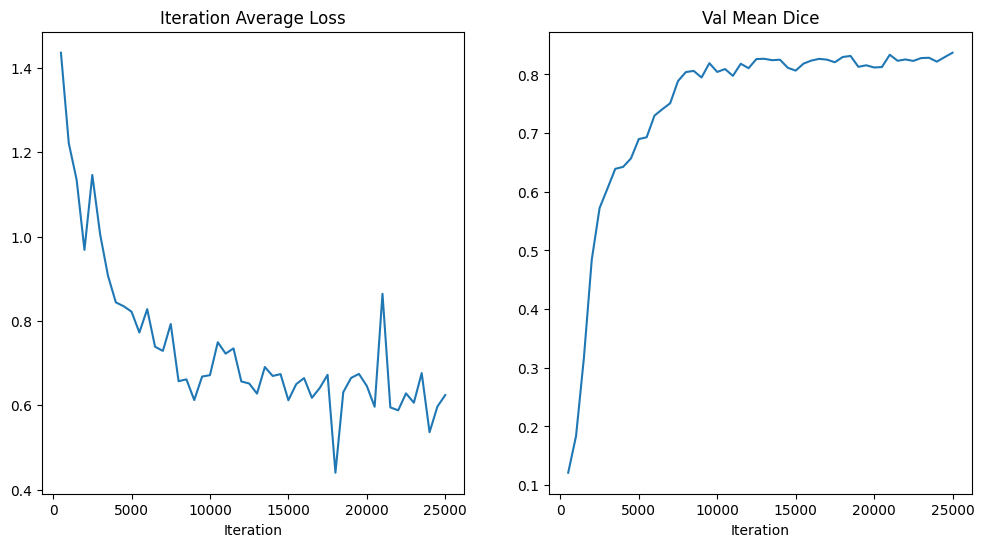

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [12]:
#fold2
torch.cuda.empty_cache()

In [5]:
#fold2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunet_onmiccai13_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.66243): 100%|█| 24/24 [00:23<00:00,  1.03it/
Training (47 / 25000 Steps) (loss=2.41597): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (71 / 25000 Steps) (loss=2.31849): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (95 / 25000 Steps) (loss=2.19436): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (119 / 25000 Steps) (loss=2.10125): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=1.90502): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=2.00578): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=1.83912): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=1.79985): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=1.72951): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=1.69598): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=1.68645): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.13072650134563446 Current Avg. Dice: 0.13072650134563446


Training (503 / 25000 Steps) (loss=1.30462): 100%|█| 24/24 [00:33<00:00,  1.40s/
Training (527 / 25000 Steps) (loss=1.38922): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=1.61625): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=1.36179): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (599 / 25000 Steps) (loss=1.21192): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=1.39986): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=1.30744): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (671 / 25000 Steps) (loss=1.49977): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (695 / 25000 Steps) (loss=1.20222): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=1.31331): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=1.28899): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=1.12144): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.24278761446475983 Current Avg. Dice: 0.24278761446475983


Training (1007 / 25000 Steps) (loss=1.47903): 100%|█| 24/24 [00:32<00:00,  1.37s
Training (1031 / 25000 Steps) (loss=1.26009): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1055 / 25000 Steps) (loss=1.24329): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=1.23791): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=1.09529): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1127 / 25000 Steps) (loss=1.23007): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=1.24364): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1175 / 25000 Steps) (loss=1.28653): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=1.19450): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1223 / 25000 Steps) (loss=1.23899): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1247 / 25000 Steps) (loss=1.07497): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1271 / 25000 Steps) (loss=1.10932): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3738377094268799 Current Avg. Dice: 0.3738377094268799


Training (1511 / 25000 Steps) (loss=1.11679): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (1535 / 25000 Steps) (loss=0.98777): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=1.07014): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1583 / 25000 Steps) (loss=1.12068): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=1.04195): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=1.09987): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1655 / 25000 Steps) (loss=1.05678): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1679 / 25000 Steps) (loss=0.93965): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=1.15050): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=1.03276): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=1.08402): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1775 / 25000 Steps) (loss=1.09212): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.48575225472450256 Current Avg. Dice: 0.48575225472450256


Training (2015 / 25000 Steps) (loss=0.89073): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (2039 / 25000 Steps) (loss=0.94141): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2063 / 25000 Steps) (loss=0.97156): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2087 / 25000 Steps) (loss=0.94674): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2111 / 25000 Steps) (loss=1.07191): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2135 / 25000 Steps) (loss=1.07420): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2159 / 25000 Steps) (loss=1.10454): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=1.40810): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2207 / 25000 Steps) (loss=0.87850): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2231 / 25000 Steps) (loss=1.34690): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2255 / 25000 Steps) (loss=0.92408): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2279 / 25000 Steps) (loss=0.85350): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5149192214012146 Current Avg. Dice: 0.5149192214012146


Training (2519 / 25000 Steps) (loss=0.92079): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (2543 / 25000 Steps) (loss=0.79694): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=0.85582): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2591 / 25000 Steps) (loss=0.90382): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=0.86524): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2639 / 25000 Steps) (loss=1.07214): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2663 / 25000 Steps) (loss=0.80957): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.87573): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.82663): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2735 / 25000 Steps) (loss=1.07420): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2759 / 25000 Steps) (loss=0.80182): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=1.18226): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5419965982437134 Current Avg. Dice: 0.5419965982437134


Training (3023 / 25000 Steps) (loss=1.02441): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (3047 / 25000 Steps) (loss=2.19574): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.92462): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.86807): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3119 / 25000 Steps) (loss=0.71824): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=0.85354): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=0.89661): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.91593): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3215 / 25000 Steps) (loss=0.81427): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3239 / 25000 Steps) (loss=0.87219): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3263 / 25000 Steps) (loss=0.74420): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=0.75121): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5716766119003296 Current Avg. Dice: 0.5716766119003296


Training (3503 / 25000 Steps) (loss=0.77119): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (3527 / 25000 Steps) (loss=0.84509): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3551 / 25000 Steps) (loss=0.91170): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3575 / 25000 Steps) (loss=0.78878): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.86600): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.69952): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=1.53088): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3671 / 25000 Steps) (loss=0.75259): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.91143): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=0.77448): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=0.77086): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=1.69918): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5716766119003296 Current Avg. Dice: 0.5477025508880615


Training (4007 / 25000 Steps) (loss=0.99978): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (4031 / 25000 Steps) (loss=0.85765): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4055 / 25000 Steps) (loss=0.71898): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.74152): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.80904): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=0.72845): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=0.73116): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=0.82788): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4199 / 25000 Steps) (loss=0.83254): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4223 / 25000 Steps) (loss=0.82452): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4247 / 25000 Steps) (loss=0.88207): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4271 / 25000 Steps) (loss=0.56362): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6106180548667908 Current Avg. Dice: 0.6106180548667908


Training (4511 / 25000 Steps) (loss=0.68864): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (4535 / 25000 Steps) (loss=0.67011): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4559 / 25000 Steps) (loss=0.79225): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.78164): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4607 / 25000 Steps) (loss=0.79424): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.82232): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=0.84902): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.67544): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4703 / 25000 Steps) (loss=0.82152): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4727 / 25000 Steps) (loss=0.73593): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4751 / 25000 Steps) (loss=0.81126): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4775 / 25000 Steps) (loss=0.99910): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6493628621101379 Current Avg. Dice: 0.6493628621101379


Training (5015 / 25000 Steps) (loss=0.67306): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (5039 / 25000 Steps) (loss=0.66944): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5063 / 25000 Steps) (loss=1.20490): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5087 / 25000 Steps) (loss=0.80813): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.98936): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.76166): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.81017): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5183 / 25000 Steps) (loss=0.67025): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5207 / 25000 Steps) (loss=0.80272): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=1.04930): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.79976): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5279 / 25000 Steps) (loss=0.93734): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6493628621101379 Current Avg. Dice: 0.6487133502960205


Training (5519 / 25000 Steps) (loss=1.80796): 100%|█| 24/24 [00:32<00:00,  1.37s
Training (5543 / 25000 Steps) (loss=0.58566): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5567 / 25000 Steps) (loss=0.73266): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5591 / 25000 Steps) (loss=0.79001): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5615 / 25000 Steps) (loss=0.70768): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5639 / 25000 Steps) (loss=0.63750): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5663 / 25000 Steps) (loss=0.79141): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5687 / 25000 Steps) (loss=0.70118): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.63655): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.83648): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5759 / 25000 Steps) (loss=0.78716): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5783 / 25000 Steps) (loss=0.62021): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7052648663520813 Current Avg. Dice: 0.7052648663520813


Training (6023 / 25000 Steps) (loss=0.54372): 100%|█| 24/24 [00:32<00:00,  1.37s
Training (6047 / 25000 Steps) (loss=0.74964): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6071 / 25000 Steps) (loss=0.64425): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.56893): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6119 / 25000 Steps) (loss=0.87809): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.77351): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6167 / 25000 Steps) (loss=0.69330): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6191 / 25000 Steps) (loss=0.53765): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6215 / 25000 Steps) (loss=0.76712): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6239 / 25000 Steps) (loss=0.55278): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.71303): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6287 / 25000 Steps) (loss=0.66477): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7134666442871094 Current Avg. Dice: 0.7134666442871094


Training (6503 / 25000 Steps) (loss=0.79072): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (6527 / 25000 Steps) (loss=0.65623): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.81878): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6575 / 25000 Steps) (loss=0.76139): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.59648): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6623 / 25000 Steps) (loss=0.79903): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=0.72011): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6671 / 25000 Steps) (loss=0.71145): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6695 / 25000 Steps) (loss=0.60809): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.50951): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6743 / 25000 Steps) (loss=0.96375): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.82348): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7274772524833679 Current Avg. Dice: 0.7274772524833679


Training (7007 / 25000 Steps) (loss=0.80149): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (7031 / 25000 Steps) (loss=0.74865): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.64710): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=0.67123): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=0.73093): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7127 / 25000 Steps) (loss=0.84340): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.88832): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.66794): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.57492): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7223 / 25000 Steps) (loss=0.66984): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7247 / 25000 Steps) (loss=0.70407): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.74118): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7274772524833679 Current Avg. Dice: 0.721086323261261


Training (7511 / 25000 Steps) (loss=0.79153): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (7535 / 25000 Steps) (loss=0.69813): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.64812): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.82507): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=0.72513): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=0.69317): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7655 / 25000 Steps) (loss=0.64381): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7679 / 25000 Steps) (loss=0.64156): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7703 / 25000 Steps) (loss=0.70046): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=0.81975): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7751 / 25000 Steps) (loss=0.75588): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.74705): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7274772524833679 Current Avg. Dice: 0.7083110809326172


Training (8015 / 25000 Steps) (loss=0.69938): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (8039 / 25000 Steps) (loss=0.72904): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8063 / 25000 Steps) (loss=0.75484): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.74127): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.73623): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.57819): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8159 / 25000 Steps) (loss=0.72819): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8183 / 25000 Steps) (loss=0.72594): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8207 / 25000 Steps) (loss=0.73042): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8231 / 25000 Steps) (loss=0.70227): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8255 / 25000 Steps) (loss=0.70135): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8279 / 25000 Steps) (loss=0.63211): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7274772524833679 Current Avg. Dice: 0.7057520747184753


Training (8519 / 25000 Steps) (loss=0.58432): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (8543 / 25000 Steps) (loss=0.73359): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8567 / 25000 Steps) (loss=0.65469): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.53138): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=0.52030): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.56011): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.74233): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8687 / 25000 Steps) (loss=0.64353): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8711 / 25000 Steps) (loss=0.60966): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8735 / 25000 Steps) (loss=0.91997): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8759 / 25000 Steps) (loss=0.73041): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.55265): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7274772524833679 Current Avg. Dice: 0.703794002532959


Training (9023 / 25000 Steps) (loss=0.74542): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (9047 / 25000 Steps) (loss=0.81012): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=0.78876): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9095 / 25000 Steps) (loss=0.79775): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.48778): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.63230): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.63330): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9191 / 25000 Steps) (loss=0.45970): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9215 / 25000 Steps) (loss=0.74350): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9239 / 25000 Steps) (loss=0.86687): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=0.67736): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9287 / 25000 Steps) (loss=0.80635): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7353012561798096 Current Avg. Dice: 0.7353012561798096


Training (9503 / 25000 Steps) (loss=0.64314): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (9527 / 25000 Steps) (loss=0.51723): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9551 / 25000 Steps) (loss=0.51052): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9575 / 25000 Steps) (loss=0.74047): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9599 / 25000 Steps) (loss=0.60244): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.83432): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9647 / 25000 Steps) (loss=0.59009): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9671 / 25000 Steps) (loss=0.56452): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9695 / 25000 Steps) (loss=0.66208): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9719 / 25000 Steps) (loss=1.02086): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=0.81781): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9767 / 25000 Steps) (loss=0.57932): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7353012561798096 Current Avg. Dice: 0.6970086097717285


Training (10007 / 25000 Steps) (loss=0.60365): 100%|█| 24/24 [00:32<00:00,  1.34
Training (10031 / 25000 Steps) (loss=0.73358): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10055 / 25000 Steps) (loss=0.60827): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10079 / 25000 Steps) (loss=0.69762): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10103 / 25000 Steps) (loss=0.65425): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=0.70987): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10151 / 25000 Steps) (loss=0.78999): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10175 / 25000 Steps) (loss=0.74132): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.71847): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10223 / 25000 Steps) (loss=0.59774): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10247 / 25000 Steps) (loss=0.81720): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10271 / 25000 Steps) (loss=0.69768): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7353012561798096 Current Avg. Dice: 0.7207086682319641


Training (10511 / 25000 Steps) (loss=0.72410): 100%|█| 24/24 [00:32<00:00,  1.34
Training (10535 / 25000 Steps) (loss=0.83130): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10559 / 25000 Steps) (loss=0.76319): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10583 / 25000 Steps) (loss=0.60278): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10607 / 25000 Steps) (loss=0.59161): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10631 / 25000 Steps) (loss=0.55335): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10655 / 25000 Steps) (loss=0.64420): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.63673): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10703 / 25000 Steps) (loss=0.76402): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10727 / 25000 Steps) (loss=0.62952): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10751 / 25000 Steps) (loss=0.59374): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.47612): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7353012561798096 Current Avg. Dice: 0.7266581058502197


Training (11015 / 25000 Steps) (loss=0.52950): 100%|█| 24/24 [00:32<00:00,  1.34
Training (11039 / 25000 Steps) (loss=0.64626): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11063 / 25000 Steps) (loss=0.60907): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11087 / 25000 Steps) (loss=0.67461): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11111 / 25000 Steps) (loss=0.76257): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.85039): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11159 / 25000 Steps) (loss=0.68713): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11183 / 25000 Steps) (loss=0.67986): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=0.45412): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11231 / 25000 Steps) (loss=0.69378): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11255 / 25000 Steps) (loss=0.41324): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11279 / 25000 Steps) (loss=0.49055): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7489821910858154


Training (11519 / 25000 Steps) (loss=0.62035): 100%|█| 24/24 [00:33<00:00,  1.38
Training (11543 / 25000 Steps) (loss=0.69908): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11567 / 25000 Steps) (loss=0.48687): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11591 / 25000 Steps) (loss=0.70106): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11615 / 25000 Steps) (loss=0.56587): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11639 / 25000 Steps) (loss=0.52271): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11663 / 25000 Steps) (loss=0.63279): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11687 / 25000 Steps) (loss=0.69396): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11711 / 25000 Steps) (loss=0.53361): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.57033): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11759 / 25000 Steps) (loss=0.50117): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11783 / 25000 Steps) (loss=0.84413): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.721303403377533


Training (12023 / 25000 Steps) (loss=0.81373): 100%|█| 24/24 [00:32<00:00,  1.36
Training (12047 / 25000 Steps) (loss=0.73172): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12071 / 25000 Steps) (loss=0.68539): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=0.67881): 100%|█| 24/24 [00:18<00:00,  1.27
Training (12119 / 25000 Steps) (loss=0.80116): 100%|█| 24/24 [00:18<00:00,  1.27
Training (12143 / 25000 Steps) (loss=0.81492): 100%|█| 24/24 [00:18<00:00,  1.27
Training (12167 / 25000 Steps) (loss=0.55545): 100%|█| 24/24 [00:18<00:00,  1.27
Training (12191 / 25000 Steps) (loss=0.62851): 100%|█| 24/24 [00:18<00:00,  1.27
Training (12215 / 25000 Steps) (loss=0.70006): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12239 / 25000 Steps) (loss=0.47387): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12263 / 25000 Steps) (loss=1.01273): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.61853): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7435710430145264


Training (12503 / 25000 Steps) (loss=0.44626): 100%|█| 24/24 [00:32<00:00,  1.34
Training (12527 / 25000 Steps) (loss=0.62419): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=0.49595): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12575 / 25000 Steps) (loss=0.61761): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12599 / 25000 Steps) (loss=0.49436): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12623 / 25000 Steps) (loss=0.77990): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.59906): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.56675): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12695 / 25000 Steps) (loss=0.62154): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.45832): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.65289): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12767 / 25000 Steps) (loss=0.55169): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7018983364105225


Training (13007 / 25000 Steps) (loss=0.67293): 100%|█| 24/24 [00:32<00:00,  1.34
Training (13031 / 25000 Steps) (loss=0.62389): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13055 / 25000 Steps) (loss=0.84525): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.52974): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13103 / 25000 Steps) (loss=0.69551): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13127 / 25000 Steps) (loss=0.55829): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13151 / 25000 Steps) (loss=0.56332): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13175 / 25000 Steps) (loss=0.79166): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.64617): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=0.69342): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13247 / 25000 Steps) (loss=0.65543): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.48455): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.71070796251297


Training (13511 / 25000 Steps) (loss=0.74025): 100%|█| 24/24 [00:32<00:00,  1.34
Training (13535 / 25000 Steps) (loss=0.40400): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=0.63618): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.77882): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.83016): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13631 / 25000 Steps) (loss=0.61725): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.65037): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13679 / 25000 Steps) (loss=0.73246): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.61646): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13727 / 25000 Steps) (loss=0.77861): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=0.80257): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=0.74324): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7455065846443176


Training (14015 / 25000 Steps) (loss=0.70728): 100%|█| 24/24 [00:32<00:00,  1.34
Training (14039 / 25000 Steps) (loss=0.68426): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.47068): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14087 / 25000 Steps) (loss=0.64693): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.68669): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14135 / 25000 Steps) (loss=0.48178): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14159 / 25000 Steps) (loss=0.68904): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14183 / 25000 Steps) (loss=0.81999): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.69961): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14231 / 25000 Steps) (loss=0.45923): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14255 / 25000 Steps) (loss=0.80976): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14279 / 25000 Steps) (loss=0.47122): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.6763631701469421


Training (14519 / 25000 Steps) (loss=0.51380): 100%|█| 24/24 [00:32<00:00,  1.34
Training (14543 / 25000 Steps) (loss=0.75130): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14567 / 25000 Steps) (loss=0.56926): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14591 / 25000 Steps) (loss=0.66321): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14615 / 25000 Steps) (loss=0.59910): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=0.67739): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14663 / 25000 Steps) (loss=0.71000): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14687 / 25000 Steps) (loss=0.69269): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14711 / 25000 Steps) (loss=0.62619): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14735 / 25000 Steps) (loss=0.56475): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14759 / 25000 Steps) (loss=0.35006): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14783 / 25000 Steps) (loss=0.74880): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.730104923248291


Training (15023 / 25000 Steps) (loss=0.50865): 100%|█| 24/24 [00:32<00:00,  1.34
Training (15047 / 25000 Steps) (loss=0.54569): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15071 / 25000 Steps) (loss=0.58214): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15095 / 25000 Steps) (loss=0.68947): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15119 / 25000 Steps) (loss=0.70754): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.78231): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.67252): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.85507): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.77604): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15239 / 25000 Steps) (loss=0.78750): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.64388): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15287 / 25000 Steps) (loss=0.59808): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7019510269165039


Training (15503 / 25000 Steps) (loss=0.68726): 100%|█| 24/24 [00:32<00:00,  1.34
Training (15527 / 25000 Steps) (loss=0.82054): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15551 / 25000 Steps) (loss=0.80566): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15575 / 25000 Steps) (loss=0.70692): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15599 / 25000 Steps) (loss=0.60250): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15623 / 25000 Steps) (loss=0.70407): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.71044): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15671 / 25000 Steps) (loss=0.61823): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15695 / 25000 Steps) (loss=0.43344): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15719 / 25000 Steps) (loss=0.62131): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15743 / 25000 Steps) (loss=0.60724): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15767 / 25000 Steps) (loss=0.56962): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7176867127418518


Training (16007 / 25000 Steps) (loss=0.61584): 100%|█| 24/24 [00:32<00:00,  1.36
Training (16031 / 25000 Steps) (loss=0.71495): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16055 / 25000 Steps) (loss=0.69106): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16079 / 25000 Steps) (loss=0.57842): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16103 / 25000 Steps) (loss=0.63882): 100%|█| 24/24 [00:18<00:00,  1.27
Training (16127 / 25000 Steps) (loss=0.65325): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16151 / 25000 Steps) (loss=0.52817): 100%|█| 24/24 [00:18<00:00,  1.27
Training (16175 / 25000 Steps) (loss=0.87373): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16199 / 25000 Steps) (loss=0.64417): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16223 / 25000 Steps) (loss=0.88813): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16247 / 25000 Steps) (loss=0.61933): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16271 / 25000 Steps) (loss=0.61606): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7340075373649597


Training (16511 / 25000 Steps) (loss=0.45675): 100%|█| 24/24 [00:32<00:00,  1.36
Training (16535 / 25000 Steps) (loss=0.38082): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.64991): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16583 / 25000 Steps) (loss=0.72959): 100%|█| 24/24 [00:18<00:00,  1.27
Training (16607 / 25000 Steps) (loss=0.58734): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=0.49001): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.50991): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.38050): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16703 / 25000 Steps) (loss=0.52715): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.78420): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.59603): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16775 / 25000 Steps) (loss=0.42787): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7155157923698425


Training (17015 / 25000 Steps) (loss=0.58859): 100%|█| 24/24 [00:32<00:00,  1.36
Training (17039 / 25000 Steps) (loss=0.76875): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17063 / 25000 Steps) (loss=0.58048): 100%|█| 24/24 [00:18<00:00,  1.27
Training (17087 / 25000 Steps) (loss=0.52981): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17111 / 25000 Steps) (loss=0.48699): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17135 / 25000 Steps) (loss=0.37066): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17159 / 25000 Steps) (loss=0.46518): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17183 / 25000 Steps) (loss=0.66468): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17207 / 25000 Steps) (loss=0.54749): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17231 / 25000 Steps) (loss=0.56811): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17255 / 25000 Steps) (loss=0.66969): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.41105): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7260692119598389


Training (17519 / 25000 Steps) (loss=0.55875): 100%|█| 24/24 [00:32<00:00,  1.34
Training (17543 / 25000 Steps) (loss=0.43623): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17567 / 25000 Steps) (loss=0.62705): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17591 / 25000 Steps) (loss=0.72477): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17615 / 25000 Steps) (loss=0.70077): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.57958): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17663 / 25000 Steps) (loss=0.75304): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17687 / 25000 Steps) (loss=0.30714): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17711 / 25000 Steps) (loss=0.51936): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17735 / 25000 Steps) (loss=0.51162): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17759 / 25000 Steps) (loss=0.65960): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17783 / 25000 Steps) (loss=0.75636): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7389773726463318


Training (18023 / 25000 Steps) (loss=0.75113): 100%|█| 24/24 [00:32<00:00,  1.34
Training (18047 / 25000 Steps) (loss=0.52157): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18071 / 25000 Steps) (loss=0.63036): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.71946): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18119 / 25000 Steps) (loss=0.52432): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18143 / 25000 Steps) (loss=0.64220): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18167 / 25000 Steps) (loss=0.65262): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18191 / 25000 Steps) (loss=0.73791): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18215 / 25000 Steps) (loss=0.67666): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.66299): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18263 / 25000 Steps) (loss=0.72747): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18287 / 25000 Steps) (loss=0.46466): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7400593161582947


Training (18503 / 25000 Steps) (loss=0.57627): 100%|█| 24/24 [00:32<00:00,  1.34
Training (18527 / 25000 Steps) (loss=0.54966): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18551 / 25000 Steps) (loss=0.60798): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18575 / 25000 Steps) (loss=0.47942): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18599 / 25000 Steps) (loss=0.80329): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18623 / 25000 Steps) (loss=0.44689): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18647 / 25000 Steps) (loss=0.50534): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18671 / 25000 Steps) (loss=0.41060): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18695 / 25000 Steps) (loss=0.71790): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18719 / 25000 Steps) (loss=0.63602): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=0.46733): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18767 / 25000 Steps) (loss=0.47467): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7489821910858154 Current Avg. Dice: 0.7434489727020264


Training (19007 / 25000 Steps) (loss=0.71867): 100%|█| 24/24 [00:32<00:00,  1.34
Training (19031 / 25000 Steps) (loss=0.99503): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19055 / 25000 Steps) (loss=0.72795): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19079 / 25000 Steps) (loss=0.67950): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.64028): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19127 / 25000 Steps) (loss=0.54135): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19151 / 25000 Steps) (loss=0.76132): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19175 / 25000 Steps) (loss=0.70952): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.59807): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19223 / 25000 Steps) (loss=0.76612): 100%|█| 24/24 [00:18<00:00,  1.27
Training (19247 / 25000 Steps) (loss=0.66058): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19271 / 25000 Steps) (loss=0.59480): 100%|█| 24/24 [00:18<00:00,  1.27
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7618703246116638


Training (19511 / 25000 Steps) (loss=0.44793): 100%|█| 24/24 [00:32<00:00,  1.37
Training (19535 / 25000 Steps) (loss=0.48563): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19559 / 25000 Steps) (loss=0.57398): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19583 / 25000 Steps) (loss=0.44495): 100%|█| 24/24 [00:18<00:00,  1.27
Training (19607 / 25000 Steps) (loss=0.75002): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19631 / 25000 Steps) (loss=0.56534): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19655 / 25000 Steps) (loss=0.61821): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19679 / 25000 Steps) (loss=0.74271): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19703 / 25000 Steps) (loss=0.74304): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19727 / 25000 Steps) (loss=0.73133): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19751 / 25000 Steps) (loss=0.39191): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19775 / 25000 Steps) (loss=0.39327): 100%|█| 24/24 [00:18<00:00,  1.27
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7381365895271301


Training (20015 / 25000 Steps) (loss=0.50697): 100%|█| 24/24 [00:32<00:00,  1.37
Training (20039 / 25000 Steps) (loss=0.74807): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20063 / 25000 Steps) (loss=0.71483): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20087 / 25000 Steps) (loss=0.74074): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20111 / 25000 Steps) (loss=0.73981): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20135 / 25000 Steps) (loss=0.83359): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20159 / 25000 Steps) (loss=0.78716): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.68433): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.58287): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20231 / 25000 Steps) (loss=0.52514): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20255 / 25000 Steps) (loss=0.70042): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20279 / 25000 Steps) (loss=0.72758): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7281939387321472


Training (20519 / 25000 Steps) (loss=0.66744): 100%|█| 24/24 [00:32<00:00,  1.34
Training (20543 / 25000 Steps) (loss=0.58484): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20567 / 25000 Steps) (loss=0.77523): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20591 / 25000 Steps) (loss=0.49512): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.44234): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.64190): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.52583): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20687 / 25000 Steps) (loss=0.65467): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20711 / 25000 Steps) (loss=0.47270): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.57648): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=0.52934): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.85633): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7324537634849548


Training (21023 / 25000 Steps) (loss=0.82776): 100%|█| 24/24 [00:32<00:00,  1.34
Training (21047 / 25000 Steps) (loss=0.53268): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21071 / 25000 Steps) (loss=0.68011): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=0.47587): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.75557): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21143 / 25000 Steps) (loss=0.49747): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21167 / 25000 Steps) (loss=0.47364): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.57837): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.44663): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=0.60368): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21263 / 25000 Steps) (loss=0.54699): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.42568): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7039687037467957


Training (21503 / 25000 Steps) (loss=0.54557): 100%|█| 24/24 [00:32<00:00,  1.36
Training (21527 / 25000 Steps) (loss=0.72452): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21551 / 25000 Steps) (loss=0.64972): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21575 / 25000 Steps) (loss=0.78044): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=0.60275): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21623 / 25000 Steps) (loss=0.60939): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21647 / 25000 Steps) (loss=0.63021): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21671 / 25000 Steps) (loss=0.52752): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21695 / 25000 Steps) (loss=0.69580): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21719 / 25000 Steps) (loss=0.45676): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21743 / 25000 Steps) (loss=0.67836): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21767 / 25000 Steps) (loss=0.49934): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7251855731010437


Training (22007 / 25000 Steps) (loss=0.74556): 100%|█| 24/24 [00:32<00:00,  1.36
Training (22031 / 25000 Steps) (loss=0.70531): 100%|█| 24/24 [00:18<00:00,  1.27
Training (22055 / 25000 Steps) (loss=0.70187): 100%|█| 24/24 [00:18<00:00,  1.27
Training (22079 / 25000 Steps) (loss=0.78450): 100%|█| 24/24 [00:18<00:00,  1.27
Training (22103 / 25000 Steps) (loss=0.64254): 100%|█| 24/24 [00:18<00:00,  1.27
Training (22127 / 25000 Steps) (loss=0.64278): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22151 / 25000 Steps) (loss=0.59626): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22175 / 25000 Steps) (loss=0.42937): 100%|█| 24/24 [00:18<00:00,  1.27
Training (22199 / 25000 Steps) (loss=0.63097): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.81344): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22247 / 25000 Steps) (loss=0.76040): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.53252): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7289824485778809


Training (22511 / 25000 Steps) (loss=0.78195): 100%|█| 24/24 [00:32<00:00,  1.36
Training (22535 / 25000 Steps) (loss=0.61947): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22559 / 25000 Steps) (loss=0.80181): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=0.68331): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22607 / 25000 Steps) (loss=0.55287): 100%|█| 24/24 [00:18<00:00,  1.27
Training (22631 / 25000 Steps) (loss=0.55468): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22655 / 25000 Steps) (loss=0.71566): 100%|█| 24/24 [00:18<00:00,  1.27
Training (22679 / 25000 Steps) (loss=0.63137): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.69230): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22727 / 25000 Steps) (loss=0.49110): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22751 / 25000 Steps) (loss=0.53191): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22775 / 25000 Steps) (loss=0.57066): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7262377142906189


Training (23015 / 25000 Steps) (loss=0.57691): 100%|█| 24/24 [00:32<00:00,  1.36
Training (23039 / 25000 Steps) (loss=0.69976): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23063 / 25000 Steps) (loss=0.56399): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23087 / 25000 Steps) (loss=0.37054): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23111 / 25000 Steps) (loss=0.72531): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23135 / 25000 Steps) (loss=0.53533): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23159 / 25000 Steps) (loss=0.79976): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23183 / 25000 Steps) (loss=0.46423): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23207 / 25000 Steps) (loss=0.51250): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23231 / 25000 Steps) (loss=0.66861): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23255 / 25000 Steps) (loss=0.63513): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=0.72356): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7348101735115051


Training (23519 / 25000 Steps) (loss=0.49091): 100%|█| 24/24 [00:32<00:00,  1.35
Training (23543 / 25000 Steps) (loss=0.38134): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23567 / 25000 Steps) (loss=0.68898): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23591 / 25000 Steps) (loss=0.47230): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23615 / 25000 Steps) (loss=0.49041): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23639 / 25000 Steps) (loss=0.69430): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23663 / 25000 Steps) (loss=0.65247): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23687 / 25000 Steps) (loss=0.56553): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23711 / 25000 Steps) (loss=0.44757): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23735 / 25000 Steps) (loss=0.38883): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23759 / 25000 Steps) (loss=0.51345): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.51775): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7618703246116638 Current Avg. Dice: 0.7295460104942322


Training (24023 / 25000 Steps) (loss=0.78874): 100%|█| 24/24 [00:32<00:00,  1.35
Training (24047 / 25000 Steps) (loss=0.81744): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24071 / 25000 Steps) (loss=0.85635): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24095 / 25000 Steps) (loss=0.73297): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24119 / 25000 Steps) (loss=0.52273): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24143 / 25000 Steps) (loss=0.57997): 100%|█| 24/24 [00:19<00:00,  1.26
Training (24167 / 25000 Steps) (loss=0.71166): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24191 / 25000 Steps) (loss=0.71064): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24215 / 25000 Steps) (loss=0.63759): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24239 / 25000 Steps) (loss=0.58598): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24263 / 25000 Steps) (loss=0.49569): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.68676): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7624098658561707 Current Avg. Dice: 0.7624098658561707


Training (24503 / 25000 Steps) (loss=0.61757): 100%|█| 24/24 [00:32<00:00,  1.36
Training (24527 / 25000 Steps) (loss=0.61185): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24551 / 25000 Steps) (loss=0.63172): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24575 / 25000 Steps) (loss=0.72649): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24599 / 25000 Steps) (loss=0.64969): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24623 / 25000 Steps) (loss=0.78034): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=0.51447): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.77304): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24695 / 25000 Steps) (loss=0.90851): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.59132): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24743 / 25000 Steps) (loss=0.64304): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24767 / 25000 Steps) (loss=0.61986): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7624098658561707 Current Avg. Dice: 0.7427170872688293


Training (25007 / 25000 Steps) (loss=0.48424): 100%|█| 24/24 [00:32<00:00,  1.35


In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7624 at iteration: 24500


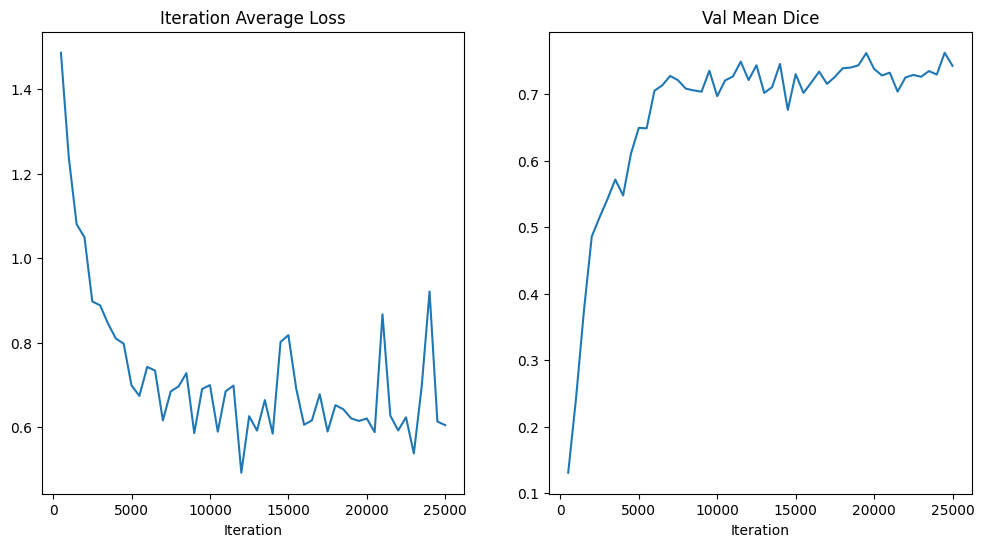

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
#fold3
torch.cuda.empty_cache()

In [5]:
#fold3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunet_onmiccai13_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.81831): 100%|█| 24/24 [00:23<00:00,  1.03it/
Training (47 / 25000 Steps) (loss=2.59080): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (71 / 25000 Steps) (loss=2.45378): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (95 / 25000 Steps) (loss=2.26295): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (119 / 25000 Steps) (loss=2.14854): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=1.97820): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=2.00281): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=1.99769): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (215 / 25000 Steps) (loss=1.91617): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=1.90882): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=1.77707): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=1.69144): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.12130563706159592 Current Avg. Dice: 0.12130563706159592


Training (503 / 25000 Steps) (loss=1.60260): 100%|█| 24/24 [00:33<00:00,  1.40s/
Training (527 / 25000 Steps) (loss=1.39626): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=1.42147): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=1.41445): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (599 / 25000 Steps) (loss=1.37211): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=1.39509): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=1.71067): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (671 / 25000 Steps) (loss=1.22080): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=1.33503): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=1.28155): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=1.33669): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=1.51272): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.17395292222499847 Current Avg. Dice: 0.17395292222499847


Training (1007 / 25000 Steps) (loss=1.29865): 100%|█| 24/24 [00:32<00:00,  1.37s
Training (1031 / 25000 Steps) (loss=1.21840): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1055 / 25000 Steps) (loss=1.24793): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=1.20190): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1103 / 25000 Steps) (loss=1.16971): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1127 / 25000 Steps) (loss=1.15060): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=1.16218): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=1.06068): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=1.12911): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1223 / 25000 Steps) (loss=1.29508): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1247 / 25000 Steps) (loss=1.27156): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1271 / 25000 Steps) (loss=1.11287): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3808271884918213 Current Avg. Dice: 0.3808271884918213


Training (1511 / 25000 Steps) (loss=1.15370): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (1535 / 25000 Steps) (loss=1.10122): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=0.95772): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1583 / 25000 Steps) (loss=1.04426): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=1.00569): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1631 / 25000 Steps) (loss=1.01404): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1655 / 25000 Steps) (loss=1.11843): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (1679 / 25000 Steps) (loss=0.93861): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=1.08245): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1727 / 25000 Steps) (loss=0.92844): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1751 / 25000 Steps) (loss=1.04891): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1775 / 25000 Steps) (loss=1.11393): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4448869228363037 Current Avg. Dice: 0.4448869228363037


Training (2015 / 25000 Steps) (loss=0.90544): 100%|█| 24/24 [00:32<00:00,  1.37s
Training (2039 / 25000 Steps) (loss=1.11007): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2063 / 25000 Steps) (loss=1.00210): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2087 / 25000 Steps) (loss=0.83909): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2111 / 25000 Steps) (loss=0.98652): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2135 / 25000 Steps) (loss=0.79966): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.99752): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=1.02804): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=0.81635): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2231 / 25000 Steps) (loss=0.95104): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2255 / 25000 Steps) (loss=0.90171): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2279 / 25000 Steps) (loss=0.92198): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4540041983127594 Current Avg. Dice: 0.4540041983127594


Training (2519 / 25000 Steps) (loss=0.77029): 100%|█| 24/24 [00:32<00:00,  1.37s
Training (2543 / 25000 Steps) (loss=0.91762): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=0.93414): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2591 / 25000 Steps) (loss=0.97161): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=0.86619): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2639 / 25000 Steps) (loss=0.93480): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2663 / 25000 Steps) (loss=0.75130): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.95505): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.86324): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2735 / 25000 Steps) (loss=0.87528): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2759 / 25000 Steps) (loss=0.89336): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.90016): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5108012557029724 Current Avg. Dice: 0.5108012557029724


Training (3023 / 25000 Steps) (loss=0.74912): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (3047 / 25000 Steps) (loss=0.85595): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3071 / 25000 Steps) (loss=0.82853): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3095 / 25000 Steps) (loss=0.81860): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3119 / 25000 Steps) (loss=0.72382): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3143 / 25000 Steps) (loss=0.81674): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=0.77705): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.86000): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3215 / 25000 Steps) (loss=0.87628): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3239 / 25000 Steps) (loss=0.75357): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.73546): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=0.90667): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5277339816093445 Current Avg. Dice: 0.5277339816093445


Training (3503 / 25000 Steps) (loss=0.88006): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (3527 / 25000 Steps) (loss=0.91526): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3551 / 25000 Steps) (loss=0.72308): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3575 / 25000 Steps) (loss=0.81945): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.85605): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3623 / 25000 Steps) (loss=0.78715): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=1.02202): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3671 / 25000 Steps) (loss=0.78167): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.86097): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3719 / 25000 Steps) (loss=0.73602): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=0.74271): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3767 / 25000 Steps) (loss=0.82843): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5342182517051697 Current Avg. Dice: 0.5342182517051697


Training (4007 / 25000 Steps) (loss=0.85621): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (4031 / 25000 Steps) (loss=0.88261): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4055 / 25000 Steps) (loss=1.07837): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.94098): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4103 / 25000 Steps) (loss=0.75159): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=0.89241): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=0.90570): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4175 / 25000 Steps) (loss=0.72315): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4199 / 25000 Steps) (loss=0.62410): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=0.83410): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4247 / 25000 Steps) (loss=0.70770): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4271 / 25000 Steps) (loss=0.84630): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5882356762886047 Current Avg. Dice: 0.5882356762886047


Training (4511 / 25000 Steps) (loss=0.73255): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (4535 / 25000 Steps) (loss=0.83212): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=0.96103): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4583 / 25000 Steps) (loss=0.92647): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4607 / 25000 Steps) (loss=0.88117): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4631 / 25000 Steps) (loss=0.91262): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4655 / 25000 Steps) (loss=0.71382): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.80489): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4703 / 25000 Steps) (loss=0.82964): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4727 / 25000 Steps) (loss=0.72224): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4751 / 25000 Steps) (loss=0.82930): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4775 / 25000 Steps) (loss=0.84079): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.600979208946228 Current Avg. Dice: 0.600979208946228


Training (5015 / 25000 Steps) (loss=0.69821): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (5039 / 25000 Steps) (loss=0.71095): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5063 / 25000 Steps) (loss=0.69349): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5087 / 25000 Steps) (loss=0.69781): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5111 / 25000 Steps) (loss=0.82631): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.76546): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.62119): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5183 / 25000 Steps) (loss=0.94940): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5207 / 25000 Steps) (loss=0.79434): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=0.83772): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.63207): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5279 / 25000 Steps) (loss=0.80984): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6384703516960144 Current Avg. Dice: 0.6384703516960144


Training (5519 / 25000 Steps) (loss=0.75242): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (5543 / 25000 Steps) (loss=0.76425): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.81879): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.75817): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5615 / 25000 Steps) (loss=0.68294): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5639 / 25000 Steps) (loss=0.67693): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=0.77004): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5687 / 25000 Steps) (loss=0.54501): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.78923): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.69114): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5759 / 25000 Steps) (loss=0.43165): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.72002): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6513612866401672 Current Avg. Dice: 0.6513612866401672


Training (6023 / 25000 Steps) (loss=0.69548): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (6047 / 25000 Steps) (loss=0.91555): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6071 / 25000 Steps) (loss=0.60964): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.70211): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6119 / 25000 Steps) (loss=0.70632): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.49150): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6167 / 25000 Steps) (loss=0.65564): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6191 / 25000 Steps) (loss=0.67138): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6215 / 25000 Steps) (loss=0.71231): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.90557): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.62664): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.50881): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6513612866401672 Current Avg. Dice: 0.6407806277275085


Training (6503 / 25000 Steps) (loss=0.74899): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (6527 / 25000 Steps) (loss=0.71615): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.67634): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6575 / 25000 Steps) (loss=0.78223): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6599 / 25000 Steps) (loss=0.66786): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6623 / 25000 Steps) (loss=0.75436): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=0.87949): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6671 / 25000 Steps) (loss=0.74508): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6695 / 25000 Steps) (loss=0.51912): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6719 / 25000 Steps) (loss=0.71517): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6743 / 25000 Steps) (loss=0.75753): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6767 / 25000 Steps) (loss=0.74134): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6664486527442932 Current Avg. Dice: 0.6664486527442932


Training (7007 / 25000 Steps) (loss=0.65834): 100%|█| 24/24 [00:32<00:00,  1.37s
Training (7031 / 25000 Steps) (loss=0.85819): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.61871): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7079 / 25000 Steps) (loss=0.78022): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=0.50639): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7127 / 25000 Steps) (loss=0.50964): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.72707): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7175 / 25000 Steps) (loss=0.52432): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7199 / 25000 Steps) (loss=0.69977): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7223 / 25000 Steps) (loss=0.73551): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7247 / 25000 Steps) (loss=0.89674): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.70105): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6664486527442932 Current Avg. Dice: 0.6629253029823303


Training (7511 / 25000 Steps) (loss=0.80558): 100%|█| 24/24 [00:32<00:00,  1.36s
Training (7535 / 25000 Steps) (loss=0.66723): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7559 / 25000 Steps) (loss=0.56740): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.64451): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=0.50989): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=0.52010): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7655 / 25000 Steps) (loss=0.65392): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.44322): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7703 / 25000 Steps) (loss=0.67175): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=0.75161): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7751 / 25000 Steps) (loss=0.53073): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.68462): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6664486527442932 Current Avg. Dice: 0.663249671459198


Training (8015 / 25000 Steps) (loss=0.67980): 100%|█| 24/24 [00:32<00:00,  1.37s
Training (8039 / 25000 Steps) (loss=0.68868): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (8063 / 25000 Steps) (loss=0.66788): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.81624): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (8111 / 25000 Steps) (loss=0.80673): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.66272): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (8159 / 25000 Steps) (loss=0.78208): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8183 / 25000 Steps) (loss=0.62642): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8207 / 25000 Steps) (loss=0.44032): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8231 / 25000 Steps) (loss=0.47997): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8255 / 25000 Steps) (loss=0.78103): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8279 / 25000 Steps) (loss=0.74136): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.672152042388916 Current Avg. Dice: 0.672152042388916


Training (8519 / 25000 Steps) (loss=0.56585): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (8543 / 25000 Steps) (loss=0.81196): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8567 / 25000 Steps) (loss=0.69898): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.76757): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8615 / 25000 Steps) (loss=0.65416): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.62224): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.73568): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8687 / 25000 Steps) (loss=0.64634): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8711 / 25000 Steps) (loss=0.71796): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8735 / 25000 Steps) (loss=0.52893): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8759 / 25000 Steps) (loss=0.75325): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.57188): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.683465301990509 Current Avg. Dice: 0.683465301990509


Training (9023 / 25000 Steps) (loss=0.66998): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (9047 / 25000 Steps) (loss=0.62401): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9071 / 25000 Steps) (loss=0.61614): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=0.70105): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.63024): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.59251): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9167 / 25000 Steps) (loss=0.58204): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9191 / 25000 Steps) (loss=0.56383): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9215 / 25000 Steps) (loss=0.65826): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9239 / 25000 Steps) (loss=0.78946): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9263 / 25000 Steps) (loss=0.58264): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9287 / 25000 Steps) (loss=0.53839): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.683465301990509 Current Avg. Dice: 0.6712627410888672


Training (9503 / 25000 Steps) (loss=0.87758): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (9527 / 25000 Steps) (loss=0.47458): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9551 / 25000 Steps) (loss=0.75727): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9575 / 25000 Steps) (loss=0.56227): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9599 / 25000 Steps) (loss=0.87322): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.52522): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9647 / 25000 Steps) (loss=0.57863): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9671 / 25000 Steps) (loss=0.56256): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9695 / 25000 Steps) (loss=0.65903): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9719 / 25000 Steps) (loss=0.43241): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=0.72251): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9767 / 25000 Steps) (loss=0.72779): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.683465301990509 Current Avg. Dice: 0.6608532071113586


Training (10007 / 25000 Steps) (loss=0.59622): 100%|█| 24/24 [00:32<00:00,  1.34
Training (10031 / 25000 Steps) (loss=0.79078): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10055 / 25000 Steps) (loss=0.78536): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10079 / 25000 Steps) (loss=0.66072): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10103 / 25000 Steps) (loss=0.62880): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=0.64874): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10151 / 25000 Steps) (loss=0.43471): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10175 / 25000 Steps) (loss=0.72985): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.73282): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10223 / 25000 Steps) (loss=0.55946): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10247 / 25000 Steps) (loss=0.42382): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10271 / 25000 Steps) (loss=0.73423): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6879547238349915 Current Avg. Dice: 0.6879547238349915


Training (10511 / 25000 Steps) (loss=0.66802): 100%|█| 24/24 [00:32<00:00,  1.35
Training (10535 / 25000 Steps) (loss=0.67786): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10559 / 25000 Steps) (loss=0.55644): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10583 / 25000 Steps) (loss=0.83812): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10607 / 25000 Steps) (loss=0.45481): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10631 / 25000 Steps) (loss=0.64883): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10655 / 25000 Steps) (loss=0.66857): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.56471): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10703 / 25000 Steps) (loss=0.59639): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10727 / 25000 Steps) (loss=0.43687): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10751 / 25000 Steps) (loss=0.72980): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.83540): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6917670369148254 Current Avg. Dice: 0.6917670369148254


Training (11015 / 25000 Steps) (loss=0.66819): 100%|█| 24/24 [00:32<00:00,  1.35
Training (11039 / 25000 Steps) (loss=0.79927): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.45596): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11087 / 25000 Steps) (loss=0.38798): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11111 / 25000 Steps) (loss=0.72442): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.47061): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11159 / 25000 Steps) (loss=0.75876): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11183 / 25000 Steps) (loss=0.82646): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=0.74111): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11231 / 25000 Steps) (loss=0.64120): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11255 / 25000 Steps) (loss=0.62074): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.68554): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6917670369148254 Current Avg. Dice: 0.6827308535575867


Training (11519 / 25000 Steps) (loss=0.59750): 100%|█| 24/24 [00:32<00:00,  1.34
Training (11543 / 25000 Steps) (loss=0.55486): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11567 / 25000 Steps) (loss=0.60349): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11591 / 25000 Steps) (loss=0.69179): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11615 / 25000 Steps) (loss=0.82315): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11639 / 25000 Steps) (loss=0.79846): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11663 / 25000 Steps) (loss=0.42748): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11687 / 25000 Steps) (loss=0.80693): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11711 / 25000 Steps) (loss=0.57278): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.65852): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11759 / 25000 Steps) (loss=0.47564): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11783 / 25000 Steps) (loss=0.71208): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6982512474060059 Current Avg. Dice: 0.6982512474060059


Training (12023 / 25000 Steps) (loss=0.66020): 100%|█| 24/24 [00:32<00:00,  1.35
Training (12047 / 25000 Steps) (loss=0.53699): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12071 / 25000 Steps) (loss=0.68176): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=0.66765): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12119 / 25000 Steps) (loss=0.54930): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12143 / 25000 Steps) (loss=0.69652): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.77752): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12191 / 25000 Steps) (loss=0.74621): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12215 / 25000 Steps) (loss=0.49042): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12239 / 25000 Steps) (loss=0.59229): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12263 / 25000 Steps) (loss=0.43370): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.60537): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6982512474060059 Current Avg. Dice: 0.6628010869026184


Training (12503 / 25000 Steps) (loss=0.63922): 100%|█| 24/24 [00:32<00:00,  1.34
Training (12527 / 25000 Steps) (loss=0.62992): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=0.51984): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12575 / 25000 Steps) (loss=0.48736): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12599 / 25000 Steps) (loss=0.43574): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12623 / 25000 Steps) (loss=0.62412): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.64275): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.58590): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12695 / 25000 Steps) (loss=0.69869): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12719 / 25000 Steps) (loss=0.62314): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.71275): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12767 / 25000 Steps) (loss=0.72964): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6982512474060059 Current Avg. Dice: 0.6845553517341614


Training (13007 / 25000 Steps) (loss=0.54170): 100%|█| 24/24 [00:32<00:00,  1.34
Training (13031 / 25000 Steps) (loss=0.52066): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13055 / 25000 Steps) (loss=0.56603): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.57056): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13103 / 25000 Steps) (loss=0.74583): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13127 / 25000 Steps) (loss=0.41236): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13151 / 25000 Steps) (loss=0.56475): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13175 / 25000 Steps) (loss=0.66179): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13199 / 25000 Steps) (loss=0.56570): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=0.68256): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13247 / 25000 Steps) (loss=0.40686): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.37284): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6982512474060059 Current Avg. Dice: 0.6769628524780273


Training (13511 / 25000 Steps) (loss=0.74611): 100%|█| 24/24 [00:32<00:00,  1.34
Training (13535 / 25000 Steps) (loss=0.82796): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=0.52879): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.79528): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.47580): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13631 / 25000 Steps) (loss=0.82704): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.51949): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13679 / 25000 Steps) (loss=0.75815): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.74305): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13727 / 25000 Steps) (loss=0.54650): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13751 / 25000 Steps) (loss=0.53523): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=0.53272): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6982512474060059 Current Avg. Dice: 0.6921170353889465


Training (14015 / 25000 Steps) (loss=0.75058): 100%|█| 24/24 [00:32<00:00,  1.34
Training (14039 / 25000 Steps) (loss=0.63142): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.50613): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14087 / 25000 Steps) (loss=0.75476): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.56796): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14135 / 25000 Steps) (loss=0.59640): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14159 / 25000 Steps) (loss=0.58508): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14183 / 25000 Steps) (loss=0.58606): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.56260): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14231 / 25000 Steps) (loss=0.64560): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14255 / 25000 Steps) (loss=0.57160): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14279 / 25000 Steps) (loss=0.57182): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6982512474060059 Current Avg. Dice: 0.6926615834236145


Training (14519 / 25000 Steps) (loss=0.67757): 100%|█| 24/24 [00:32<00:00,  1.34
Training (14543 / 25000 Steps) (loss=0.74329): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14567 / 25000 Steps) (loss=0.62063): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14591 / 25000 Steps) (loss=0.69727): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14615 / 25000 Steps) (loss=0.68640): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=0.77658): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14663 / 25000 Steps) (loss=0.69999): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14687 / 25000 Steps) (loss=0.64819): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14711 / 25000 Steps) (loss=0.51767): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14735 / 25000 Steps) (loss=0.65491): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14759 / 25000 Steps) (loss=0.74582): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14783 / 25000 Steps) (loss=0.72187): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6982512474060059 Current Avg. Dice: 0.6825621128082275


Training (15023 / 25000 Steps) (loss=0.68695): 100%|█| 24/24 [00:32<00:00,  1.36
Training (15047 / 25000 Steps) (loss=0.53412): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15071 / 25000 Steps) (loss=0.59007): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15095 / 25000 Steps) (loss=0.78222): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15119 / 25000 Steps) (loss=0.62693): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.46847): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.65546): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.30545): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.54882): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15239 / 25000 Steps) (loss=0.62620): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.69631): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15287 / 25000 Steps) (loss=0.43635): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.700380802154541 Current Avg. Dice: 0.700380802154541


Training (15503 / 25000 Steps) (loss=0.51148): 100%|█| 24/24 [00:32<00:00,  1.37
Training (15527 / 25000 Steps) (loss=0.65219): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15551 / 25000 Steps) (loss=0.57356): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15575 / 25000 Steps) (loss=0.75301): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15599 / 25000 Steps) (loss=0.40746): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15623 / 25000 Steps) (loss=0.53861): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.55619): 100%|█| 24/24 [00:18<00:00,  1.27
Training (15671 / 25000 Steps) (loss=0.61333): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15695 / 25000 Steps) (loss=0.77975): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15719 / 25000 Steps) (loss=0.60804): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15743 / 25000 Steps) (loss=0.52600): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15767 / 25000 Steps) (loss=0.54202): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.700380802154541 Current Avg. Dice: 0.6963222026824951


Training (16007 / 25000 Steps) (loss=0.62848): 100%|█| 24/24 [00:32<00:00,  1.34
Training (16031 / 25000 Steps) (loss=0.71950): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16055 / 25000 Steps) (loss=0.65237): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16079 / 25000 Steps) (loss=0.70180): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16103 / 25000 Steps) (loss=0.66220): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16127 / 25000 Steps) (loss=0.56558): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16151 / 25000 Steps) (loss=0.42198): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16175 / 25000 Steps) (loss=0.32348): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16199 / 25000 Steps) (loss=0.47301): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16223 / 25000 Steps) (loss=0.65699): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16247 / 25000 Steps) (loss=0.47952): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16271 / 25000 Steps) (loss=0.60497): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.700380802154541 Current Avg. Dice: 0.6832728385925293


Training (16511 / 25000 Steps) (loss=0.61730): 100%|█| 24/24 [00:32<00:00,  1.34
Training (16535 / 25000 Steps) (loss=0.62684): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.56504): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16583 / 25000 Steps) (loss=0.62368): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16607 / 25000 Steps) (loss=0.38163): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16631 / 25000 Steps) (loss=0.62138): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.84952): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.60710): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16703 / 25000 Steps) (loss=0.61182): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.53169): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.57937): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16775 / 25000 Steps) (loss=0.82192): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.700380802154541 Current Avg. Dice: 0.6857320666313171


Training (17015 / 25000 Steps) (loss=0.47800): 100%|█| 24/24 [00:32<00:00,  1.34
Training (17039 / 25000 Steps) (loss=0.59568): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17063 / 25000 Steps) (loss=0.56676): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17087 / 25000 Steps) (loss=0.67756): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17111 / 25000 Steps) (loss=0.63394): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17135 / 25000 Steps) (loss=0.50115): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17159 / 25000 Steps) (loss=0.71330): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17183 / 25000 Steps) (loss=0.47255): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17207 / 25000 Steps) (loss=0.53752): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17231 / 25000 Steps) (loss=0.62096): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17255 / 25000 Steps) (loss=0.58128): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17279 / 25000 Steps) (loss=0.66049): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.700380802154541 Current Avg. Dice: 0.6938329339027405


Training (17519 / 25000 Steps) (loss=0.64621): 100%|█| 24/24 [00:32<00:00,  1.34
Training (17543 / 25000 Steps) (loss=0.67187): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.40451): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17591 / 25000 Steps) (loss=0.42609): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17615 / 25000 Steps) (loss=0.74377): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.81077): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17663 / 25000 Steps) (loss=0.58785): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17687 / 25000 Steps) (loss=0.60743): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17711 / 25000 Steps) (loss=0.91487): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17735 / 25000 Steps) (loss=0.82392): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17759 / 25000 Steps) (loss=0.77233): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17783 / 25000 Steps) (loss=0.82175): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.700380802154541 Current Avg. Dice: 0.6965497136116028


Training (18023 / 25000 Steps) (loss=0.41412): 100%|█| 24/24 [00:32<00:00,  1.34
Training (18047 / 25000 Steps) (loss=0.59957): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18071 / 25000 Steps) (loss=0.57691): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18095 / 25000 Steps) (loss=0.55699): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18119 / 25000 Steps) (loss=0.61000): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18143 / 25000 Steps) (loss=0.54730): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18167 / 25000 Steps) (loss=0.57303): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18191 / 25000 Steps) (loss=0.71171): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18215 / 25000 Steps) (loss=0.45622): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.57531): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18263 / 25000 Steps) (loss=0.74783): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18287 / 25000 Steps) (loss=0.81715): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.700380802154541 Current Avg. Dice: 0.7003068923950195


Training (18503 / 25000 Steps) (loss=0.78800): 100%|█| 24/24 [00:32<00:00,  1.34
Training (18527 / 25000 Steps) (loss=0.42029): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18551 / 25000 Steps) (loss=0.50435): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18575 / 25000 Steps) (loss=0.52516): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18599 / 25000 Steps) (loss=0.55544): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18623 / 25000 Steps) (loss=0.54212): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18647 / 25000 Steps) (loss=0.66261): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18671 / 25000 Steps) (loss=0.49629): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18695 / 25000 Steps) (loss=0.79656): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.31329): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=0.62818): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18767 / 25000 Steps) (loss=0.73416): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7015733122825623 Current Avg. Dice: 0.7015733122825623


Training (19007 / 25000 Steps) (loss=0.71004): 100%|█| 24/24 [00:32<00:00,  1.35
Training (19031 / 25000 Steps) (loss=0.77406): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19055 / 25000 Steps) (loss=0.70968): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19079 / 25000 Steps) (loss=0.69706): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.52159): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19127 / 25000 Steps) (loss=0.84260): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19151 / 25000 Steps) (loss=0.77379): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19175 / 25000 Steps) (loss=0.52012): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.48840): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19223 / 25000 Steps) (loss=0.60156): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19247 / 25000 Steps) (loss=0.77341): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19271 / 25000 Steps) (loss=0.68192): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7015733122825623 Current Avg. Dice: 0.686723530292511


Training (19511 / 25000 Steps) (loss=0.61046): 100%|█| 24/24 [00:32<00:00,  1.34
Training (19535 / 25000 Steps) (loss=0.57397): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19559 / 25000 Steps) (loss=0.62327): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19583 / 25000 Steps) (loss=0.74768): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19607 / 25000 Steps) (loss=0.58813): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19631 / 25000 Steps) (loss=0.64114): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19655 / 25000 Steps) (loss=0.56457): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19679 / 25000 Steps) (loss=0.58042): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19703 / 25000 Steps) (loss=0.67228): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19727 / 25000 Steps) (loss=0.56794): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19751 / 25000 Steps) (loss=0.60803): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19775 / 25000 Steps) (loss=0.60649): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7015733122825623 Current Avg. Dice: 0.700218677520752


Training (20015 / 25000 Steps) (loss=0.67716): 100%|█| 24/24 [00:32<00:00,  1.34
Training (20039 / 25000 Steps) (loss=0.60192): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20063 / 25000 Steps) (loss=0.62620): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20087 / 25000 Steps) (loss=0.46581): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20111 / 25000 Steps) (loss=0.49314): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20135 / 25000 Steps) (loss=0.53472): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20159 / 25000 Steps) (loss=0.55921): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.69468): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.72036): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20231 / 25000 Steps) (loss=0.65651): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20255 / 25000 Steps) (loss=0.85781): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20279 / 25000 Steps) (loss=0.63354): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7015733122825623 Current Avg. Dice: 0.699141263961792


Training (20519 / 25000 Steps) (loss=0.79353): 100%|█| 24/24 [00:32<00:00,  1.34
Training (20543 / 25000 Steps) (loss=0.62379): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20567 / 25000 Steps) (loss=0.40729): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20591 / 25000 Steps) (loss=0.67604): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.51552): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.57845): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.68173): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20687 / 25000 Steps) (loss=0.50239): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20711 / 25000 Steps) (loss=0.70225): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20735 / 25000 Steps) (loss=0.48532): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20759 / 25000 Steps) (loss=0.59519): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20783 / 25000 Steps) (loss=0.81378): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7015733122825623 Current Avg. Dice: 0.7012835144996643


Training (21023 / 25000 Steps) (loss=0.61494): 100%|█| 24/24 [00:32<00:00,  1.34
Training (21047 / 25000 Steps) (loss=0.70618): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21071 / 25000 Steps) (loss=0.55734): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=0.65395): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.50392): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21143 / 25000 Steps) (loss=0.44345): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21167 / 25000 Steps) (loss=0.45138): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.55135): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.31170): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21239 / 25000 Steps) (loss=0.57493): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21263 / 25000 Steps) (loss=0.58740): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21287 / 25000 Steps) (loss=0.59811): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7015733122825623 Current Avg. Dice: 0.6949595808982849


Training (21503 / 25000 Steps) (loss=0.79897): 100%|█| 24/24 [00:32<00:00,  1.34
Training (21527 / 25000 Steps) (loss=0.46763): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21551 / 25000 Steps) (loss=0.63240): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.44826): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=0.50133): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21623 / 25000 Steps) (loss=0.62129): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21647 / 25000 Steps) (loss=0.73308): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21671 / 25000 Steps) (loss=0.53514): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21695 / 25000 Steps) (loss=0.83036): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21719 / 25000 Steps) (loss=0.84384): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21743 / 25000 Steps) (loss=0.58014): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21767 / 25000 Steps) (loss=0.44602): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7015733122825623 Current Avg. Dice: 0.6874520182609558


Training (22007 / 25000 Steps) (loss=0.76105): 100%|█| 24/24 [00:32<00:00,  1.34
Training (22031 / 25000 Steps) (loss=0.81341): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22055 / 25000 Steps) (loss=0.54678): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22079 / 25000 Steps) (loss=0.63506): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22103 / 25000 Steps) (loss=0.67544): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22127 / 25000 Steps) (loss=0.66060): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22151 / 25000 Steps) (loss=0.52554): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22175 / 25000 Steps) (loss=0.62064): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22199 / 25000 Steps) (loss=0.47895): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22223 / 25000 Steps) (loss=0.59824): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22247 / 25000 Steps) (loss=0.68078): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.69269): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7028294205665588 Current Avg. Dice: 0.7028294205665588


Training (22511 / 25000 Steps) (loss=0.46438): 100%|█| 24/24 [00:32<00:00,  1.35
Training (22535 / 25000 Steps) (loss=0.76696): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22559 / 25000 Steps) (loss=0.42006): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=0.78543): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22607 / 25000 Steps) (loss=0.65964): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22631 / 25000 Steps) (loss=0.44425): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22655 / 25000 Steps) (loss=0.44246): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22679 / 25000 Steps) (loss=0.66662): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.62835): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22727 / 25000 Steps) (loss=0.54926): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22751 / 25000 Steps) (loss=0.68151): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22775 / 25000 Steps) (loss=0.44677): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7032374739646912 Current Avg. Dice: 0.7032374739646912


Training (23015 / 25000 Steps) (loss=0.42821): 100%|█| 24/24 [00:32<00:00,  1.35
Training (23039 / 25000 Steps) (loss=0.55629): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23063 / 25000 Steps) (loss=0.36291): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23087 / 25000 Steps) (loss=0.72366): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23111 / 25000 Steps) (loss=0.59399): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23135 / 25000 Steps) (loss=0.51223): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23159 / 25000 Steps) (loss=0.78622): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23183 / 25000 Steps) (loss=0.76060): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23207 / 25000 Steps) (loss=0.51274): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23231 / 25000 Steps) (loss=0.49763): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23255 / 25000 Steps) (loss=0.71386): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=0.58110): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7032374739646912 Current Avg. Dice: 0.6818861961364746


Training (23519 / 25000 Steps) (loss=0.48312): 100%|█| 24/24 [00:32<00:00,  1.34
Training (23543 / 25000 Steps) (loss=0.61089): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23567 / 25000 Steps) (loss=0.68042): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23591 / 25000 Steps) (loss=0.63414): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23615 / 25000 Steps) (loss=0.61458): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23639 / 25000 Steps) (loss=0.60830): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23663 / 25000 Steps) (loss=0.71605): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23687 / 25000 Steps) (loss=0.56715): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23711 / 25000 Steps) (loss=0.40107): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23735 / 25000 Steps) (loss=0.50844): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23759 / 25000 Steps) (loss=0.56356): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.62240): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7032374739646912 Current Avg. Dice: 0.7017114758491516


Training (24023 / 25000 Steps) (loss=0.44994): 100%|█| 24/24 [00:32<00:00,  1.34
Training (24047 / 25000 Steps) (loss=0.74981): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24071 / 25000 Steps) (loss=0.58543): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24095 / 25000 Steps) (loss=0.65077): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24119 / 25000 Steps) (loss=0.68671): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24143 / 25000 Steps) (loss=0.55716): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24167 / 25000 Steps) (loss=0.60380): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24191 / 25000 Steps) (loss=0.68570): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24215 / 25000 Steps) (loss=0.55545): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24239 / 25000 Steps) (loss=0.60794): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24263 / 25000 Steps) (loss=0.79603): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.66618): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7041590809822083 Current Avg. Dice: 0.7041590809822083


Training (24503 / 25000 Steps) (loss=0.71982): 100%|█| 24/24 [00:32<00:00,  1.35
Training (24527 / 25000 Steps) (loss=0.76678): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24551 / 25000 Steps) (loss=0.57825): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24575 / 25000 Steps) (loss=0.70207): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24599 / 25000 Steps) (loss=0.61353): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24623 / 25000 Steps) (loss=0.50005): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24647 / 25000 Steps) (loss=0.54289): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.76981): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24695 / 25000 Steps) (loss=0.68976): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.80323): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24743 / 25000 Steps) (loss=0.64864): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24767 / 25000 Steps) (loss=0.64848): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7041590809822083 Current Avg. Dice: 0.6956534385681152


Training (25007 / 25000 Steps) (loss=0.74317): 100%|█| 24/24 [00:32<00:00,  1.34


In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7042 at iteration: 24500


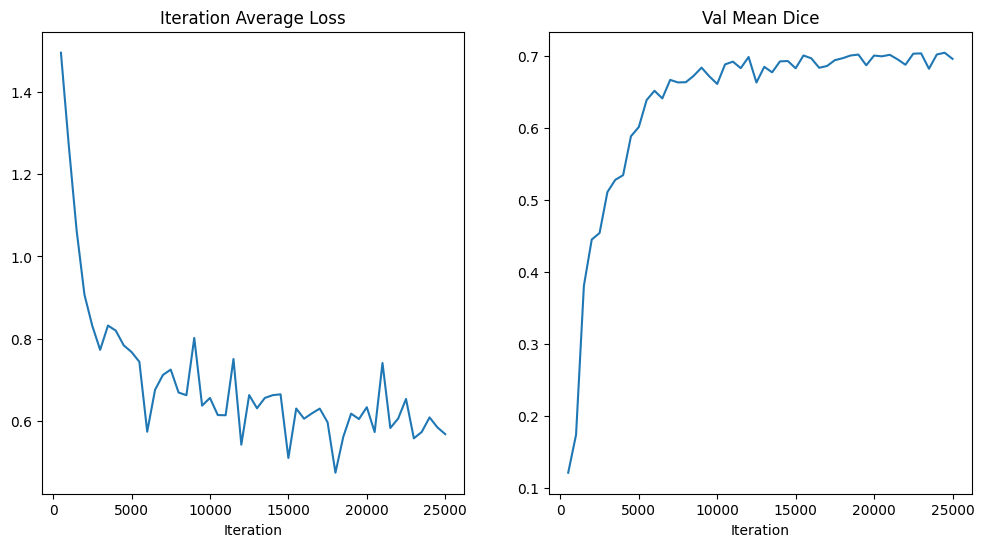

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
#fold4
torch.cuda.empty_cache()

In [5]:
#fold4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset13/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.13it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunet_onmiccai13_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.78633): 100%|█| 24/24 [00:23<00:00,  1.03it/
Training (47 / 25000 Steps) (loss=2.47846): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (71 / 25000 Steps) (loss=2.51424): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (95 / 25000 Steps) (loss=2.17339): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (119 / 25000 Steps) (loss=2.09973): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=2.26350): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=2.07464): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=1.99284): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=1.85617): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (239 / 25000 Steps) (loss=1.98128): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=1.82403): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=1.86041): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.12502598762512207 Current Avg. Dice: 0.12502598762512207


Training (503 / 25000 Steps) (loss=1.49099): 100%|█| 24/24 [00:31<00:00,  1.32s/
Training (527 / 25000 Steps) (loss=1.39040): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=1.33018): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=1.50286): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (599 / 25000 Steps) (loss=1.33563): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=1.27240): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=1.48265): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (671 / 25000 Steps) (loss=1.62023): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=1.41398): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=1.34866): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=1.32462): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=1.40203): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.20340506732463837 Current Avg. Dice: 0.20340506732463837


Training (1007 / 25000 Steps) (loss=1.11129): 100%|█| 24/24 [00:30<00:00,  1.28s
Training (1031 / 25000 Steps) (loss=1.11272): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1055 / 25000 Steps) (loss=1.48819): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1079 / 25000 Steps) (loss=1.16606): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1103 / 25000 Steps) (loss=1.25473): 100%|█| 24/24 [00:18<00:00,  1.26i
Training (1127 / 25000 Steps) (loss=1.21878): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1151 / 25000 Steps) (loss=1.16466): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=1.04537): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1199 / 25000 Steps) (loss=1.09833): 100%|█| 24/24 [00:19<00:00,  1.26i
Training (1223 / 25000 Steps) (loss=1.15452): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1247 / 25000 Steps) (loss=1.03778): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1271 / 25000 Steps) (loss=1.12943): 100%|█| 24/24 [00:18<00:00,  1.26i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3484528362751007 Current Avg. Dice: 0.3484528362751007


Training (1511 / 25000 Steps) (loss=1.28184): 100%|█| 24/24 [00:30<00:00,  1.28s
Training (1535 / 25000 Steps) (loss=1.24282): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1559 / 25000 Steps) (loss=1.08292): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1583 / 25000 Steps) (loss=1.02699): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1607 / 25000 Steps) (loss=1.08737): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=1.07934): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1655 / 25000 Steps) (loss=1.72186): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1679 / 25000 Steps) (loss=1.08530): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1703 / 25000 Steps) (loss=1.03985): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=1.05287): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=1.22825): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1775 / 25000 Steps) (loss=0.92544): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3996521532535553 Current Avg. Dice: 0.3996521532535553


Training (2015 / 25000 Steps) (loss=1.06253): 100%|█| 24/24 [00:30<00:00,  1.29s
Training (2039 / 25000 Steps) (loss=1.01793): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2063 / 25000 Steps) (loss=0.96652): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2087 / 25000 Steps) (loss=0.95708): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2111 / 25000 Steps) (loss=1.94881): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2135 / 25000 Steps) (loss=0.98704): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.93328): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=0.99413): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=1.53153): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2231 / 25000 Steps) (loss=0.96292): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2255 / 25000 Steps) (loss=0.99904): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2279 / 25000 Steps) (loss=0.93858): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5205407738685608 Current Avg. Dice: 0.5205407738685608


Training (2519 / 25000 Steps) (loss=0.96078): 100%|█| 24/24 [00:30<00:00,  1.29s
Training (2543 / 25000 Steps) (loss=0.83219): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2567 / 25000 Steps) (loss=0.95521): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2591 / 25000 Steps) (loss=0.86733): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=0.97886): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2639 / 25000 Steps) (loss=0.98948): 100%|█| 24/24 [00:18<00:00,  1.26i
Training (2663 / 25000 Steps) (loss=0.89963): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.95599): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.99419): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2735 / 25000 Steps) (loss=1.16281): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2759 / 25000 Steps) (loss=0.98010): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.92792): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5205407738685608 Current Avg. Dice: 0.5093473792076111


Training (3023 / 25000 Steps) (loss=0.84955): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (3047 / 25000 Steps) (loss=0.81850): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.73251): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.86153): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3119 / 25000 Steps) (loss=1.11642): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=0.96801): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=1.02552): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.86981): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3215 / 25000 Steps) (loss=0.95310): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3239 / 25000 Steps) (loss=0.85833): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.89464): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=1.22601): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5446118712425232 Current Avg. Dice: 0.5446118712425232


Training (3503 / 25000 Steps) (loss=0.82410): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (3527 / 25000 Steps) (loss=0.77866): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3551 / 25000 Steps) (loss=0.90152): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3575 / 25000 Steps) (loss=0.65466): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.79653): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.74122): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3647 / 25000 Steps) (loss=0.90481): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3671 / 25000 Steps) (loss=0.67027): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.86813): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=0.87767): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=0.94861): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=0.79877): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6140365600585938 Current Avg. Dice: 0.6140365600585938


Training (4007 / 25000 Steps) (loss=0.59013): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (4031 / 25000 Steps) (loss=0.83691): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4055 / 25000 Steps) (loss=0.75685): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.69638): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4103 / 25000 Steps) (loss=0.82241): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=0.84817): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=1.05276): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=0.76664): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4199 / 25000 Steps) (loss=0.87344): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=1.00089): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4247 / 25000 Steps) (loss=0.90906): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4271 / 25000 Steps) (loss=0.79185): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6140365600585938 Current Avg. Dice: 0.5899242758750916


Training (4511 / 25000 Steps) (loss=0.81796): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (4535 / 25000 Steps) (loss=0.96864): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=1.34385): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.82658): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4607 / 25000 Steps) (loss=0.66668): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.77572): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=0.71298): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.74746): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4703 / 25000 Steps) (loss=0.70447): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4727 / 25000 Steps) (loss=0.93162): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4751 / 25000 Steps) (loss=0.76426): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4775 / 25000 Steps) (loss=0.88128): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6140365600585938 Current Avg. Dice: 0.6120772957801819


Training (5015 / 25000 Steps) (loss=0.85934): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (5039 / 25000 Steps) (loss=0.75761): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5063 / 25000 Steps) (loss=0.81918): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5087 / 25000 Steps) (loss=0.77061): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.78960): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.95440): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.60078): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5183 / 25000 Steps) (loss=0.69570): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5207 / 25000 Steps) (loss=0.75409): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=0.74512): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.90941): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.78036): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6455982327461243 Current Avg. Dice: 0.6455982327461243


Training (5519 / 25000 Steps) (loss=0.81129): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (5543 / 25000 Steps) (loss=1.02918): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.56331): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.74944): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5615 / 25000 Steps) (loss=0.82579): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5639 / 25000 Steps) (loss=0.91412): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5663 / 25000 Steps) (loss=0.63063): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5687 / 25000 Steps) (loss=0.63796): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.73522): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.66521): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5759 / 25000 Steps) (loss=0.90222): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.85128): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6978471875190735 Current Avg. Dice: 0.6978471875190735


Training (6023 / 25000 Steps) (loss=0.96299): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (6047 / 25000 Steps) (loss=0.80652): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6071 / 25000 Steps) (loss=1.02810): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.56731): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6119 / 25000 Steps) (loss=0.81612): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6143 / 25000 Steps) (loss=0.74855): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6167 / 25000 Steps) (loss=0.74846): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6191 / 25000 Steps) (loss=0.71861): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6215 / 25000 Steps) (loss=0.56905): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.69538): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.63582): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.48405): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6978471875190735 Current Avg. Dice: 0.6801826357841492


Training (6503 / 25000 Steps) (loss=0.71255): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (6527 / 25000 Steps) (loss=0.68032): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.67180): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6575 / 25000 Steps) (loss=0.80860): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6599 / 25000 Steps) (loss=0.81627): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6623 / 25000 Steps) (loss=0.50782): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=0.59337): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6671 / 25000 Steps) (loss=0.77550): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6695 / 25000 Steps) (loss=0.84630): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6719 / 25000 Steps) (loss=0.66179): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6743 / 25000 Steps) (loss=0.54551): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.80153): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7034406661987305 Current Avg. Dice: 0.7034406661987305


Training (7007 / 25000 Steps) (loss=0.69338): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (7031 / 25000 Steps) (loss=0.87184): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7055 / 25000 Steps) (loss=0.66864): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=0.85971): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=0.52958): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7127 / 25000 Steps) (loss=0.58007): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.67567): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.80498): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.60135): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7223 / 25000 Steps) (loss=0.73475): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7247 / 25000 Steps) (loss=0.72563): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7271 / 25000 Steps) (loss=0.68271): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7034406661987305 Current Avg. Dice: 0.6953189969062805


Training (7511 / 25000 Steps) (loss=0.62658): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (7535 / 25000 Steps) (loss=0.61886): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.67936): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.60909): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=1.50659): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=0.83401): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7655 / 25000 Steps) (loss=0.58240): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.53640): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7703 / 25000 Steps) (loss=0.63710): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=0.73239): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7751 / 25000 Steps) (loss=0.60588): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7775 / 25000 Steps) (loss=0.71833): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7056286931037903 Current Avg. Dice: 0.7056286931037903


Training (8015 / 25000 Steps) (loss=0.76844): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (8039 / 25000 Steps) (loss=0.74427): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8063 / 25000 Steps) (loss=0.80359): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.69472): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.65857): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8135 / 25000 Steps) (loss=0.88622): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8159 / 25000 Steps) (loss=0.78614): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8183 / 25000 Steps) (loss=0.51704): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8207 / 25000 Steps) (loss=0.74558): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8231 / 25000 Steps) (loss=0.60147): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8255 / 25000 Steps) (loss=0.57863): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8279 / 25000 Steps) (loss=0.77983): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7358677983283997 Current Avg. Dice: 0.7358677983283997


Training (8519 / 25000 Steps) (loss=0.84354): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (8543 / 25000 Steps) (loss=0.53283): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8567 / 25000 Steps) (loss=0.56753): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.76697): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=0.78942): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.73211): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.79856): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8687 / 25000 Steps) (loss=0.64576): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8711 / 25000 Steps) (loss=0.94821): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8735 / 25000 Steps) (loss=0.57471): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8759 / 25000 Steps) (loss=0.65234): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.61373): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7358677983283997 Current Avg. Dice: 0.6816349625587463


Training (9023 / 25000 Steps) (loss=0.45600): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (9047 / 25000 Steps) (loss=0.40240): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=0.66048): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=0.97456): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.73956): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.62913): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.57516): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9191 / 25000 Steps) (loss=0.60209): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9215 / 25000 Steps) (loss=0.67132): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9239 / 25000 Steps) (loss=0.46920): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=0.78617): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9287 / 25000 Steps) (loss=0.75989): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7358677983283997 Current Avg. Dice: 0.7259467244148254


Training (9503 / 25000 Steps) (loss=0.56916): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (9527 / 25000 Steps) (loss=0.74807): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9551 / 25000 Steps) (loss=0.70790): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9575 / 25000 Steps) (loss=0.65858): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9599 / 25000 Steps) (loss=0.92947): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.58515): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9647 / 25000 Steps) (loss=0.44034): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9671 / 25000 Steps) (loss=0.56366): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9695 / 25000 Steps) (loss=0.60199): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9719 / 25000 Steps) (loss=0.64195): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=1.02189): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9767 / 25000 Steps) (loss=0.60402): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7358677983283997 Current Avg. Dice: 0.732611358165741


Training (10007 / 25000 Steps) (loss=0.79672): 100%|█| 24/24 [00:30<00:00,  1.25
Training (10031 / 25000 Steps) (loss=0.66878): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10055 / 25000 Steps) (loss=0.55861): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10079 / 25000 Steps) (loss=0.81659): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10103 / 25000 Steps) (loss=0.64402): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=0.77656): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10151 / 25000 Steps) (loss=0.65872): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10175 / 25000 Steps) (loss=0.83452): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.74897): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10223 / 25000 Steps) (loss=0.73666): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10247 / 25000 Steps) (loss=0.49938): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10271 / 25000 Steps) (loss=0.64149): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7358677983283997 Current Avg. Dice: 0.7130510210990906


Training (10511 / 25000 Steps) (loss=0.53918): 100%|█| 24/24 [00:30<00:00,  1.25
Training (10535 / 25000 Steps) (loss=0.82285): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10559 / 25000 Steps) (loss=0.78597): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10583 / 25000 Steps) (loss=0.53697): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10607 / 25000 Steps) (loss=0.58304): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10631 / 25000 Steps) (loss=0.40780): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10655 / 25000 Steps) (loss=0.44860): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.62580): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10703 / 25000 Steps) (loss=0.71242): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10727 / 25000 Steps) (loss=0.64174): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10751 / 25000 Steps) (loss=0.63349): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.85069): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7370216846466064


Training (11015 / 25000 Steps) (loss=0.70655): 100%|█| 24/24 [00:30<00:00,  1.26
Training (11039 / 25000 Steps) (loss=0.61628): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.86418): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11087 / 25000 Steps) (loss=0.73517): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11111 / 25000 Steps) (loss=0.54517): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.84253): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11159 / 25000 Steps) (loss=0.72951): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11183 / 25000 Steps) (loss=0.51950): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=0.66892): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11231 / 25000 Steps) (loss=0.71608): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11255 / 25000 Steps) (loss=0.75328): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.85223): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7017528414726257


Training (11519 / 25000 Steps) (loss=0.84208): 100%|█| 24/24 [00:30<00:00,  1.25
Training (11543 / 25000 Steps) (loss=0.58687): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11567 / 25000 Steps) (loss=0.42367): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11591 / 25000 Steps) (loss=0.78585): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11615 / 25000 Steps) (loss=0.78118): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11639 / 25000 Steps) (loss=0.91419): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11663 / 25000 Steps) (loss=0.77889): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11687 / 25000 Steps) (loss=0.61302): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11711 / 25000 Steps) (loss=0.83481): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.65376): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11759 / 25000 Steps) (loss=0.45727): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11783 / 25000 Steps) (loss=0.79287): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7287684082984924


Training (12023 / 25000 Steps) (loss=0.77719): 100%|█| 24/24 [00:30<00:00,  1.25
Training (12047 / 25000 Steps) (loss=0.64254): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12071 / 25000 Steps) (loss=0.68498): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=0.70815): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12119 / 25000 Steps) (loss=0.71478): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12143 / 25000 Steps) (loss=0.72347): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.49169): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12191 / 25000 Steps) (loss=0.72673): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12215 / 25000 Steps) (loss=0.57694): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12239 / 25000 Steps) (loss=0.60156): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12263 / 25000 Steps) (loss=0.57937): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.59662): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7260163426399231


Training (12503 / 25000 Steps) (loss=0.54451): 100%|█| 24/24 [00:30<00:00,  1.25
Training (12527 / 25000 Steps) (loss=0.84459): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=0.83497): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12575 / 25000 Steps) (loss=0.67633): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12599 / 25000 Steps) (loss=0.86089): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12623 / 25000 Steps) (loss=0.65178): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.71000): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.54145): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12695 / 25000 Steps) (loss=0.56448): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.50013): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12743 / 25000 Steps) (loss=0.72353): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12767 / 25000 Steps) (loss=0.66861): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.6949787139892578


Training (13007 / 25000 Steps) (loss=0.66739): 100%|█| 24/24 [00:29<00:00,  1.25
Training (13031 / 25000 Steps) (loss=0.64188): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13055 / 25000 Steps) (loss=0.35530): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.50964): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13103 / 25000 Steps) (loss=0.70830): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13127 / 25000 Steps) (loss=0.60242): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13151 / 25000 Steps) (loss=0.59236): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13175 / 25000 Steps) (loss=0.62799): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.61553): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=0.54988): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13247 / 25000 Steps) (loss=0.74486): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.82547): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7341668009757996


Training (13511 / 25000 Steps) (loss=0.82297): 100%|█| 24/24 [00:30<00:00,  1.25
Training (13535 / 25000 Steps) (loss=0.65954): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=0.70120): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.81482): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.52645): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13631 / 25000 Steps) (loss=0.70328): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.72733): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13679 / 25000 Steps) (loss=0.66035): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.59645): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13727 / 25000 Steps) (loss=0.58594): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13751 / 25000 Steps) (loss=0.40209): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13775 / 25000 Steps) (loss=0.59099): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7344746589660645


Training (14015 / 25000 Steps) (loss=0.87005): 100%|█| 24/24 [00:29<00:00,  1.25
Training (14039 / 25000 Steps) (loss=0.73771): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14063 / 25000 Steps) (loss=0.50109): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14087 / 25000 Steps) (loss=0.77006): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.66509): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14135 / 25000 Steps) (loss=0.66323): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14159 / 25000 Steps) (loss=0.64620): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14183 / 25000 Steps) (loss=0.44151): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.73431): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14231 / 25000 Steps) (loss=0.63991): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14255 / 25000 Steps) (loss=0.73961): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14279 / 25000 Steps) (loss=0.42407): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7108616828918457


Training (14519 / 25000 Steps) (loss=0.79749): 100%|█| 24/24 [00:30<00:00,  1.25
Training (14543 / 25000 Steps) (loss=0.50658): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14567 / 25000 Steps) (loss=0.71341): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14591 / 25000 Steps) (loss=0.80127): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14615 / 25000 Steps) (loss=0.69479): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=0.73625): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14663 / 25000 Steps) (loss=0.67826): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14687 / 25000 Steps) (loss=0.55565): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14711 / 25000 Steps) (loss=0.61995): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14735 / 25000 Steps) (loss=0.61759): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14759 / 25000 Steps) (loss=0.48261): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14783 / 25000 Steps) (loss=0.73291): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7226775288581848


Training (15023 / 25000 Steps) (loss=0.54422): 100%|█| 24/24 [00:30<00:00,  1.27
Training (15047 / 25000 Steps) (loss=0.50566): 100%|█| 24/24 [00:18<00:00,  1.27
Training (15071 / 25000 Steps) (loss=0.58418): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15095 / 25000 Steps) (loss=0.66861): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15119 / 25000 Steps) (loss=0.61696): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.41963): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.43045): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.69313): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.54404): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15239 / 25000 Steps) (loss=0.62971): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.46136): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15287 / 25000 Steps) (loss=0.77842): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7323341369628906


Training (15503 / 25000 Steps) (loss=0.62814): 100%|█| 24/24 [00:30<00:00,  1.27
Training (15527 / 25000 Steps) (loss=0.69049): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15551 / 25000 Steps) (loss=0.79736): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15575 / 25000 Steps) (loss=0.56295): 100%|█| 24/24 [00:18<00:00,  1.27
Training (15599 / 25000 Steps) (loss=0.60267): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15623 / 25000 Steps) (loss=0.62413): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.65689): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.68802): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15695 / 25000 Steps) (loss=0.74951): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15719 / 25000 Steps) (loss=0.65531): 100%|█| 24/24 [00:18<00:00,  1.27
Training (15743 / 25000 Steps) (loss=0.68842): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15767 / 25000 Steps) (loss=0.69616): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7267983555793762


Training (16007 / 25000 Steps) (loss=0.72895): 100%|█| 24/24 [00:30<00:00,  1.28
Training (16031 / 25000 Steps) (loss=0.71609): 100%|█| 24/24 [00:18<00:00,  1.27
Training (16055 / 25000 Steps) (loss=0.56739): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16079 / 25000 Steps) (loss=0.78104): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16103 / 25000 Steps) (loss=0.49306): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16127 / 25000 Steps) (loss=0.60677): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16151 / 25000 Steps) (loss=0.55520): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16175 / 25000 Steps) (loss=0.32239): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16199 / 25000 Steps) (loss=0.74821): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16223 / 25000 Steps) (loss=0.69797): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16247 / 25000 Steps) (loss=0.57263): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16271 / 25000 Steps) (loss=0.73624): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7001879811286926


Training (16511 / 25000 Steps) (loss=0.58460): 100%|█| 24/24 [00:29<00:00,  1.25
Training (16535 / 25000 Steps) (loss=0.78666): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.56288): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16583 / 25000 Steps) (loss=0.29745): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16607 / 25000 Steps) (loss=0.62460): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=0.64208): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.59714): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.75953): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16703 / 25000 Steps) (loss=0.66669): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.65020): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.75180): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16775 / 25000 Steps) (loss=0.53919): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7025437355041504


Training (17015 / 25000 Steps) (loss=0.62515): 100%|█| 24/24 [00:29<00:00,  1.25
Training (17039 / 25000 Steps) (loss=0.77269): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17063 / 25000 Steps) (loss=0.55628): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17087 / 25000 Steps) (loss=0.71109): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17111 / 25000 Steps) (loss=0.76295): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17135 / 25000 Steps) (loss=0.59933): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17159 / 25000 Steps) (loss=0.57989): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17183 / 25000 Steps) (loss=0.91118): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17207 / 25000 Steps) (loss=0.79630): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17231 / 25000 Steps) (loss=0.81071): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17255 / 25000 Steps) (loss=0.65060): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.59794): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7088261246681213


Training (17519 / 25000 Steps) (loss=0.74953): 100%|█| 24/24 [00:30<00:00,  1.25
Training (17543 / 25000 Steps) (loss=0.65758): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.67737): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17591 / 25000 Steps) (loss=0.48718): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17615 / 25000 Steps) (loss=0.61605): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.81988): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17663 / 25000 Steps) (loss=0.79445): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17687 / 25000 Steps) (loss=0.64033): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17711 / 25000 Steps) (loss=0.34316): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17735 / 25000 Steps) (loss=0.74725): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17759 / 25000 Steps) (loss=0.63260): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17783 / 25000 Steps) (loss=0.58556): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7364096641540527


Training (18023 / 25000 Steps) (loss=0.82635): 100%|█| 24/24 [00:30<00:00,  1.25
Training (18047 / 25000 Steps) (loss=0.50023): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18071 / 25000 Steps) (loss=0.75156): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18095 / 25000 Steps) (loss=0.69806): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18119 / 25000 Steps) (loss=0.60816): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18143 / 25000 Steps) (loss=0.67610): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18167 / 25000 Steps) (loss=0.71360): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18191 / 25000 Steps) (loss=0.70713): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18215 / 25000 Steps) (loss=0.69945): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.67529): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18263 / 25000 Steps) (loss=0.37721): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18287 / 25000 Steps) (loss=0.62832): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7370216846466064 Current Avg. Dice: 0.7328081130981445


Training (18503 / 25000 Steps) (loss=0.52070): 100%|█| 24/24 [00:30<00:00,  1.25
Training (18527 / 25000 Steps) (loss=0.52545): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18551 / 25000 Steps) (loss=0.68028): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18575 / 25000 Steps) (loss=0.71411): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18599 / 25000 Steps) (loss=0.43857): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18623 / 25000 Steps) (loss=0.66081): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18647 / 25000 Steps) (loss=0.52978): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18671 / 25000 Steps) (loss=0.34620): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18695 / 25000 Steps) (loss=0.64855): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18719 / 25000 Steps) (loss=0.59985): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=0.47583): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18767 / 25000 Steps) (loss=0.47425): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7563993334770203 Current Avg. Dice: 0.7563993334770203


Training (19007 / 25000 Steps) (loss=0.61494): 100%|█| 24/24 [00:30<00:00,  1.26
Training (19031 / 25000 Steps) (loss=0.55959): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19055 / 25000 Steps) (loss=0.38967): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19079 / 25000 Steps) (loss=0.69339): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.62204): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19127 / 25000 Steps) (loss=0.66164): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19151 / 25000 Steps) (loss=0.69088): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19175 / 25000 Steps) (loss=0.59346): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19199 / 25000 Steps) (loss=0.70405): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19223 / 25000 Steps) (loss=0.69264): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19247 / 25000 Steps) (loss=0.68627): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19271 / 25000 Steps) (loss=0.60522): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7563993334770203 Current Avg. Dice: 0.7279062271118164


Training (19511 / 25000 Steps) (loss=0.80892): 100%|█| 24/24 [00:30<00:00,  1.25
Training (19535 / 25000 Steps) (loss=0.61757): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19559 / 25000 Steps) (loss=0.79380): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19583 / 25000 Steps) (loss=0.60728): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19607 / 25000 Steps) (loss=0.65915): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19631 / 25000 Steps) (loss=0.65912): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19655 / 25000 Steps) (loss=0.73663): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19679 / 25000 Steps) (loss=0.45460): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19703 / 25000 Steps) (loss=0.63665): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19727 / 25000 Steps) (loss=0.60400): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19751 / 25000 Steps) (loss=0.46569): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19775 / 25000 Steps) (loss=0.50385): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7563993334770203 Current Avg. Dice: 0.7478208541870117


Training (20015 / 25000 Steps) (loss=0.70962): 100%|█| 24/24 [00:30<00:00,  1.25
Training (20039 / 25000 Steps) (loss=0.63640): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20063 / 25000 Steps) (loss=0.87796): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20087 / 25000 Steps) (loss=0.60198): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20111 / 25000 Steps) (loss=0.60705): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20135 / 25000 Steps) (loss=0.60206): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20159 / 25000 Steps) (loss=0.53029): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.76650): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.57709): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20231 / 25000 Steps) (loss=0.61632): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20255 / 25000 Steps) (loss=0.43611): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20279 / 25000 Steps) (loss=0.47901): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7594379782676697 Current Avg. Dice: 0.7594379782676697


Training (20519 / 25000 Steps) (loss=0.89512): 100%|█| 24/24 [00:30<00:00,  1.26
Training (20543 / 25000 Steps) (loss=0.51650): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20567 / 25000 Steps) (loss=0.62593): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20591 / 25000 Steps) (loss=0.71992): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20615 / 25000 Steps) (loss=0.83794): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.46820): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.66462): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20687 / 25000 Steps) (loss=0.81507): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20711 / 25000 Steps) (loss=0.59354): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.54133): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=0.48468): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.26998): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7594379782676697 Current Avg. Dice: 0.7580953240394592


Training (21023 / 25000 Steps) (loss=0.46226): 100%|█| 24/24 [00:30<00:00,  1.25
Training (21047 / 25000 Steps) (loss=0.71940): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21071 / 25000 Steps) (loss=0.70636): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21095 / 25000 Steps) (loss=0.65521): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21119 / 25000 Steps) (loss=0.54458): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.53031): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21167 / 25000 Steps) (loss=0.82656): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.66109): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.39057): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=0.88750): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21263 / 25000 Steps) (loss=0.69771): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.64815): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7594379782676697 Current Avg. Dice: 0.7548137307167053


Training (21503 / 25000 Steps) (loss=0.43446): 100%|█| 24/24 [00:30<00:00,  1.25
Training (21527 / 25000 Steps) (loss=0.57079): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21551 / 25000 Steps) (loss=0.49257): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.43539): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=0.42160): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21623 / 25000 Steps) (loss=0.66363): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21647 / 25000 Steps) (loss=0.85125): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21671 / 25000 Steps) (loss=0.74727): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21695 / 25000 Steps) (loss=0.84415): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21719 / 25000 Steps) (loss=0.67572): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21743 / 25000 Steps) (loss=0.59496): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21767 / 25000 Steps) (loss=0.52476): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7594379782676697 Current Avg. Dice: 0.7463264465332031


Training (22007 / 25000 Steps) (loss=0.55093): 100%|█| 24/24 [00:30<00:00,  1.25
Training (22031 / 25000 Steps) (loss=0.74697): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22055 / 25000 Steps) (loss=0.63921): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22079 / 25000 Steps) (loss=0.44390): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22103 / 25000 Steps) (loss=0.38936): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22127 / 25000 Steps) (loss=0.66494): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22151 / 25000 Steps) (loss=0.64523): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22175 / 25000 Steps) (loss=0.66521): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22199 / 25000 Steps) (loss=0.60423): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.49408): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22247 / 25000 Steps) (loss=0.60802): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.44732): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7594379782676697 Current Avg. Dice: 0.7318994998931885


Training (22511 / 25000 Steps) (loss=0.53842): 100%|█| 24/24 [00:29<00:00,  1.25
Training (22535 / 25000 Steps) (loss=0.41523): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22559 / 25000 Steps) (loss=0.73879): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=0.53969): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22607 / 25000 Steps) (loss=0.70532): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22631 / 25000 Steps) (loss=0.44980): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22655 / 25000 Steps) (loss=0.54316): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22679 / 25000 Steps) (loss=0.66608): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.56279): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22727 / 25000 Steps) (loss=0.69096): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22751 / 25000 Steps) (loss=0.70811): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22775 / 25000 Steps) (loss=0.68222): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7594379782676697 Current Avg. Dice: 0.7381541728973389


Training (23015 / 25000 Steps) (loss=0.57845): 100%|█| 24/24 [00:29<00:00,  1.25
Training (23039 / 25000 Steps) (loss=0.64382): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23063 / 25000 Steps) (loss=0.84724): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23087 / 25000 Steps) (loss=0.73242): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23111 / 25000 Steps) (loss=0.59006): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23135 / 25000 Steps) (loss=0.64619): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23159 / 25000 Steps) (loss=0.56711): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23183 / 25000 Steps) (loss=0.76312): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23207 / 25000 Steps) (loss=0.80295): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23231 / 25000 Steps) (loss=0.65690): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23255 / 25000 Steps) (loss=0.40296): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=0.61039): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7594379782676697 Current Avg. Dice: 0.75246661901474


Training (23519 / 25000 Steps) (loss=0.44930): 100%|█| 24/24 [00:30<00:00,  1.25
Training (23543 / 25000 Steps) (loss=0.49693): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23567 / 25000 Steps) (loss=0.32785): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23591 / 25000 Steps) (loss=0.66685): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23615 / 25000 Steps) (loss=0.50529): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23639 / 25000 Steps) (loss=1.35410): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23663 / 25000 Steps) (loss=0.56986): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23687 / 25000 Steps) (loss=0.36700): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23711 / 25000 Steps) (loss=0.52073): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23735 / 25000 Steps) (loss=0.53911): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.39740): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.46377): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7594379782676697 Current Avg. Dice: 0.710726261138916


Training (24023 / 25000 Steps) (loss=0.77979): 100%|█| 24/24 [00:30<00:00,  1.25
Training (24047 / 25000 Steps) (loss=0.53861): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24071 / 25000 Steps) (loss=0.65093): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24095 / 25000 Steps) (loss=0.61225): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24119 / 25000 Steps) (loss=0.75992): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24143 / 25000 Steps) (loss=0.54604): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24167 / 25000 Steps) (loss=0.50347): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24191 / 25000 Steps) (loss=0.85566): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24215 / 25000 Steps) (loss=0.59535): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24239 / 25000 Steps) (loss=0.64128): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24263 / 25000 Steps) (loss=0.70681): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.71185): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7616481781005859 Current Avg. Dice: 0.7616481781005859


Training (24503 / 25000 Steps) (loss=0.54462): 100%|█| 24/24 [00:30<00:00,  1.26
Training (24527 / 25000 Steps) (loss=0.32159): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24551 / 25000 Steps) (loss=0.54858): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24575 / 25000 Steps) (loss=0.67082): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24599 / 25000 Steps) (loss=0.74373): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24623 / 25000 Steps) (loss=0.66793): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=0.56691): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.69494): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24695 / 25000 Steps) (loss=0.65582): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.56738): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24743 / 25000 Steps) (loss=0.64040): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24767 / 25000 Steps) (loss=0.48587): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7616481781005859 Current Avg. Dice: 0.7368605732917786


Training (25007 / 25000 Steps) (loss=0.54017): 100%|█| 24/24 [00:30<00:00,  1.25


In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7616 at iteration: 24500


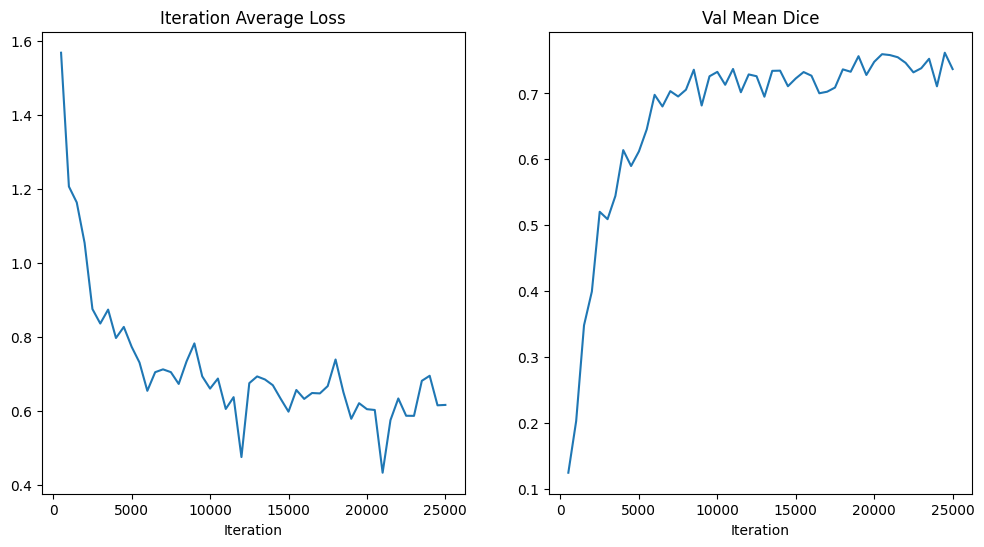

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()